In [1]:
import pandas as pd
import datetime
import numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit as tss
from sklearn import metrics

In [2]:
%config IPCompleter.greedy = True

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# Load the Data

In [4]:
df = pd.read_csv("./RAW_DATA/dublinbus_nov.csv")

### Information on the data

Print the number of rows and columns for the data

In [5]:
print("Rows:" ,df.shape[0])
print("Columns:" ,df.shape[1])

Rows: 9733164
Columns: 16


Print the head and tail of the data to examine it in more detail

In [6]:
df.head()

DayOfService   TripID LineId  Direction  TPlannedTime_Arr  \
0  2018-11-01 00:00:00  8064443     15          1             34061   
1  2018-11-01 00:00:00  8064443     15          1             34061   
2  2018-11-01 00:00:00  8064443     15          1             34061   
3  2018-11-01 00:00:00  8064443     15          1             34061   
4  2018-11-01 00:00:00  8064443     15          1             34061   

   TPlannedTime_Dep  TActualTime_Arr  TActualTime_Dep  progrnumber  \
0             29160          34504.0          29167.0            2   
1             29160          34504.0          29167.0            3   
2             29160          34504.0          29167.0            4   
3             29160          34504.0          29167.0            5   
4             29160          34504.0          29167.0            6   

   stoppointid  Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  \
0         6319             29193             29193            29192   
1         7246             29233             29233            29236   
2         6320             29318             29318            29335   
3         4594             29419             29419            29440   
4         4595             29570             29570            29546   

   Lactualtime_dep  vehicleid           lastupdate  
0            29202    2534808  2018-11-29 07:38:40  
1            29247    2534808  2018-11-29 07:38:40  
2            29353    2534808  2018-11-29 07:38:40  
3            29462    2534808  2018-11-29 07:38:40  
4            29573    2534808  2018-11-29 07:38:40

In [7]:
df.tail()

DayOfService   TripID LineId  Direction  TPlannedTime_Arr  \
9733159  2018-11-30 00:00:00  8148957     41          1             68324   
9733160  2018-11-30 00:00:00  8148957     41          1             68324   
9733161  2018-11-30 00:00:00  8148957     41          1             68324   
9733162  2018-11-30 00:00:00  8148957     41          1             68324   
9733163  2018-11-30 00:00:00  8148957     41          1             68324   

         TPlannedTime_Dep  TActualTime_Arr  TActualTime_Dep  progrnumber  \
9733159             64200          68369.0          64186.0           14   
9733160             64200          68369.0          64186.0            1   
9733161             64200          68369.0          64186.0           40   
9733162             64200          68369.0          64186.0            3   
9733163             64200          68369.0          64186.0           43   

         stoppointid  Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  \
9733159          203             65317             65317            65390   
9733160          288             64200             64200            64186   
9733161         5075             67856             67856            67912   
9733162         1172             64329             64329            64390   
9733163         3864             68007             68007            68085   

         Lactualtime_dep  vehicleid           lastupdate  
9733159            65417    1932358  2018-12-14 05:28:52  
9733160            64186    1932358  2018-12-14 05:28:52  
9733161            67926    1932358  2018-12-14 05:28:52  
9733162            64401    1932358  2018-12-14 05:28:52  
9733163            68100    1932358  2018-12-14 05:28:52

### Examine features and their data types

In [8]:
df.dtypes

DayOfService         object
TripID                int64
LineId               object
Direction             int64
TPlannedTime_Arr      int64
TPlannedTime_Dep      int64
TActualTime_Arr     float64
TActualTime_Dep     float64
progrnumber           int64
stoppointid           int64
Lplannedtime_arr      int64
Lplannedtime_dep      int64
Lactualtime_arr       int64
Lactualtime_dep       int64
vehicleid             int64
lastupdate           object
dtype: object

### Reassign the datatypes to suitable forms

We will leave the datatypes that are of type int64 and float64 as they are and select them below as continuous columns. Convert the other features to their appropriate data types. We will convert DayOfService and LineId to categorical features. Lastupdate is converted to a int64 feature as the values are all integer

In [9]:
categorical_columns = df[['LineId', 'Direction']].columns
continuous_columns = df[['TripID','TPlannedTime_Arr','TPlannedTime_Dep','TActualTime_Arr','TActualTime_Dep','progrnumber','stoppointid','Lplannedtime_arr','Lplannedtime_dep','Lactualtime_arr','Lactualtime_dep','vehicleid']].columns
datetime_columns = df[['DayOfService', 'lastupdate']].columns

for column in categorical_columns:
    df[column] = df[column].astype('category')  

for column in datetime_columns:
    df[column] = pd.to_datetime(df[column]).astype('int64')  
    
df.dtypes

DayOfService           int64
TripID                 int64
LineId              category
Direction           category
TPlannedTime_Arr       int64
TPlannedTime_Dep       int64
TActualTime_Arr      float64
TActualTime_Dep      float64
progrnumber            int64
stoppointid            int64
Lplannedtime_arr       int64
Lplannedtime_dep       int64
Lactualtime_arr        int64
Lactualtime_dep        int64
vehicleid              int64
lastupdate             int64
dtype: object

# Initial Checks on Data

### Examine Duplicate columns *WARNING WILL TAKE VERY LONG*

In [10]:
#dfT = df.T
#print("Number of duplicate (excluding first) columns in the table is: ", dfT.duplicated().sum())
#print("Number of duplicate (including first) columns in the table is: ",  dfT[dfT.duplicated(keep=False)].shape[0])

We all know determine if it makes sense to keep our drop these columns

### Examine the columns in more detail 

Examine each of the counts, unique values, mean std and other metrics for each of the columns

In [11]:
df.select_dtypes(['category']).describe().T

count unique top     freq
LineId     9733164    119  27   423055
Direction  9733164      2   2  4926008

In [12]:
df.select_dtypes(['int64']).describe().T

count          mean           std           min  \
DayOfService      9733164.0  1.542296e+18  7.521679e+14  1.541030e+18   
TripID            9733164.0  8.118155e+06  1.934816e+04  8.064443e+06   
TPlannedTime_Arr  9733164.0  5.511583e+04  1.742481e+04  1.876100e+04   
TPlannedTime_Dep  9733164.0  5.103567e+04  1.764398e+04  1.620000e+04   
progrnumber       9733164.0  3.133708e+01  2.000087e+01  1.000000e+00   
stoppointid       9733164.0  2.455597e+03  2.028739e+03  2.000000e+00   
Lplannedtime_arr  9733164.0  5.307813e+04  1.757864e+04  1.631700e+04   
Lplannedtime_dep  9733164.0  5.307813e+04  1.757864e+04  1.631700e+04   
Lactualtime_arr   9733164.0  5.327107e+04  1.759673e+04  1.661400e+04   
Lactualtime_dep   9733164.0  5.328426e+04  1.759581e+04  1.661400e+04   
vehicleid         9733164.0  2.097526e+06  8.426008e+05  1.000110e+06   
lastupdate        9733164.0  1.543326e+18  8.036764e+14  1.542125e+18   

                           25%           50%           75%           max  
DayOfService      1.541635e+18  1.542326e+18  1.542931e+18  1.543536e+18  
TripID            8.109378e+06  8.121262e+06  8.130451e+06  8.148957e+06  
TPlannedTime_Arr  3.963400e+04  5.507500e+04  6.920100e+04  9.111100e+04  
TPlannedTime_Dep  3.558000e+04  5.076000e+04  6.480000e+04  8.760000e+04  
progrnumber       1.500000e+01  2.900000e+01  4.500000e+01  1.030000e+02  
stoppointid       8.530000e+02  1.873000e+03  3.672000e+03  7.671000e+03  
Lplannedtime_arr  3.764500e+04  5.294200e+04  6.719100e+04  9.111100e+04  
Lplannedtime_dep  3.764500e+04  5.294200e+04  6.719100e+04  9.111100e+04  
Lactualtime_arr   3.779000e+04  5.316200e+04  6.749900e+04  9.260600e+04  
Lactualtime_dep   3.780100e+04  5.317600e+04  6.751200e+04  9.260600e+04  
vehicleid         1.001123e+06  2.406878e+06  2.693291e+06  3.303849e+06  
lastupdate        1.542785e+18  1.543477e+18  1.543912e+18  1.544765e+18

In [13]:
df.select_dtypes(['float64']).describe().T

count          mean           std      min      25%  \
TActualTime_Arr  9202802.0  55114.317776  17343.344199  17927.0  39655.0   
TActualTime_Dep  9037693.0  51207.224973  17592.437059  17365.0  35984.0   

                     50%      75%      max  
TActualTime_Arr  55013.0  69241.0  92606.0  
TActualTime_Dep  50951.0  64870.0  88991.0

We do find evidence of duplicate columns Lactualtime_arr and Lactualtime_dep in our data, as these correspond two actual times that we will not have access to on the server where our model will reside we can drop them. Featuers Lplannedtime_arr and Lplannedtime_dep are also duplicates, as these are planned arrival times we could consider keeping one of these rows depending on the target feature we will use. Since we will use TActualTime_Arr to create our target feature it makes sense to keep Lplannedtime_arr and drop Lplannedtime_dep

We do not have any constant columns in our data it is important to note that some columns were dropped when making the monthly data For more information on the columns that were used please see the accompanying SQL file for the creation of this monthly data.

### Examine duplicate rows in the data

In [14]:
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated().sum())
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


### Print out the duplicate rows

In [15]:
df[df.duplicated(keep=False)].sort_values(by = df.columns.to_list())

Empty DataFrame
Columns: [DayOfService, TripID, LineId, Direction, TPlannedTime_Arr, TPlannedTime_Dep, TActualTime_Arr, TActualTime_Dep, progrnumber, stoppointid, Lplannedtime_arr, Lplannedtime_dep, Lactualtime_arr, Lactualtime_dep, vehicleid, lastupdate]
Index: []

We do not find any evidence of duplicate rows, this is encouraging that our data is relatively clean

# Analyse the data for missing values

As we can see from the below there are many missing values in the data, we will have to come up with a handling strategy for these later

In [16]:
df.isnull().sum()

DayOfService             0
TripID                   0
LineId                   0
Direction                0
TPlannedTime_Arr         0
TPlannedTime_Dep         0
TActualTime_Arr     530362
TActualTime_Dep     695471
progrnumber              0
stoppointid              0
Lplannedtime_arr         0
Lplannedtime_dep         0
Lactualtime_arr          0
Lactualtime_dep          0
vehicleid                0
lastupdate               0
dtype: int64

The below shows the percentage of missing values for each of the features so far

In [17]:
# the following code origionated from sample_solution_COMP47350_DQR_DQP_DataExploration_DataPrep_CreditRiskPrediction from lab5
columns_perc_missing  = 100 * (df.isnull().sum()/df.shape[0])

# Store the values in a dataframe
df_perc_missing = pd.DataFrame(columns_perc_missing, columns=['%missing'])
df_perc_missing

%missing
DayOfService      0.000000
TripID            0.000000
LineId            0.000000
Direction         0.000000
TPlannedTime_Arr  0.000000
TPlannedTime_Dep  0.000000
TActualTime_Arr   5.449019
TActualTime_Dep   7.145374
progrnumber       0.000000
stoppointid       0.000000
Lplannedtime_arr  0.000000
Lplannedtime_dep  0.000000
Lactualtime_arr   0.000000
Lactualtime_dep   0.000000
vehicleid         0.000000
lastupdate        0.000000

# Examine Differences from 2018 to 2021 data

In [18]:
route_short_names_2021 = ["1","102","104","11","111","114","116","118","120",
"122","123","13","130","14","140","142","145","14c","15","15d","150","155",
"151","15a","15b","16","161","16c","16d","17","17a","18","184","185","220",
"236","238","239","25","25a","25b","25d","25x","26","27","270","27a","27b",
"27x","29a","31","31a","31b","31d","32","32x","33","33a","33b","33b","33e",
"33x","37","38","38a","38b","38d","39","39a","39x","4","40","40b","40d","40e",
"41","41a","41b","41c","41d","41x","42","42d","43","44","44b","45a","46a",
"46e","47","49","51d","51x","53","53a","54a","56a","59","6","61","63","65",
"65b","66","66a","66b","66e","66x","67","67x","68","68x","68a","69","69x","7",
"7a","70","70d","747","75","76","76a","77a","77x","79","79a","7b","7d","8",
"83","83a","84","84a","84x","86","9","451","757","H1","H2","H3","H9","1","102",
"104","11","111","114","116","118","120","122","123","13","130","14","140","142",
"145","14c","15","15d","150","151","155","15a","15b","16","161","16c","16d",
"17","17a","18","184","185","220","236","238","239","25","25a","25b","25d",
"25x","26","27","270","27a","27b","27x","29a","31","31a","31b","31d","32","32x",
"33","33a","33b","33d","33e","33x","37","38","38a","38b","38d","39","39a","39x",
"4","40","40b","40d","40e","41","41a","41b","41c","41d","41x","42","42d","43",
"44","44b","45a","46a","46e","47","49","51d","51x","53","53a","54a","56a","59",
"6","61","63","65","65b","66","66a","66b","66e","66x","67","67x","68","68x",
"68a","69","69x","7","7a","70","70d","747","75","76","76a","77a","77x","79",
"79a","7b","7d","8","83","83a","84","84a","84x","86","9","451","757","H1",
"H2","H3","H9"]

In [19]:
for lineid in df["LineId"].unique():
    if lineid not in route_short_names_2021:
        print(lineid)

7A
25B
25A
66X
41C
7B
67X
27B
46A
29A
77A
68X
25D
38B
38A
51D
16C
66A
39A
79A
66B
33A
33X
27A
17A
83A
31A
41X
68A
15B
84X
84A
54A
41B
40D
65B
31D
46E
40B
33B
14C
15A
31B
25X
27X
41A
15D
76A
44B
32X
33D
39X
51X
56A
7D
69X
70D
38D
77X
42D


There exist LineId's in the data above that no longer exist according to the lastest gtfs data.

In [20]:
stops = ["Parnell Square West, stop 2",
"Parnell Square West, stop 3",
"Parnell Square West, stop 4",
"Parnell Square West, stop 6",
"Parnell Square West, stop 7",
"Parnell Square West, stop 8",
"Parnell Square West, stop 10",
"St Joseph's Parade, stop 11",
"Upper Dorset Street, stop 12",
"Dorset Street Lower, stop 14",
"Innisfallen Parade, stop 15",
"Nephin Road Park, stop 16",
"Drumcondra Rail Stn, stop 17",
"Dargle Road, stop 18",
"Botanic Avenue, stop 19",
"DCU St Patrick's, stop 21",
"Home Farm Road, stop 22",
"Ferguson Road, stop 23",
"Walsh Road, stop 24",
"Rathlin Road, stop 25",
"Ballymun Road, stop 27",
"Hampstead Avenue, stop 28",
"Albert College Park, stop 29",
"Ventry Park, stop 30",
"St Pappin's Road, stop 31",
"Stormanstown Road, stop 32",
"Glasnevin Drive, stop 33",
"Dean Swift Road, stop 35",
"Maolbuille Road, stop 36",
"DCU Ballymun Road, stop 37",
"Hampstead Avenue, stop 38",
"The Rise, stop 39",
"Stella Avenue, stop 40",
"Home Farm Road, stop 41",
"Corpus Christi NS, stop 42",
"Achill Road, stop 43",
"Skylon Hotel, stop 44",
"DCU St Patrick's, stop 45",
"Botanic Avenue, stop 46",
"Drumcondra Rail Stn, stop 47",
"Fitzroy Avenue, stop 48",
"Dorset Street Lower, stop 49",
"Temple Street, stop 51",
"Dorset Street Upper, stop 52",
"North Circular Road, stop 53",
"Mater Hospital, stop 54",
"Mountjoy, stop 55",
"Dalymount, stop 56",
"Dalymount, stop 57",
"Churchview Home, stop 58",
"Annamoe Terrace, stop 59",
"Quarry Road, stop 60",
"Faussaugh Avenue, stop 63",
"Faussaugh Ave Church, stop 64",
"Dingle Road, stop 65",
"Broombridge Road, stop 66",
"Ventry Drive, stop 68",
"Carnlough Road, stop 69",
"Ventry Park, stop 71",
"Ventry Drive, stop 72",
"Faussagh Avenue, stop 73",
"Faussaugh Ave Church, stop 74",
"Fionnbarra GAA, stop 75",
"Quarry Road, stop 77",
"Annamoe Terrace, stop 78",
"Churchview Home, stop 79",
"Phibsborough PO, stop 80",
"Phibsborough, stop 81",
"Phibsborough, stop 82",
"Mater Hospital, stop 83",
"Leo Street, stop 84",
"Wellpark Avenue, stop 85",
"Home Farm FC, stop 86",
"Clare Road, stop 87",
"Walnut Rise, stop 88",
"Albert College Court, stop 90",
"Ballymun Road NS, stop 91",
"Ballymun Library, stop 92",
"Gateway Avenue, stop 93",
"Civic Centre, stop 94",
"Balbutcher Lane, stop 102",
"Poppintree Parade, stop 104",
"Belclare Park, stop 105",
"Crannogue Road, stop 107",
"Árd Na Meala, stop 110",
"Civic Centre, stop 112",
"Trinity Comp School, stop 113",
"Ballymun Road, stop 114",
"Ballymun Road Church, stop 115",
"Walnut Rise, stop 117",
"Clare Road, stop 118",
"The Village, stop 119",
"Nursing Home, stop 126",
"Nursing Home, stop 127",
"Glasnevin Drive, stop 129",
"Glasnevin Park, stop 130",
"Willow Park Road, stop 131",
"Grove Park Road, stop 133",
"Sycamore Road, stop 134",
"McKee Road, stop 136",
"Clancy Avenue, stop 137",
"St Canice's BNS, stop 138",
"Willow Park Road, stop 141",
"Glasnevin Park, stop 142",
"Willow Park Avenue, stop 143",
"Na Fianna GAA Club, stop 146",
"Tolka Bridge, stop 147",
"Mobhi Road, stop 148",
"Tolka Bridge, stop 149",
"Na Fianna GAA Club, stop 150",
"Botanic Gardens, stop 151",
"Met Eireann, stop 153",
"St Brigid's School, stop 154",
"Old Finglas Road, stop 155",
"Tolka Estate, stop 156",
"Glasilawn Road, stop 157",
"Griffith Road, stop 158",
"Griffith Parade, stop 159",
"Beneavin Road, stop 164",
"Beneavin Park, stop 165",
"Beneavin School, stop 166",
"Beneavin Road, stop 167",
"Beneavin Park, stop 168",
"Beneavin Court, stop 169",
"Glasnamana Place, stop 173",
"Tolka Estate, stop 174",
"Northland Grove, stop 175",
"Old Finglas Road, stop 176",
"Ballygall Rd East, stop 177",
"Fitzmaurice Road, stop 178",
"Ballygall Rd East, stop 179",
"Cremore Avenue, stop 181",
"Met Eireann, stop 182",
"Botanic Gardens, stop 183",
"Botanic Road, stop 184",
"St Teresa's Place, stop 185",
"Lindsay Grove, stop 186",
"Phibsborough Road, stop 187",
"North Circular Road, stop 188",
"Fire Station, stop 189",
"Broadstone, stop 190",
"Western Way, stop 191",
"Mountjoy Street, stop 192",
"Finglas Park, stop 193",
"Western Way, stop 194",
"Broadstone, stop 195",
"Fire Station, stop 196",
"Monck Place, stop 197",
"Phibsborough SC, stop 198",
"Munster Street, stop 199",
"Prospect Way, stop 200",
"Botanic Road, stop 201",
"Fairfield Road, stop 202",
"Whitehall College, stop 203",
"Highfield Hospital, stop 204",
"Iveragh Road, stop 205",
"Collins Avenue West, stop 206",
"Larkhill Road, stop 207",
"Glendun Road, stop 208",
"Larkhill Road, stop 209",
"Crestfield Road, stop 210",
"Collins Avenue, stop 211",
"Whitehall, stop 212",
"Iveragh Road, stop 213",
"Highfield Hospital, stop 214",
"Collins Avenue, stop 215",
"Beaumont Road, stop 216",
"Grace Park Court, stop 217",
"Shantalla Road, stop 218",
"Swords Road, stop 220",
"Shanliss Road, stop 228",
"Beaumont Road, stop 233",
"Beaumont Grove, stop 234",
"Collinswood, stop 235",
"Yellow Road, stop 236",
"Collins Avenue, stop 237",
"Coolgreena Road, stop 242",
"Lady of Mercy, stop 243",
"Skelly's Lane, stop 244",
"Whitethorn Crescent, stop 245",
"Artane Castle, stop 246",
"Ardlea Road, stop 247",
"Maryfield Drive, stop 248",
"Artane Castle, stop 249",
"Skelly's Lane, stop 250",
"Elmount Crescent, stop 251",
"Lady of Mercy, stop 252",
"Beaumont Hospital, stop 253",
"Beaumont Hospital, stop 254",
"Coolgreena Road, stop 255",
"Parnell Square East, stop 261",
"Parnell Square East, stop 262",
"Parnell Square East, stop 263",
"Parnell Square East, stop 264",
"Parnell Square East, stop 265",
"O'Connell St Upper, stop 270",
"O'Connell St Lower, stop 271",
"O'Connell St Upper, stop 272",
"O'Connell Bridge, stop 273",
"O'Connell St Upper, stop 274",
"River Road, stop 276",
"O'Connell St Upper, stop 277",
"O'Connell St Upper, stop 278",
"O'Connell St Upper, stop 279",
"O'Connell St Upper, stop 281",
"Rathbourne Avenue, stop 284",
"Cathal Brugha Street, Stop No. 286",
"Irish Life, stop 288",
"Abbey St Lower, stop 289",
"Abbey St Lower, stop 292",
"Eden Quay, stop 297",
"Eden Quay, stop 298",
"Eden Quay, stop 299",
"Liberty Hall, stop 300",
"Eden Quay, stop 301",
"Eden Quay, stop 302",
"Eden Quay, stop 303",
"O'Donovan Road, stop 307",
"Oscar Square, stop 308",
"Ardee Street, stop 309",
"Wellington Quay, stop 312",
"Bachelors Walk, stop 313",
"Bachelors Walk, stop 315",
"Westmoreland Street, stop 317",
"Westmoreland Street, stop 319",
"Westmoreland Street, stop 320",
"Gulliver's Retail Pk, stop 322",
"Aston Quay, stop 325",
"Aston Quay, stop 326",
"Aston Quay, stop 328",
"Aston Quay, stop 329",
"D'Olier Street, stop 333",
"D'Olier Street, stop 334",
"D'Olier Street, stop 335",
"D'Olier Street, stop 336",
"Townsend Street, stop 340",
"College Street, stop 342",
"Pearse St Garda Stn, stop 345",
"Pearse St Garda Stn, stop 346",
"Prince's St South, stop 350",
"Erne Street, stop 351",
"Pearse Square, stop 352",
"Grand Canal Quay, stop 353",
"Ringsend Road, stop 354",
"Ringsend Garage, stop 355",
"Ringsend, stop 356",
"Irishtown Road, stop 357",
"Irishtown Road, stop 371",
"Star of the Sea, stop 372",
"Farney Park, stop 373",
"Sandymount, stop 374",
"St John's Church, stop 381",
"Sandymount, stop 387",
"Farney Park, stop 388",
"Star of the Sea, stop 389",
"Tritonville Road, stop 390",
"Bath Street, stop 391",
"Ringsend, stop 392",
"Tritonville Road, stop 393",
"Ringsend Road, stop 395",
"Grand Canal Quay, stop 396",
"Pearse Square, stop 397",
"Erne Street, stop 398",
"Pearse Station, stop 399",
"Shaw Street, stop 400",
"Nassau Street, stop 404",
"Nassau Street, stop 405",
"Nassau Street, stop 406",
"Custom House, stop 407",
"Merrion Sq North, stop 408",
"Holles Street, stop 409",
"Mount Street Lower, stop 410",
"Mount Street Bridge, stop 411",
"Haddington Road, stop 412",
"Lansdowne Park, stop 413",
"Lansdowne Road, stop 414",
"American Embassy, stop 415",
"Merrion Road, stop 417",
"British Embassy, stop 418",
"Shrewsbury Park, stop 419",
"Merlyn Road, stop 420",
"Merrion View Avenue, stop 421",
"St Vincent's Hosp, stop 422",
"Herbert Avenue, stop 423",
"Merrion Gates, stop 424",
"Merrion Gates, stop 476",
"Herbert Avenue, stop 477",
"St Vincent's Hosp, stop 478",
"Merrion Centre, stop 479",
"Netherlands Embassy, stop 480",
"Wanderers FC, stop 481",
"Shrewsbury Road, stop 482",
"British Embassy, stop 483",
"RDS Ballsbridge, stop 485",
"American Embassy, stop 487",
"Lansdowne Park, stop 488",
"St Mary's Rd South, stop 489",
"Haddington Road, stop 490",
"Mount Street Bridge, stop 491",
"Mount Street Lower, stop 492",
"Holles Street, stop 493",
"Clare Street, stop 494",
"Pearse Station, stop 495",
"Busáras, stop 496",
"Connolly, stop 497",
"Summerhill Parade, stop 499",
"Ballybough Road, stop 500",
"Clonliffe Avenue, stop 501",
"Ballybough Road, stop 509",
"Charleville Avenue, stop 510",
"Summerhill Parade, stop 511",
"Rutland Street, stop 513",
"Portland Row, stop 515",
"North Strand Road, stop 516",
"Waterloo Avenue, stop 518",
"North Strand Fire Station, stop 519",
"Annesley Bridge, stop 521",
"Fairview, stop 522",
"Marino College, stop 523",
"Howth Road, stop 525",
"Copeland Grove, stop 526",
"Ashbrook, stop 527",
"Castle Grove, stop 528",
"Collins Avenue, stop 529",
"Killester, stop 530",
"The Demesne, stop 531",
"The Meadows, stop 532",
"Ennafort Park, stop 533",
"Cill Eanna, stop 534",
"Raheny, stop 535",
"Raheny Library, stop 536",
"Avondale Park, stop 537",
"Maywood, stop 538",
"Foxfield, stop 539",
"Lonsdale, stop 540",
"James Larkin Road, stop 541",
"Strand View, stop 542",
"Kilbarrack Road, stop 591",
"James Larkin Road, stop 592",
"Howth Road, stop 593",
"Lonsdale , stop 594",
"Foxfield, stop 595",
"Shieling Square, stop 596",
"Maywood, stop 597",
"Avondale Park, stop 598",
"Raheny Library, stop 599",
"Raheny, stop 600",
"Cill Eanna, stop 601",
"Wade's Avenue, stop 602",
"Ennafort Park, stop 603",
"All Saints Road, stop 604",
"The Meadows, stop 605",
"St Brigid's Church, stop 606",
"The Demesne, stop 607",
"Killester, stop 608",
"Castle Grove, stop 609",
"Ashbrook, stop 610",
"Hollybrook Park, stop 611",
"Copeland Avenue, stop 612",
"Marino Crescent Park, stop 613",
"Fairview, stop 614",
"Annesley Bridge, stop 615",
"Nth Strand Fire Stn, stop 616",
"Strandville Avenue, stop 617",
"Newcomen Bridge, stop 618",
"Amiens Street, stop 619",
"Talbot Street, stop 620",
"Talbot Street, stop 621",
"Ribh Road, stop 624",
"Lein Gardens, stop 625",
"Edenmore Green, stop 626",
"Edenmore Green, stop 627",
"Edenmore Grove, stop 628",
"Edenmore Drive, stop 629",
"Springdale Road, stop 630",
"Tonlegee Drive, stop 633",
"Tonlegee Avenue, stop 634",
"Glenwood Road, stop 635",
"Glenfarne Road, stop 636",
"Springdale Road, stop 637",
"Edenmore Avenue, stop 638",
"Edenmore Park, stop 639",
"Edenmore Grove, stop 640",
"Edenmore Green, stop 641",
"Edenmore Green, stop 642",
"St Josephs Hospital, stop 643",
"Lein Park, stop 644",
"Ribh Road, stop 645",
"All Saints Road, stop 649",
"Sybil Hill Avenue, stop 650",
"All Saints Park, stop 651",
"Raheny, stop 653",
"Watermill Road, stop 654",
"Watermill Drive, stop 655",
"St Anne's Avenue, stop 656",
"All Saints Park, stop 657",
"Waterfall Road, stop 658",
"Sybil Hill Avenue, stop 659",
"Donnycarney Church, stop 664",
"Casino Park, stop 665",
"Mount Temple School, stop 666",
"Brian Road, stop 667",
"Marino Crescent Park, stop 668",
"Malahide Road, stop 669",
"Mount Temple School, stop 670",
"Nazareth House, stop 671",
"Donnycarney Road, stop 672",
"Buckingham St Lower, stop 675",
"St Brigid's Church, stop 709",
"Raheny Station, stop 722",
"Raheny Road, stop 723",
"Grange Park Road, stop 724",
"Ardscoil La Salle, stop 725",
"Grange Road, stop 726",
"Ardara Avenue, stop 727",
"Holy Trinity Church, stop 728",
"Holy Trinity NS, stop 729",
"Grangemore Road, stop 730",
"Grange Road, stop 738",
"Holy Trinity Church, stop 739",
"Ardara Avenue, stop 740",
"St Donagh's Road, stop 741",
"Raheny Road, stop 742",
"Woodbine Park, stop 743",
"Belmont Park, stop 744",
"Raheny Station, stop 745",
"Kildare Street, stop 746",
"Kildare Street, stop 747",
"Huguenot Cemetery, stop 748",
"Baggot St Lower, stop 749",
"Fitzwilliam Street, stop 750",
"Herbert Street, stop 751",
"Baggot St Upper, stop 752",
"Waterloo Road, stop 753",
"Burlington Road, stop 754",
"Wellington Lane, stop 755",
"Royal Hospital, stop 756",
"Donnybrook Village, stop 757",
"Victoria Avenue, stop 758",
"Donnybrook Stadium, stop 759",
"Donnybrook Church, stop 760",
"Teresian School, stop 761",
"RTE, stop 762",
"Belfield Court, stop 763",
"Belfield Court, stop 769",
"RTE, stop 770",
"Teresian School, stop 771",
"Donnybrook Garage, stop 772",
"Donnybrook Road, stop 773",
"Donnybrook Garda Stn, stop 774",
"Donnybrook Village, stop 775",
"Morehampton Terrace, stop 776",
"Royal Hospital, stop 777",
"Waterloo Road, stop 779",
"Burlington Road, stop 780",
"Baggot Street, stop 781",
"Baggot St Upper, stop 782",
"Baggot St Lower, stop 783",
"Fitzwilliam Street, stop 784",
"Pembroke St Lower, stop 785",
"Embassy of Malta, stop 786",
"Stephen's Green Nth, stop 790",
"Stephen's Green Nth, stop 791",
"Dawson Street, stop 792",
"Dawson Street, stop 793",
"Berkeley Road, stop 795",
"Berkeley Road, stop 796",
"Phibsborough PO, stop 797",
"Rathdown Road, stop 798",
"Charleville Road, stop 799",
"Annamore Parade, stop 800",
"Annamore Road, stop 801",
"Drumalee, stop 802",
"Oxmantown Road, stop 803",
"Grange Abbey Cresent, stop 804",
"Phoenix Park, stop 807",
"North Circular Road, stop 808",
"Marlborough Road, stop 809",
"Ellesmere Avenue, stop 810",
"Annamore Road, stop 811",
"Annamore Parade, stop 812",
"Charleville Road, stop 813",
"St Peter's Church, stop 814",
"Mater Hospital, stop 817",
"O'Connell Avenue, stop 818",
"Blessington Street, stop 819",
"Carnlough Road, stop 820",
"Drumcliffe Road, stop 821",
"Mulroy Road, stop 822",
"Kilkieran Road, stop 823",
"Bannow Road, stop 824",
"St Finbar's Road, stop 825",
"Carnlough Road, stop 826",
"Ventry Park, stop 827",
"Broombridge Station, stop 828",
"St Finbar's Road, stop 829",
"Bannow Road, stop 830",
"Mulroy Road, stop 831",
"Drumcliffe Road, stop 832",
"Swilly Road, stop 833",
"Binns Bridge, stop 834",
"St Brigid's Rd Lower, stop 835",
"Claude Road, stop 836",
"David Road, stop 837",
"Whitworth Road, stop 838",
"David Road, stop 839",
"Claude Road, stop 840",
"St Patrick's Road, stop 841",
"Stephen's Green East, stop 842",
"Stephen's Green East, stop 843",
"Stephen's Green East, stop 844",
"Leeson St Lower, stop 845",
"Fitzwilliam Place, stop 846",
"Leeson St Upper, stop 847",
"Sussex Road, stop 848",
"Appian Way, stop 849",
"Chelmsford Road, stop 850",
"Chelmsford Road, stop 851",
"Ranelagh, stop 852",
"Sandford Road, stop 853",
"Larch Grove, stop 854",
"Sandford Road, stop 855",
"Clonskeagh Road, stop 856",
"Clonskeagh Hospital, stop 857",
"Clonskeagh, stop 858",
"Clonskeagh, stop 881",
"Clonskeagh Hospital, stop 882",
"Eglinton Road, stop 883",
"Norwood Park, stop 884",
"Hollybank Ave Lower, stop 885",
"Merton Drive, stop 886",
"Ranelagh, stop 887",
"Lambay Road, stop 89",
"Cowper Road, stop 893",
"Cowper Road, stop 894",
"Palmeston Villas, stop 895",
"Palmerston Park, stop 896",
"Palmerston Road, stop 897",
"Chelmsford Road, stop 903",
"Appian Way, stop 904",
"Leeson St Upper, stop 906",
"St Johns Ambulance, stop 907",
"Grand Parade, stop 908",
"Fitzwilliam Place, stop 909",
"Naomh Barróg GAA, stop 956",
"St. Donagh's, stop 958",
"Grange Road, stop 959",
"Tonlegee Road, stop 960",
"Millwood Villas, stop 961",
"Limewood, stop 962",
"Northside SC, stop 969",
"Aulden Grange, stop 972",
"Finglas Sports Centre, stop 980",
"Finglas Garda Stn, stop 981",
"Mellowes Road, stop 983",
"Finglas Garda Stn, stop 984",
"Finglas Sports Centre, stop 985",
"Finglas, stop 987",
"Astro Park, stop 993",
"Limewood, stop 1005",
"Earlsfort Terrace, stop 1013",
"Adelaide Road, stop 1015",
"South Richmond St, stop 1016",
"Rathmines Rd Lower, stop 1017",
"St Mary's College, stop 1018",
"Military Road, stop 1019",
"Rathmines, stop 1020",
"Rathmines Rd Upper, stop 1021",
"Summerville Park, stop 1022",
"Rathmines Close, stop 1023",
"Frankfort Avenue, stop 1024",
"Trinity Hall, stop 1025",
"Orwell Park, stop 1026",
"Dodder Walk, stop 1027",
"South Hill, stop 1028",
"South Hill, stop 1062",
"Dodder Walk, stop 1063",
"Dartry Road, stop 1064",
"Trinity Hall, stop 1065",
"Rathmines Rd Upper, stop 1066",
"Rathmines Close, stop 1067",
"Church Avenue, stop 1068",
"Swan Centre, stop 1069",
"Rathmines, stop 1070",
"St Mary's College, stop 1071",
"South Richmond St, stop 1072",
"Harcourt Luas, stop 1074",
"Swan Centre, stop 1076",
"Rathmines Garda Stn, stop 1077",
"Rathgar Place, stop 1078",
"Frankfort Avenue, stop 1079",
"Auburn Villas, stop 1080",
"Rathgar Village, stop 1081",
"Terenure Road East, stop 1082",
"Brighton Road, stop 1083",
"St Joseph's BNS, stop 1085",
"Terenure Road West, stop 1086",
"Greenlea Rd, stop 1087",
"Parkmore Drive, stop 1088",
"Lavarna Grove, stop 1089",
"Kimmage Road West, stop 1090",
"Whitehall Road, stop 1091",
"Terenure Road West, stop 1117",
"Hazelbrook Road, stop 1118",
"Parkmore Drive, stop 1119",
"Terenure Garda Stn, stop 1120",
"Templeogue Road, stop 1121",
"Rathdown Park, stop 1122",
"Lakelands Park, stop 1123",
"Terenure College, stop 1124",
"Bushy Park House, stop 1159",
"Terenure College, stop 1160",
"Lakelands Park, stop 1161",
"Rathdown Park, stop 1162",
"Terenure Library, stop 1163",
"Terenure Road East, stop 1164",
"Brighton Road, stop 1165",
"Winton Avenue, stop 1166",
"Garville Avenue, stop 1167",
"Spire View Lane, stop 1168",
"Rathmines Park, stop 1169",
"Rathmines Garda Stn, stop 1170",
"Gardiner Street Lwr, stop 1171",
"Railway Street, stop 1172",
"Gardiner Street Lwr, stop 1173",
"Mountjoy Sq West, stop 1174",
"Gardiner Street Upr, stop 1175",
"Coolock Lane Park, stop 1176",
"Clonshaugh Ind Est W, stop 1177",
"Clonshaugh Ind Est N, stop 1178",
"Clonshaugh Ind Est E, stop 1179",
"Moland Street, stop 1184",
"Oak Road, stop 1185",
"Belton Park Road, stop 1186",
"Celtic Park Road, stop 1187",
"Grace Park Heights, stop 1188",
"Grace Park Heights, stop 1190",
"Grace Park Meadows, stop 1191",
"Celtic Park Road, stop 1192",
"Grace Park Meadows, stop 1193",
"Belton Park Road, stop 1194",
"Oak Road, stop 1195",
"Elm Mount Road, stop 1196",
"Killester Avenue, stop 1197",
"Mornington Grove, stop 1198",
"Mask Avenue, stop 1199",
"Chanel College, stop 1200",
"Brookville Cresent, stop 1201",
"Newtown Cottages, stop 1202",
"Newtown Road, stop 1203",
"Clare Hall, stop 1205",
"Belcamp Lane, stop 1218",
"Danieli Road, stop 1219",
"Killester Avenue, stop 1220",
"Mayfield Park, stop 1221",
"Ardlea Road, stop 1222",
"Chanel Avenue, stop 1223",
"Maryfield Crescent, stop 1224",
"Maryfield Drive, stop 1225",
"Ardmore Drive, stop 1226",
"Castlekevin Road, stop 1227",
"Kilbarron Road, stop 1228",
"Kilbarron Drive, stop 1229",
"Castletimon Road, stop 1231",
"Castletimon Park, stop 1232",
"Castletimon Drive, stop 1233",
"Ballyshannon Avenue, stop 1234",
"Kilbarron Road, stop 1235",
"Cromcastle Avenue, stop 1237",
"Kilmore Avenue, stop 1238",
"St John of Gods NS, stop 1239",
"Maryfield Crescent, stop 1240",
"Chanel Avenue, stop 1241",
"Ardbeg Road, stop 1242",
"Greencastle Avenue, stop 1243",
"Cromcastle Green, stop 1244",
"Glin Avenue, stop 1245",
"Kilbarron Park, stop 1246",
"Greencastle Road, stop 1247",
"Coolock Ind Estate, stop 1248",
"Coolock Drive, stop 1249",
"Bunratty Road, stop 1250",
"St Luke's Church, stop 1251",
"Tranquility Grove, stop 1253",
"Bunratty Road, stop 1254",
"Adare Park, stop 1255",
"Bunratty Avenue, stop 1256",
"Priorswood Road, stop 1258",
"The Link Road, stop 1259",
"Ferrycarrig Green, stop 1260",
"Moat Avenue, stop 1262",
"Marigold Avenue, stop 1265",
"Priorswood Road, stop 1266",
"Ferrycarrig Park, stop 1267",
"Belcamp Avenue, stop 1268",
"Marigold Road, stop 1269",
"Newtown Road, stop 1270",
"Newtown Cottages, stop 1272",
"Coolock Leisureplex, stop 1273",
"St Brendans Church, stop 1274",
"Mask Avenue, stop 1275",
"Mask Park, stop 1276",
"Mornington Grove, stop 1277",
"College Green, stop 1278",
"College Green, stop 1279",
"McKelvey Avenue, stop 1280",
"S Great George's St, stop 1282",
"S Great George's St, stop 1283",
"Redmond's Hill, stop 1284",
"Camden Street Lower, stop 1285",
"Harrington Street, stop 1286",
"Synge Street, stop 1287",
"Victoria Street, stop 1288",
"Longwood Avenue, stop 1289",
"Clanbrassil St Upper, stop 1290",
"Harold's Cross Road, stop 1291",
"Harold's Cross Park, stop 1292",
"Parkview Avenue, stop 1293",
"Lady of the Rosary, stop 1294",
"Kenilworth Park, stop 1295",
"Mount Tallant Avenue, stop 1296",
"Whitton Road, stop 1297",
"Terenure, stop 1298",
"Rathfarnham Road, stop 1299",
"Rathdown Park, stop 1300",
"War Memorial Hall, stop 1335",
"Terenure, stop 1336",
"Terenure Road North, stop 1337",
"Whitton Road, stop 1338",
"Harold's Cross Road, stop 1339",
"Mount Tallant Avenue, stop 1340",
"Kenilworth Park, stop 1341",
"Lady of the Rosary, stop 1342",
"Harold's Cross Park, stop 1343",
"St Claire's NS, stop 1344",
"Le Vere Terrace, stop 1345",
"Clanbrassil St Upper, stop 1347",
"Spencer St South, stop 1348",
"Carlisle Street, stop 1349",
"Harrington Street, stop 1350",
"Camden Street Lower, stop 1352",
"Pleasants Street, stop 1353",
"Aungier Street, stop 1354",
"Whitefriars Street, stop 1355",
"Exchequer Street, stop 1357",
"Dame Street, stop 1358",
"College Green, stop 1359",
"Raymond Street, stop 1360",
"National Stadium, stop 1362",
"St Anne's Road S, stop 1363",
"Dolphin Avenue, stop 1364",
"Dolphins Barn Church, stop 1365",
"St Andrews Centre, stop 1366",
"Rialto Church, stop 1367",
"Mayfield Road, stop 1369",
"Hybreasal House, stop 1370",
"Suir Road, stop 1371",
"Goldenbridge Avenue, stop 1372",
"Stephen's Road, stop 1373",
"Southern Cross Ave, stop 1374",
"Bulfin Road, stop 1375",
"South Circular Road, stop 1376",
"South Circular Road, stop 1377",
"Mayfield Road, stop 1378",
"Rialto Luas, stop 1379",
"Rialto Church, stop 1380",
"St Andrews Centre, stop 1381",
"Dolphins Barn Church, stop 1382",
"Dolphin Avenue, stop 1383",
"Dufferin Avenue, stop 1384",
"Griffith College, stop 1385",
"Clogher Road, stop 1386",
"Aughavanagh Road, stop 1387",
"Rutland Avenue, stop 1388",
"Pearse College, stop 1389",
"Crumlin Pool, stop 1396",
"Kildare Road, stop 1397",
"Windmill Road, stop 1398",
"Monasterboice Road, stop 1399",
"Clogher Road, stop 1401",
"Pearse College, stop 1402",
"Rutland Avenue, stop 1403",
"Aughavanagh Road, stop 1404",
"Parnell Road, stop 1405",
"Dolphin's Barn, stop 1406",
"Crumlin Road, stop 1407",
"Loreto College, stop 1409",
"Keeper Road, stop 1410",
"Brickfield Drive, stop 1411",
"Slievenamon Road, stop 1412",
"Brickfields Park, stop 1413",
"Benbulbin Road, stop 1414",
"Sperrin Road, stop 1415",
"Lady Of Mercy School, stop 1417",
"Cooley Road, stop 1418",
"Brandon Road, stop 1419",
"Crumlin Hospital, stop 1423",
"Crumlin Hospital, stop 1424",
"Cooley Road, stop 1425",
"Curlew Road, stop 1426",
"Mourne Road, stop 1427",
"Lady of Mercy School, stop 1428",
"Sperrin Road, stop 1429",
"Belbulbin Road, stop 1430",
"Brickfields Park, stop 1432",
"Slievenamon Road, stop 1433",
"Keeper Road, stop 1434",
"Keeper Road, stop 1435",
"Herberton Road, stop 1436",
"St Thomas Road, stop 1438",
"Rutledge Terrace, stop 1439",
"Donore Avenue, stop 1440",
"Bangor Road, stop 1441",
"Clonard Road, stop 1442",
"Civic Offices, stop 1443",
"Merchant's Quay, stop 1444",
"Usher's Quay, stop 1445",
"Victoria Quay, stop 1447",
"Phoenix Park Gate, stop 1449",
"Conyngham Road, stop 1450",
"Bridgewater House, stop 1451",
"Islandbridge, stop 1452",
"Galtymore Road, stop 1453",
"Suir Road Luas, stop 1454",
"Slievenamon Road, stop 1455",
"Good Counsel GAA, stop 1456",
"Benbulbin Road, stop 1457",
"Davitt House, stop 1458",
"Drimnagh CU, stop 1459",
"Carrow Road, stop 1460",
"Galtymore Park, stop 1462",
"Galtymore Road, stop 1463",
"Davitt House, stop 1464",
"Good Counsel GAA, stop 1465",
"Galtymore Drive, stop 1466",
"Slievenamon Road, stop 1467",
"Suir Road Luas, stop 1468",
"Benbulbin Road, stop 1469",
"Islandbridge, stop 1471",
"Conyngham Road, stop 1472",
"Phoenix Park Gate, stop 1473",
"Parkgate Street, stop 1474",
"Sarsfield Quay, stop 1476",
"Four Courts, stop 1478",
"Ormond Quay Upper, stop 1479",
"Ormond Quay Upper, stop 1480",
"Melrose Avenue, stop 1481",
"Marino Institute, stop 1482",
"Philipsburgh Avenue, stop 1484",
"Philipsburgh Avenue, stop 1485",
"Morrogh Terrace, stop 1486",
"Marino Institute, stop 1487",
"Turlogh Parade, stop 1488",
"Marino Church, stop 1489",
"Árd Scoil Rís, stop 1490",
"Griffith Avenue, stop 1491",
"Marino Church, stop 1492",
"Turlogh Parade, stop 1493",
"Croydon Park, stop 1494",
"Croydon Park Avenue, stop 1495",
"Marino Green, stop 1496",
"Brian Road, stop 1499",
"Connolly, stop 1500",
"Parnell Street, stop 1505",
"Finglas Road, stop 1506",
"St Vincent's School, stop 1507",
"Glasnevin Cemetery, stop 1508",
"Slaney Road, stop 1509",
"Ballyboggan Road, stop 1510",
"Tolka Vale, stop 1511",
"Prospect Hill, stop 1512",
"Drogheda Mall, stop 1514",
"Marino Park, stop 1515",
"Kildonan Road, stop 1518",
"Kildonan Park, stop 1519",
"Barry Road, stop 1520",
"Plunkett Green, stop 1521",
"Plunkett Avenue, stop 1523",
"Barry Road, stop 1524",
"Casement Drive, stop 1525",
"Kildonan Park, stop 1526",
"St David's Terrace, stop 1528",
"Finglas Village, stop 1529",
"Clearwater SC, stop 1531",
"Prospect Hill, stop 1532",
"Tolka Vale, stop 1533",
"Ballyboggan Road, stop 1534",
"The Willows, stop 1535",
"Glasnevin Cemetery, stop 1536",
"St Vincent's School, stop 1537",
"Clearwater SC, stop 1538",
"Glasanaon Road, stop 1539",
"Johnstown Park, stop 1540",
"McKee Avenue Est, stop 1547",
"Kylemore Bakery, stop 1548",
"Plunkett Road, stop 1549",
"McKelvey Avenue, stop 1558",
"Plunkett Road, stop 1559",
"St Margaret's Road, stop 1560",
"Johnstown Park, stop 1566",
"Griffith Drive, stop 1567",
"Wellmount Drive, stop 1573",
"Cardiffsbridge SC, stop 1574",
"Coláiste Íde, stop 1575",
"Cappagh Road, stop 1576",
"Abbottstown Road, stop 1577",
"Ratoath Drive, stop 1578",
"Cappagh Hospital, stop 1579",
"Cappagh Road, stop 1582",
"Abbottstown Road, stop 1584",
"Cardiffsbridge Road, stop 1585",
"Coláiste Íde, stop 1586",
"Wellmount Drive, stop 1587",
"Wellmount Road, stop 1591",
"Tolka Valley Road, stop 1592",
"Tolka Valley Park, stop 1593",
"St Helena's Road, stop 1594",
"St Malachy's NS, stop 1596",
"Valeview Gardens, stop 1597",
"Valeview Drive, stop 1598",
"Cardiffsbridge Road, stop 1599",
"Deanstown Avenue, stop 1600",
"Rathvilly Road, stop 1604",
"St Helena's Road, stop 1606",
"Dunsink Drive, stop 1607",
"St Malachy's NS, stop 1608",
"Cloonlara, stop 1609",
"Tolka Valley Park, stop 1610",
"Church Street Upper, stop 1614",
"Church Street, stop 1615",
"St Michan's Church, stop 1616",
"Capuchin Church, stop 1617",
"Church Street Upper, stop 1618",
"Constitution Hill, stop 1619",
"Whitehall Church, stop 1620",
"Ellenfield Park, stop 1641",
"Whitehall Church, stop 1642",
"St Aidan's School, stop 1643",
"Blackhall Place, stop 1647",
"Stoneybatter, stop 1648",
"Manor Street, stop 1649",
"St David's Terrace, stop 1654",
"Blackhorse Avenue, stop 1655",
"McKee Park, stop 1656",
"Dunard Walk, stop 1657",
"Skreen Road, stop 1658",
"Croaghpatrick Road, stop 1659",
"Cabra Garda Station, stop 1660",
"Our Lady's Church, stop 1661",
"Baggot Road, stop 1662",
"Ashtown Grove, stop 1664",
"Kempton, stop 1665",
"Ashtown Roundabout, stop 1666",
"Castleknock Road, stop 1667",
"Old Race Course, stop 1668",
"Old Race Course, stop 1694",
"Ashtown Gate, stop 1695",
"Ashtown Roundabout, stop 1696",
"Kempton, stop 1697",
"Ashtown Grove, stop 1698",
"Baggot Road, stop 1699",
"Baggot Road, stop 1700",
"Our Lady's Church, stop 1701",
"Navan Road Church, stop 1702",
"Cabra Garda Station, stop 1703",
"Skreen Road, stop 1704",
"Ardpatrick Road, stop 1705",
"Blackhorse Avenue, stop 1706",
"Dunard Walk, stop 1707",
"Mc Kee Park, stop 1708",
"Glenbeigh Avenue, stop 1709",
"Aughrim Street, stop 1710",
"Holy Family Church, stop 1711",
"Aughrim Court, stop 1712",
"Manor Street, stop 1713",
"Stoneybatter, stop 1714",
"Blackhall Place, stop 1715",
"Clontarf Road, stop 1724",
"Doyle's Lane, stop 1725",
"Dollymount Park, stop 1726",
"Bull Island, stop 1727",
"Wooden Bridge, stop 1728",
"Clontarf Bus Garage, stop 1729",
"Vernon Court, stop 1730",
"John the Baptist Ch, stop 1731",
"Oultan Road, stop 1732",
"Clontarf Baths, stop 1733",
"Castle Avenue, stop 1734",
"The Stiles Road, stop 1735",
"St Lawrence Road, stop 1736",
"Alfie Byrne Road, stop 1737",
"Clontarf Rd Pitches, stop 1738",
"Clontarf Station, stop 1739",
"Clontarf Road, stop 1740",
"Alfie Byrne Road, stop 1741",
"St Lawrence Road, stop 1742",
"The Court, stop 1743",
"Scoil Uí Chonaill, stop 1744",
"Clontarf Baths, stop 1745",
"Oultan Road, stop 1746",
"John the Baptist Ch, stop 1747",
"Fortview Avenue, stop 1748",
"Clontarf Bus Garage, stop 1749",
"St Anne's Park, stop 1750",
"Wooden Bridge, stop 1751",
"Bull Island, stop 1752",
"Dollymount Park, stop 1753",
"Doyle's Lane, stop 1754",
"Seapark, stop 1755",
"Dollymount Avenue, stop 1756",
"Park Lawn, stop 1757",
"Mount Prospect Ave, stop 1758",
"The Oaks, stop 1759",
"Seapark Road, stop 1760",
"Seafield Road Junc, stop 1761",
"Seafield Road, stop 1762",
"Vernon Avenue, stop 1763",
"Blackheath Park, stop 1764",
"Blackheath Grove, stop 1765",
"Clontarf Castle, stop 1767",
"Park Lawn, stop 1769",
"Dollymount Avenue, stop 1770",
"St Gabriel's Road, stop 1771",
"Clontarf Cemetery, stop 1772",
"Blackheath Park, stop 1773",
"Blackheath Avenue, stop 1774",
"Vernon Avenue, stop 1775",
"Seafield Road, stop 1776",
"Seafield Avenue, stop 1777",
"Mount Prospect Ave, stop 1778",
"Brookwood Grove, stop 1782",
"McAuley Road, stop 1783",
"Gorsefield Court, stop 1784",
"McAuley Park, stop 1785",
"McAuley Park, stop 1786",
"Millbrook Road, stop 1788",
"Clonrosse Drive, stop 1789",
"O'Tooles GAA, stop 1791",
"Millbrook Road, stop 1792",
"Milbrook Grove, stop 1793",
"Thornhill Lane, stop 1794",
"Rosecourt, stop 1795",
"McAuley Park, stop 1796",
"McAuley Drive, stop 1797",
"McAuley Road, stop 1798",
"Mask Crescent, stop 1799",
"Lady of Mercy Church, stop 1800",
"Brookwood Ave, stop 1801",
"Cabra Road, stop 1802",
"Cabra Road, stop 1803",
"Rosecourt, stop 1804",
"Dunard, stop 1805",
"Navan Road, stop 1806",
"Phoenix Park Avenue, stop 1807",
"Old Racecourse, stop 1847",
"Skreen Road, stop 1905",
"Old Cabra Road, stop 1906",
"Glenbeigh Road, stop 1907",
"Cabra Drive, stop 1908",
"Prussia Street, stop 1909",
"Prussia Street, stop 1911",
"Cabra Drive, stop 1913",
"Glenbeigh Road, stop 1914",
"Dame Street, stop 1934",
"Lord Edward Street, stop 1935",
"High Street, stop 1937",
"Thomas Street, stop 1938",
"Bridgefoot Street, stop 1939",
"James Street, stop 1940",
"Steeven's Lane, stop 1941",
"St James Hospital, stop 1942",
"Mount Brown, stop 1943",
"Old Kilmainham, stop 1944",
"Inchicore Library, stop 1945",
"Richmond Park, stop 1946",
"Camac Close, stop 1947",
"Tyrconnell Road, stop 1948",
"Tyrconnell Park, stop 1949",
"Oblates Church, stop 1950",
"Blackhorse Luas, stop 1951",
"Lansdowne Valley, stop 1952",
"Bluebell Luas, stop 1953",
"Muirfield Drive, stop 1954",
"Carriglea Ind Estate, stop 1955",
"Kylemore Luas, stop 1956",
"Kylemore Luas, stop 1981",
"Kylemore Road Junc, stop 1982",
"Bluebell Luas, stop 1984",
"Blackhorse Luas, stop 1985",
"Tyrconnell Road, stop 1986",
"Oblates Church, stop 1987",
"Hampton Court, stop 1988",
"Emmet Road, stop 1989",
"Myra Cottages, stop 1990",
"Inchicore Library, stop 1992",
"Old Kilmainham, stop 1993",
"Mount Brown, stop 1994",
"Basin Street Lower, stop 1995",
"James Street, stop 1996",
"Thomas Street, stop 1997",
"Bridgefoot Street, stop 1998",
"Francis St Junc, stop 1999",
"High Street, stop 2001",
"Lord Edward Street, stop 2002",
"Exchange St Upper, stop 2003",
"RTE, stop 2085",
"Nutley Avenue, stop 2086",
"Ailesbury Road, stop 2087",
"St Vincent's Hosp, stop 2088",
"RTE, stop 2089",
"Coombe Hospital, stop 2094",
"Crumlin SC, stop 2095",
"Guinness RFC, stop 2096",
"Iveagh Gardens, stop 2097",
"Drimnagh Road, stop 2099",
"Crumlin Hospital, stop 2101",
"Balfe Road, stop 2102",
"Walkinstown Road, stop 2103",
"Walkinstown Parade, stop 2105",
"Long Mile Road, stop 2181",
"Walkinstown Parade, stop 2182",
"Walkinstown Shop Cen, stop 2183",
"Drimnagh Road Junc, stop 2184",
"Slievebloom Road, stop 2185",
"Crumlin Road, stop 2186",
"Iveagh Grounds, stop 2187",
"Crumlin College, stop 2188",
"Crumlin SC, stop 2189",
"Dolphin's Barn, stop 2190",
"Islandbridge Gate, stop 2191",
"UCD Boat Club, stop 2192",
"Garda Rowing Club, stop 2193",
"Military Road, stop 2194",
"St Mary's Hospital, stop 2195",
"Chapelizod, stop 2196",
"Lucan Road, stop 2197",
"Belgrove Park, stop 2198",
"Kylemore Road, stop 2200",
"Glenaulin, stop 2243",
"Belgrove Park, stop 2244",
"Laurence Brook, stop 2245",
"Chapelizod, stop 2246",
"St Mary's Hospital, stop 2247",
"Military Road, stop 2248",
"Garda Rowing Club, stop 2249",
"Salmon Pool, stop 2250",
"Islandbridge Gate, stop 2251",
"East Wall Road, stop 2255",
"West Road, stop 2256",
"Strangford Rd East, stop 2257",
"St Mary's Road, stop 2258",
"Church Road, stop 2259",
"Kilane Road, stop 2260",
"Church Court, stop 2261",
"Merchants Road, stop 2262",
"Alexandra Road, stop 2264",
"Ferry Terminal, stop 2270",
"Alexandra Road, stop 2274",
"East Road, stop 2278",
"Caledon Road, stop 2279",
"Oxford Terrace, stop 2280",
"St Mary's Road North, stop 2281",
"St Mary's Road, stop 2282",
"Portside Court, stop 2283",
"Werburgh Street, stop 2310",
"Kevin Street, stop 2311",
"St Luke's Avenue, stop 2312",
"Ardee Court, stop 2313",
"Cork Street, stop 2314",
"Brickfield Lane, stop 2315",
"St Mary's Road, stop 2317",
"Somerville Avenue, stop 2318",
"Crumlin Garda Stn, stop 2319",
"St Agnes Road, stop 2327",
"St Agnes Road, stop 2328",
"Crumlin Village, stop 2329",
"Sommerville Avenue, stop 2330",
"St Mary's Road, stop 2331",
"Walkinstown Mall, stop 2332",
"Walkinstown Rdbt, stop 2333",
"Walkinstown Road, stop 2378",
"Marion Villas, stop 2379",
"Ardee Street, stop 2380",
"St Luke's Avenue, stop 2382",
"Patrick's Cathedral, stop 2383",
"Patrick Street, stop 2385",
"New Street South, stop 2386",
"Long Lane, stop 2387",
"St. Kevin's Parade, stop 2388",
"St Clare's Avenue, stop 2389",
"Mount Argus Park, stop 2390",
"Mount Argus Church, stop 2391",
"Kimmage Grove, stop 2392",
"Corrib Road, stop 2393",
"Poddle Park, stop 2394",
"Fortfield Road, stop 2395",
"Wainsfort, stop 2396",
"College Drive, stop 2397",
"Fortfield, stop 2398",
"Fortfield, stop 2409",
"College Drive, stop 2410",
"Wainsfort Park, stop 2411",
"Lavarna, stop 2412",
"Whitehall Road, stop 2413",
"Westbrook, stop 2414",
"Royston Village, stop 2415",
"Cromwellsfort Road, stop 2416",
"Cherry Grove, stop 2417",
"Bigger Road, stop 2418",
"Cherryfield Road, stop 2419",
"Cromwellsfort Road, stop 2431",
"Beechfield Avenue, stop 2432",
"Cherry Grove, stop 2433",
"Kimmage Road West, stop 2434",
"Westbrook, stop 2435",
"Lorcan O'Toole Park, stop 2436",
"Brookfield, stop 2437",
"Kimmage Road Lower, stop 2438",
"Ravensdale Park, stop 2439",
"Aideen Avenue, stop 2440",
"Kimmage Grove, stop 2441",
"Mount Argus Church, stop 2442",
"Brookfield, stop 2443",
"Mount Argus Road, stop 2444",
"Cashel Road, stop 2448",
"Scoil Una Naofa, stop 2450",
"St Peter's Road, stop 2452",
"Limekiln Grove, stop 2453",
"Greenhills CU, stop 2462",
"St Peter's Road, stop 2463",
"Armagh Road, stop 2465",
"Scoil Colm, stop 2466",
"Cashel Road, stop 2467",
"Larkfield Park, stop 2471",
"Harolds Cross NS, stop 2472",
"Clareville Road, stop 2473",
"Westfield Road, stop 2474",
"Kenilworth Park, stop 2475",
"Kenilworth Square N, stop 2476",
"Kenilworth Road, stop 2477",
"Grosvenor Road, stop 2478",
"Grosvenor Road, stop 2479",
"Kenilworth Road, stop 2480",
"Harolds Cross Road, stop 2481",
"Clareville Road, stop 2482",
"Larkfield Grove, stop 2483",
"Larkfield Park, stop 2484",
"Sundrive Road, stop 2485",
"Blarney Park, stop 2486",
"Stannaway Road, stop 2487",
"Kilfenora Road, stop 2488",
"Clonfert Road, stop 2489",
"Captain's Road, stop 2490",
"Captain's Avenue, stop 2491",
"Stannaway Ave, stop 2492",
"Captain's Road, stop 2493",
"Stannaway Road, stop 2494",
"Ferns Road, stop 2495",
"Eamonn Ceannt Park, stop 2496",
"Sundrive Park, stop 2497",
"Custom House Quay, stop 2498",
"Custom House Quay, stop 2499",
"Beckett Bridge, stop 2500",
"New Wapping Street, stop 2501",
"East Wall Road, stop 2508",
"Clanbrassil Street, stop 2634",
"Lombard Street West, stop 2635",
"New Street South, stop 2636",
"Heuston Station, stop 2637",
"St Johns Road West, stop 2638",
"Inchicore Road, stop 2640",
"Camac Court, stop 2641",
"Grattan Crescent, stop 2642",
"Sarsfield Road, stop 2643",
"Sarsfield Medical, stop 2644",
"Lally Road, stop 2645",
"Decies Road, stop 2646",
"Markievicz Park, stop 2647",
"Ramillies Road, stop 2648",
"Thomond Road, stop 2649",
"Landen Road, stop 2650",
"Kylemore Avenue, stop 2652",
"Ballyfermot Crescent, stop 2653",
"Ballyfermot Road, stop 2654",
"Ballyfermot Parade, stop 2655",
"Ballyfermot, stop 2656",
"Clifden Road, stop 2657",
"Oranmore Road, stop 2658",
"Raheen Park Estate, stop 2659",
"Cherry Orchard Ave, stop 2660",
"Cherry Orchard Drive, stop 2661",
"Cherry Orchard Way, stop 2662",
"Croftwood Crescent, stop 2663",
"Cherry Orchard Drive, stop 2664",
"Croftwood Park, stop 2665",
"Clifden Drive, stop 2666",
"Clifden Road, stop 2667",
"Ballyfermot Comm Cen, stop 2668",
"Spiddal Park, stop 2670",
"Cleggan Park, stop 2672",
"Cleggan Park, stop 2688",
"Blackditch Drive, stop 2689",
"Ballyfermot, stop 2696",
"Ballyfermot Parade, stop 2697",
"Kylemore Road, stop 2700",
"Ballyfermot Crescent, stop 2701",
"Kylemore Avenue, stop 2702",
"Thomond Road, stop 2703",
"Decies Road, stop 2704",
"Garryowen Road, stop 2706",
"Landen Road, stop 2708",
"Longmeadows, stop 2709",
"Ballyfermot Road, stop 2710",
"Markievicz Park, stop 2711",
"St Raphael's NS, stop 2712",
"St Raphael's NS, stop 2713",
"Markievicz Park, stop 2714",
"O'Hogan Road, stop 2715",
"Sarsfield Road, stop 2716",
"Seaview Avenue, stop 2717",
"St Mary's Avenue, stop 2718",
"Woodfield Place, stop 2719",
"Church Road, stop 2720",
"South Circular Road, stop 2721",
"South Circular Road, stop 2722",
"Long Mile Road, stop 2726",
"Drimnagh Castle, stop 2727",
"Walkinstown Park, stop 2728",
"Walkinstown Park Est, stop 2729",
"Walkinstown Comm Cen, stop 2730",
"Walkinstown Avenue, stop 2774",
"Ep Mooney Park, stop 2775",
"Walkinstown Park Est, stop 2777",
"Drimnagh Castle, stop 2778",
"Leeson Village, stop 2795",
"Pearse Station, stop 2809",
"Merrion Square West, stop 2810",
"Merrion Street, stop 2811",
"Charlemont Street, stop 2812",
"Ranelagh Road, stop 2813",
"Ranelagh Luas, stop 2814",
"Milltown Road, stop 2815",
"Glenmalure Square, stop 2816",
"Alexandra College, stop 2817",
"Alexandra College, stop 2898",
"Garrynure, stop 2899",
"Ranelagh Luas, stop 2900",
"Ranelagh Road, stop 2901",
"Northbrook Road, stop 2902",
"Charlemont Street, stop 2903",
"Blackditch Road, stop 2906",
"Orchard Lawns, stop 2907",
"Spiddal Park, stop 2908",
"Saint Ultans School, stop 2909",
"Spiddal Road, stop 2910",
"Cherry Orchard Park, stop 2911",
"Parliament Street, stop 2912",
"Orwell Road, stop 2914",
"Zion Road, stop 2915",
"Bushy Park Road, stop 2916",
"Meadowbank, stop 2917",
"Riversdale Avenue, stop 2918",
"McKee Avenue, stop 2957",
"McKee Avenue Est, stop 2958",
"Bushy Park Road, stop 2985",
"Meadowbank, stop 2986",
"Zion Road, stop 2988",
"Rostrevor Terrace, stop 2989",
"Orwell Gardens, stop 2990",
"Orwell Road, stop 2999",
"Rostrevor Terrace, stop 3000",
"Orwell Mews, stop 3001",
"Washerwomans Lane, stop 3002",
"Slane Road, stop 3355",
"Bangor Road, stop 3356",
"Glenmalure Square, stop 3562",
"Rutland Avenue, stop 3952",
"Heuston Station, stop 4320",
"Ashington Park, stop 4322",
"Berryfield Road, stop 4363",
"Cappagh Hospital, stop 4364",
"Oakwood Road, stop 4369",
"Drumcliffe Drive, stop 4371",
"Fitzmaurice Road, stop 4372",
"Clancy Avenue, stop 4376",
"Sycamore Road, Stop 4377",
"Mabbot Street, stop 4380",
"Donnycarney Church, stop 4382",
"Coolock Library, stop 4383",
"Bayview Avenue, stop 4384",
"St Brendan's Church, stop 4385",
"Watermill Drive, stop 4386",
"Glin Road, stop 4388",
"Galtymore Park, stop 4399",
"Drimnagh CU, stop 4400",
"Carriglea Ind Est, stop 4406",
"Victoria Quay, stop 4407",
"Phoenix House, stop 4408",
"Heuston Station, stop 4413",
"Connolly Train Stn, stop 4415",
"Griffith Downs, stop 4432",
"Coombe Hospital, stop 4434",
"Ailesbury Road, stop 4455",
"Whitefriars St, stop 4456",
"Military Cemetery, stop 4458",
"Glenwood Road, stop 4466",
"West Road, stop 4468",
"East Road, stop 4469",
"St Anne's Avenue, stop 4472",
"McKee Road, stop 4479",
"Cabra PO, stop 4481",
"Naomh Fionnbarra GAA, stop 4485",
"Hawkins Street, stop 4494",
"Hawkins Street, stop 4495",
"Nephin Road, stop 4498",
"Dowth Avenue, stop 4499",
"Faussagh Road, stop 4500",
"Faussagh Road, stop 4501",
"Cabra PO, stop 4502",
"Royal Canal Avenue, stop 4504",
"Summerhill, stop 4509",
"Parnell Street, stop 4513",
"St James's Hospital, stop 4514",
"St James's Dental, stop 4515",
"St James's Hospital, stop 4516",
"Fairview Strand, stop 4518",
"College Green, stop 4521",
"College Green, stop 4522",
"Kinvara Avenue, stop 4523",
"Ashington Avenue, stop 4524",
"Ashington Park, stop 4525",
"Ashington Avenue, stop 4526",
"Grove Park, stop 4528",
"Kildare Street, stop 4530",
"Royal Canal Avenue, stop 4538",
"Glenties Park, stop 4539",
"Finglas Road, stop 4542",
"Wellmount Road, stop 4543",
"Plunkett Avenue, stop 4546",
"Finglas Place, stop 4548",
"Clare Hall, stop 4563",
"Finglas West Church, stop 4583",
"Finglas Village, stop 4592",
"Temple View Rise, stop 4593",
"Donaghmede Rdbt, stop 4594",
"Templeview Avenue, stop 4595",
"Temple View Rise, stop 4596",
"DCU, stop 4680",
"Balbutcher Drive, stop 4683",
"Glin Road, stop 4692",
"Barryscourt Road, stop 4693",
"Coolock Drive, stop 4694",
"Greencastle Road, stop 4695",
"Adare Road, stop 4696",
"Bunratty Avenue, stop 4697",
"Adare Avenue, stop 4698",
"Stardust Memorial Pk, stop 4699",
"DCC Sports Centre, stop 4700",
"Aston Quay, stop 4720",
"O'Connell St Upper, stop 4725",
"Parnell Square Nth, stop 4726",
"Gracefield Road, stop 4782",
"Oakwood Road, stop 4788",
"Avila Park, stop 4793",
"Old Grange Abbey, stop 4804",
"Grange Abbey Grove, stop 4806",
"Ardee Street, stop 4854",
"O'Donovan Road, stop 4855",
"Donore Avenue, stop 4856",
"Rutledge Terrace, stop 4857",
"Sycamore Park, stop 4890",
"Grove Road, stop 4891",
"Offaly Road, stop 4934",
"St Attracta Road, stop 4935",
"Newgrange Road, stop 4936",
"McKee Avenue, stop 4937",
"Finglas Village, stop 4938",
"Mountjoy Square, stop 4962",
"Lanesborough Estate, stop 4985",
"The Coombe, stop 5025",
"Armagh Road, stop 5026",
"Dundaniel Road, stop 5060",
"Kilbarron Drive, stop 5061",
"Kevin Street, stop 5097",
"Newmarket Street, stop 5099",
"Lally Road, stop 5134",
"Mayor Street Lower, stop 5140",
"Marian School, stop 5144",
"Rathbourne Avenue, stop 5145",
"Marian College, stop 5147",
"Saul Road, stop 5148",
"Errigal Road, stop 5149",
"Grange Abbey Drive, stop 5154",
"Grange Abbey Drive, stop 5155",
"Grange Abbey Grove, stop 5157",
"Grange Abbey Cresent, stop 5160",
"Dundaniel Road, stop 5174",
"Fleet Street, stop 5192",
"Parnell Street, stop 6004",
"Balbutcher Lane, stop 6016",
"Galluan Road, stop 6017",
"Barnville Green, stop 6020",
"Cherry Orchard Ave, stop 6021",
"Cedar Brook Place, stop 6023",
"Cedar Brook Place, stop 6024",
"Barnville Walk, stop 6025",
"Barnville Walk, stop 6026",
"Park West Station, stop 6027",
"Park West Station, stop 6028",
"Park West Hotel, stop 6029",
"Park West Hotel, stop 6030",
"Church Avenue, stop 6042",
"Sisters of Charity, stop 6056",
"Kilnamanagh Road, stop 6057",
"The Spire of Dublin, stop 6059",
"Ratoath Drive, stop 6068",
"O'Hogan Road, stop 6070",
"Parnell Street, stop 6071",
"Earlsfort Terrace, stop 6074",
"Oscar Traynor Rd, stop 6078",
"Elmfield, stop 6079",
"Kildonan Road, stop 6080",
"Drimnagh PO, stop 6094",
"Belcamp Lane, stop 6115",
"St Pappin's Road, stop 6122",
"Poppintree Parade, stop 6125",
"Ferrycarrig Park, stop 6130",
"Parkmore Estate, stop 6140",
"Walkinstown Avenue, stop 6142",
"Santry Cross, stop 6182",
"Ballymun, stop 6238",
"Dolmen Court, stop 6239",
"Crannogue Road, stop 6241",
"Sheriff Street, stop 6251",
"North Wall Quay, stop 6252",
"Balbutcher Drive, stop 6253",
"Sycamore Road, stop 6273",
"Seagrave Terrace, stop 6276",
"Hole in the Wall Rd, stop 6315",
"Park Avenue, stop 6316",
"Clongriffin Station, stop 6317",
"Clongriffin, stop 6318",
"Grange Lodge Avenue, stop 6319",
"Hole in the Wall Rd, stop 6320",
"Jamestown Road, stop 6361",
"Mayeston Lawn, stop 6362",
"Hampton Wood, stop 6363",
"Hampton Wood Road, stop 6367",
"St. John's Church, stop 7000",
"Rathvilly Drive, stop 7009",
"Rathvilly Drive, stop 7010",
"Memorial Gardens, stop 7012",
"Glasnevin Park, stop 7027",
"Royal Canal Centre, stop 7028",
"St Mary's Road, stop 7043",
"Aulden Grange, stop 7044",
"Nutley Lane, stop 7053",
"Parkgate Street, stop 7078",
"Dolmen Court, stop 7092",
"Astro Park, stop 7112",
"Northwood Avenue, stop 7113",
"Cromcastle Green, stop 7130",
"IKEA, stop 7149",
"Walkinstown Drive, stop 7153",
"Walkinstown Green, stop 7154",
"Balbutcher Way, stop 7191",
"Balbutcher Way, stop 7192",
"O'Tooles GAA, stop 7199",
"Grange Lodge Avenue, stop 7236",
"Clongriffin, stop 7245",
"Park Avenue, stop 7246",
"Ballyknockan Road, stop 7220",
"IKEA, stop 7276",
"St Margaret's Road, stop 7277",
"Westbourne Road, stop 7293",
"Griffith Court, stop 7320",
"Mespil Hotel, stop 7333",
"Cumberland Road",
"Burlington Road, stop 7339",
"Wilton Terrace, stop 7340",
"Castletimon Park, stop 7358",
"Burlington Road, stop 7370",
"Merrion Sq South, stop 7385",
"Merrion Sq South, stop 7387",
"Merrion Sq South, stop 7390",
"Merrion Sq South, stop 7391",
"Aston Quay, stop 7392",
"Crescent Park, stop 7396",
"Guild Street, stop 7397",
"Convention Centre, stop 7398",
"The Point, stop 7399",
"The Coombe, stop 7412",
"Dean Street, stop 7413",
"Windmill Road, stop 7414",
"Ballygall Parade, stop 7423",
"Ballygall Place, stop 7424",
"Glasanaon Road, stop 7425",
"Ballygall Parade, stop 7426",
"Ballygall Place, stop 7427",
"Ballygall Road Junc, stop 7428",
"Griffith Avenue, stop 7430",
"Griffith Ave Ext, stop 7431",
"Memorial Gardens, stop 7435",
"Herberton Drive, stop 7438",
"Herberton Road, stop 7439",
"Arran Quay, stop 7453",
"New Ireland Road, stop 7454",
"Herberton Road, stop 7455",
"Collins Drive, stop 7458",
"Baymount Park, stop 7469",
"Tolka Valley Green, stop 7471",
"Saint Ultans School, stop 7507",
"Phoenix Park, stop 7513",
"Bargy Road, stop 7514",
"Belmayne, stop 7516",
"Mountjoy Square, stop 7555",
"Poolbeg St, stop 7564",
"Eden Quay, stop 7568",
"Gardiner Street, stop 7569",
"DCU Helix, stop 7571",
"Grantham Street, stop 7577",
"Fade Street, stop 7578",
"Redmond's Hill, stop 7579",
"Dame Street, stop 7581",
"Dame Street, stop 7582",
"National Gallery, stop 7585",
"National Gallery, stop 7586",
"Science Gallery, stop 7587",
"Pearse Street, stop 7588",
"Abbey Street Lower, stop 7591",
"Bond Drive, stop 7601",
"DCU St Patrick’s, stop 7602",
"St Patrick's College, stop 7603",
"Granby Place, stop 7615",
"Bachelors Walk, stop 7622",
"Br an Phoirt Thoir, stop 7623",
"Barry Avenue, stop 7661",
"Poolbeg Street, stop 7665",
"Gloucester Lane, stop 7671",
"Broombridge Station, stop 7672",
"Broombridge, stop 7686",
"IKEA, stop 7697",
"IKEA, stop 7698",
"Rathvilly Road, stop 7701",
"River Road, stop 7702",
"River Road, stop 7703",
"St Anne's Pitches, stop 7726",
"St Anne's Pitches, stop 7727",
"Watermill Road, stop 7728",
"Causeway Road, Stop no 7729",
"Fox's Lane, stop 7730",
"Fox's Lane, stop 7731",
"Gilford Road, stop 7738",
"Park Avenue, stop 7739",
"Park Avenue, stop 7740",
"Gilford Road, stop 7741",
"Virtual Stop 1",
"Wellington Cottages, stop 100",
"Woodbrook Park, stop 946",
"Whitehall Gardens, stop 1092",
"Priory Walk, stop 1093",
"Kimmage Manor Way, stop 1094",
"Wellington Road, stop 1095",
"Wellington Road, stop 1096",
"Wellington Cottages, stop 1097",
"Osprey Road, stop 1099",
"Osprey Road, stop 1100",
"Limekiln Road, stop 1101",
"Limekiln Park, stop 1102",
"Tymon Park, stop 1103",
"Limekiln Avenue, stop 1104",
"Greenhills College, stop 1105",
"Limekiln Road, stop 1107",
"St Peter's School, stop 1108",
"Mountdown Park, stop 1109",
"Wellington Lane, stop 1110",
"Limekiln Drive, stop 1111",
"Whitehall Road, stop 1112",
"Glendale Park, stop 1113",
"Priory Walk, stop 1114",
"Whitehall Gardens, stop 1115",
"Bushy Park House, stop 1125",
"Riverside Cottages, stop 1127",
"Templeogue Bridge, stop 1130",
"Marian Road, stop 1135",
"Marian Crescent, stop 1137",
"Woodbrook Park, stop 1140",
"Knocklyon Road, stop 1141",
"Knockcullen Rise, stop 1142",
"Knockaire, stop 1143",
"Dargle Wood, stop 1144",
"Scholarstown Road, stop 1145",
"Scholarstown Road, stop 1150",
"Knocklyon Road, stop 1151",
"Knockaire, stop 1152",
"Knockcullen Rise, stop 1153",
"Coolamber Park, stop 1154",
"Ashfield College, stop 1155",
"Riverside Cottages, stop 1157",
"Springfield Road, stop 1158",
"Dodder Park Road, stop 1301",
"Crannagh Road, stop 1302",
"Rathfarnham Castle, stop 1303",
"Butterfield Avenue, stop 1304",
"Willbrook Road, stop 1305",
"Loretto Terrace, stop 1320",
"Aranleigh, stop 1321",
"Tara Hill Road, stop 1322",
"Barton Drive, stop 1323",
"Barton Road West, stop 1324",
"Sarah Curran Avenue, stop 1325",
"St Enda's Drive, stop 1326",
"Tara Hill Road, stop 1327",
"Loretto Convent, stop 1328",
"St Mary's School, stop 1329",
"Willbrook Road, stop 1330",
"Rathfarnham Road, stop 1331",
"Crannagh Road, stop 1332",
"Brookvale Road, stop 1333",
"Dodder Bridge, stop 1334",
"Robinhood Road, stop 1957",
"Long Mile Road, stop 1958",
"Club Road, stop 1959",
"Red Cow Hotel, stop 1960",
"Woodford Hill, stop 1963",
"Woodford Walk, stop 1964",
"Woodford Grove, stop 1965",
"Woodford Hill, stop 1966",
"Monastery Road, stop 1968",
"Monastery Walk, stop 1969",
"Floraville Avenue, stop 1970",
"Laurel Park, stop 1971",
"Monastery Road, stop 1972",
"Monastery Rise, stop 1973",
"Monastery Heath, stop 1974",
"Mount Talbot, stop 1975",
"Red Cow Hotel, stop 1977",
"Robin Hood Ind Est, stop 1978",
"J F Kennedy Drive, stop 1980",
"Knockmeenagh Lane, stop 2109",
"Ninth Lock Road, stop 2114",
"Oakfield, stop 2115",
"Neilstown Road, stop 2118",
"St Peter School, stop 2119",
"Collinstown College, stop 2120",
"Rowlagh, stop 2121",
"St Mark's Avenue, stop 2123",
"Neilstown Road, stop 2124",
"Harelawn Green, stop 2125",
"Rowlagh, stop 2126",
"Collinstown College, stop 2127",
"Neilstown Avenue, stop 2128",
"Moorefield Drive, stop 2129",
"Dunawley, stop 2133",
"Lealand Drive, stop 2134",
"Mill Court Avenue, stop 2135",
"Bawnogue Church, stop 2136",
"Lindisfarne, stop 2137",
"Lindisfarne Drive, stop 2138",
"Melrose, stop 2139",
"Deansrath Grove, stop 2140",
"St Cuthberts Road, stop 2141",
"Kilmahuddrick Estate, stop 2142",
"Grange View, stop 2143",
"St Ronan's, stop 2145",
"Old Castle Drive, stop 2146",
"Kilmahuddrick Avenue, stop 2147",
"Kilcronan Estate, stop 2148",
"Deansrath Grove, stop 2149",
"Melrose, stop 2150",
"Lindisfarne Drive, stop 2151",
"Bawnogue Road, stop 2152",
"Newlife Church, stop 2153",
"Lealand Drive, stop 2154",
"New Nangor Road, stop 2156",
"Oakfield, stop 2158",
"Clondalkin Garda Stn, stop 2159",
"Convent Road, stop 2160",
"Clondalkin Church, stop 2161",
"St John's Road, stop 2162",
"St John's Close, stop 2163",
"Westbourne, stop 2164",
"Rath Gael Estate, stop 2165",
"Castlegrange, stop 2166",
"Grange Castle GC, stop 2167",
"St John's Lawn, stop 2168",
"St John's Road, stop 2169",
"Corkagh View, stop 2170",
"Moyle Park College, stop 2172",
"Laurel Park, stop 2173",
"Knockmeenagh Road, stop 2174",
"Newlands Cross, stop 2176",
"Newlands Cemetery, stop 2177",
"St Brigids Cottages, stop 2178",
"Palmerstown Drive, stop 2201",
"Lucan Road, stop 2202",
"Palmerstown Avenue, stop 2203",
"Oakcourt Avenue, stop 2204",
"Cherry Orchard Hosp, stop 2205",
"Cherry Orchard Hosp, stop 2206",
"Kennelsfort Road, stop 2207",
"Kennelsfort Green, stop 2208",
"Woodfarm, stop 2210",
"Palmerstown Avenue, stop 2211",
"Liffey Valley SC, stop 2213",
"Clarion Hotel, stop 2214",
"St Loman's Hospital, stop 2215",
"Ballyowen Lane, stop 2216",
"Esker Lane, stop 2217",
"Roselawn, stop 2218",
"St Andrews NS, stop 2219",
"St Andrew's NS, stop 2220",
"The Old Hill, stop 2221",
"Main Street Lucan, stop 2223",
"Lucan Village, stop 2224",
"St Patricks Church, stop 2225",
"St Patricks Church, stop 2227",
"Main St Lucan, stop 2229",
"Sarsfield Park, stop 2230",
"St Andrew's NS, stop 2231",
"Ballydowd Grove, stop 2232",
"Chalet Gardens, stop 2233",
"Lucan Retail Park, stop 2234",
"Hermitage Golf Club, stop 2235",
"Hermitage Bridge, stop 2236",
"Hermitage Clinic, stop 2238",
"Liffey Valley SC, stop 2239",
"Kennelsfort Road, stop 2241",
"The Oval, stop 2242",
"Whitehall Road West, stop 2320",
"Quarry Drive, stop 2321",
"Muckross Avenue, stop 2322",
"Millgate Drive, stop 2323",
"Whitehall Road West, stop 2324",
"Limekiln Lane, stop 2325",
"Quarry Drive, stop 2326",
"Greenhills Road, stop 2334",
"Calmount Avenue, stop 2335",
"Tibradden Drive, stop 2336",
"Old Tymon Lane, stop 2337",
"Elmcastle Court, stop 2339",
"Tymonville, stop 2340",
"Belgard Square North, stop 2346",
"Alderwood, stop 2349",
"Blessington Road, stop 2351",
"Jobstown House, stop 2352",
"Fortunestown Road, stop 2353",
"Fortunestown Road, stop 2355",
"Jobstown House, stop 2357",
"Killinarden, stop 2358",
"Maplewood Avenue, stop 2359",
"Alderwood, stop 2360",
"Birchview Avenue, stop 2369",
"Park View, stop 2370",
"Kilnamanagh SC, stop 2371",
"Old Tymon Lane, stop 2372",
"Kilakee Drive, stop 2373",
"St Cuthberts Road, stop 2374",
"Greenhills SC, stop 2377",
"Fortfield Park, stop 2399",
"Fortfield Drive, stop 2400",
"Templeville Road, stop 2401",
"Templeogue College, stop 2402",
"Glendown Avenue, stop 2403",
"Templeville Road, stop 2404",
"Templeogue College, stop 2405",
"Fortfield Park, stop 2406",
"Fortfield Road, stop 2408",
"Tymonville, stop 2420",
"Tymon North Road, stop 2421",
"Tymon Park, stop 2423",
"Castletymon Green, stop 2424",
"Castletymon Road, stop 2425",
"St Aengus Church, stop 2426",
"Tymon Lane, stop 2427",
"Tymon Park, stop 2428",
"Tymon North School, stop 2429",
"Tymonville Grove, stop 2430",
"Greenhills Park, stop 2445",
"St Mel's Avenue, stop 2446",
"St Aengus Church, stop 2447",
"St James's Road, stop 2454",
"St Brendan's Cres, stop 2455",
"St Killian's Avenue, stop 2456",
"Limekiln Avenue, stop 2457",
"St James's Road, stop 2458",
"St Killian's Avenue, stop 2459",
"St Brendan's Cres, stop 2460",
"St Joseph's Road, stop 2461",
"Cherryfield Way, stop 2515",
"Cremore, stop 2516",
"Green Acre Court, stop 2517",
"Knocklyon Avenue, stop 2518",
"Firhouse Centre, stop 2522",
"Firhouse College, stop 2523",
"Ballycullen Drive, stop 2524",
"Old Bawn Centre, stop 2532",
"Seskin View Road, stop 2535",
"Old Bawn Court, stop 2536",
"The Crescent, stop 2538",
"Kiltipper Road, stop 2539",
"Old Bawn Centre, stop 2540",
"Firhouse College, stop 2542",
"Knocklyon Avenue, stop 2547",
"Green Acre Court, stop 2548",
"Cheeverstown House, stop 2550",
"Tallaght Road, stop 2551",
"Basketball Arena, stop 2553",
"Glenview Park, stop 2554",
"Blessington Road, stop 2555",
"Tallaght Youth C, stop 2556",
"Tallaght Village, stop 2557",
"Killinarden Estate, stop 2558",
"Health Care Centre, stop 2559",
"Cushlawn Park, stop 2560",
"Donomore Crescent, stop 2561",
"Sacred Heart FC, stop 2562",
"Killinarden Heights, stop 2564",
"Killinarden School, stop 2566",
"Hazelgrove, stop 2567",
"Killinarden Heights, stop 2568",
"Donomore Avenue, stop 2569",
"Health Care Centre, stop 2570",
"Killinarden Estate, stop 2571",
"Kiltalown Cottages, stop 2573",
"De Selby Estate, stop 2574",
"Corbally Vale, stop 2575",
"Corbally Bridge, stop 2577",
"Rosedale, stop 2578",
"Meagan's Lane, stop 2579",
"St Brigid's Home, stop 2583",
"Crooksling, stop 2584",
"Slade Hill, stop 2585",
"Meagan's Lane, stop 2586",
"Rosedale, stop 2587",
"Corbally Bridge, stop 2588",
"The Enbankment, stop 2589",
"Belfry Downs, stop 2590",
"De Selby Estate, stop 2591",
"Kiltalown Cottages, stop 2592",
"Lifegate Church, stop 2594",
"Bancroft Road, stop 2595",
"Glenview Lawn, stop 2596",
"Basketball Arena, stop 2597",
"Spawell Centre, stop 2599",
"Cheeverstown House, stop 2600",
"Brichview Close, stop 2601",
"Avonmore Park, stop 2602",
"Bankcroft, stop 2603",
"Village Green, stop 2604",
"St Maelruan's Park, stop 2605",
"Seskin View Road, stop 2606",
"Millbrook Lawns, stop 2607",
"Avonmore Road, stop 2608",
"Avonmore Drive, stop 2609",
"Bolbrook, stop 2610",
"Bolbrook, stop 2611",
"Homelawn Road, stop 2613",
"Seskin View Road, stop 2614",
"New Bawn Park, stop 2615",
"St Maelruan's Park, stop 2616",
"Village Green, stop 2617",
"Kilclare, stop 2621",
"Tallaght Leisure, stop 2622",
"Whitebrook, stop 2623",
"Rossfield, stop 2624",
"Brookview Road, stop 2626",
"Brookfield Road, stop 2628",
"Fettercairn Cresent, stop 2629",
"Raheen Drive, stop 2631",
"Greenhills Road, stop 2632",
"Airton Road, stop 2633",
"Swiftbrook Avenue, stop 2669",
"Cherry Orchard IE, stop 2673",
"Dublin Bus Sports, stop 2674",
"Harelawn, stop 2675",
"Wood Avens, stop 2676",
"Rowlagh, stop 2678",
"Rowlagh Cresent, stop 2679",
"Foxdene Gardens, stop 2680",
"Fonthill Road, stop 2681",
"St Mark's Grove, stop 2682",
"Coldcut Road, stop 2685",
"Sports Club, stop 2686",
"Cherry Orchard IE, stop 2687",
"Westgate Park, stop 2725",
"Ballymount Ind Est, stop 2733",
"Ballymount Drive, stop 2734",
"Crosslands Park, stop 2735",
"Ballymount Retail C, stop 2736",
"Sylvan Drive, stop 2737",
"Kingswood Comm Cen, stop 2738",
"St Killian's School, stop 2739",
"Kingswood Avenue, stop 2740",
"Cookstown Road, stop 2741",
"Belgard Heights, stop 2742",
"Ard Mhuire School, stop 2743",
"Cairnwood Avenue, stop 2745",
"St Mark's School, stop 2746",
"St Mark's GAA Club, stop 2747",
"Maplewood Road, stop 2748",
"Springfield PO, stop 2750",
"St Mark's GAA Club, stop 2751",
"St Mark's School, stop 2752",
"Alpine Rise, stop 2754",
"Belgard Heights, stop 2755",
"Old Belgard Road, stop 2756",
"Kingswood Avenue, stop 2764",
"St Killian's Church, stop 2765",
"Sylvan Close, stop 2766",
"Westgate Park, stop 2767",
"Ballymount Road, stop 2768",
"Ballymount Avenue, stop 2769",
"Ballymount Drive, stop 2770",
"Ballymount Ind Est, stop 2771",
"Ballymount Retail C, stop 2772",
"Ballymount Square, stop 2773",
"Willbrook Road, stop 2919",
"Otterbrook, stop 2920",
"Willbrook Park, stop 2921",
"Fonthill Park, stop 2922",
"Glendoher Road, stop 2923",
"Everton Hall, stop 2924",
"Ballyboden Crescent, stop 2925",
"Edmondstown Road, stop 2927",
"Edmondstown Golf, stop 2929",
"Kilmashogue Cemetery, stop 2930",
"Rockbrook, stop 2933",
"Rockbrook, stop 2934",
"The Merry Ploughboy, stop 2935",
"Kilmashogue Cemetery, stop 2936",
"Edmondstown NS, stop 2937",
"Edmondstown Golf, stop 2938",
"Moyville, stop 2940",
"Ballyboden Road, stop 2941",
"Hillside Park, stop 2942",
"Glendoher Road, stop 2943",
"Edenbrook Court, stop 2944",
"Fairbrook Lawn, stop 2945",
"Willbrook Road, stop 2946",
"Rathfarnham Church, stop 2947",
"Ballyboden Crescent, stop 2948",
"Moyville Lawns, stop 2949",
"Pearse Brothers Park, stop 2950",
"Whitechurch Green, stop 2954",
"Ballyboden Church, stop 2955",
"Glenmore Park, stop 2956",
"Whitechurch Road, stop 2965",
"Hermitage Avenue, stop 2966",
"Eden Avenue, stop 2967",
"Three Rock Rovers, stop 2968",
"Three Rock Rovers, stop 2980",
"Eden Avenue, stop 2981",
"Pearse Brothers Park, stop 2983",
"Moyville Lawns, stop 2984",
"Hermitage Avenue, stop 2991",
"St Enda's Park, stop 2992",
"Mount Carmel Church, stop 3003",
"Ballycullen Avenue, stop 3004",
"Carriglea Avenue, stop 3005",
"Glenlyon Park, stop 3006",
"Greenfield Park, stop 3007",
"St Mary's Church, stop 3365",
"Lucan Heights, stop 3366",
"Lucan Village, stop 3367",
"Finnstown Abbey, stop 3368",
"Finnstown Abbey, stop 3370",
"Lucan Village, stop 3372",
"Lucan Heights, stop 3373",
"St Mary's Church, stop 3374",
"Nangor Cresent, stop 3376",
"Cherrywood Drive, stop 3377",
"Old Church Avenue, stop 3378",
"Cherrywood Park, stop 3379",
"Kilcarberry, stop 3383",
"Ballybane Green, stop 3384",
"Clutterland, stop 3385",
"Peamount Road, stop 3386",
"The Lodge, stop 3387",
"Peamount Hospital, stop 3389",
"Peamount, stop 3390",
"Westmanstown, stop 3392",
"Cornerpark, stop 3393",
"Glebe Close, stop 3394",
"Newcastle, stop 3396",
"Orchard Grove, stop 3397",
"Alymer Road, stop 3398",
"Newcastle Manor, stop 3399",
"Newcastle Manor, stop 3400",
"Aylmer Road, stop 3401",
"Orchard Grove, stop 3402",
"Newcastle, stop 3403",
"Peamount Road, stop 3404",
"Cornerpark, stop 3405",
"Westmanstown, stop 3406",
"Keeloges, stop 3407",
"Peamount, stop 3408",
"Peamount Hospital, stop 3409",
"Westmanstown, stop 3410",
"The Lodge, stop 3411",
"Clutterland, stop 3412",
"New Nangor Road, stop 3413",
"Ballybane Green, stop 3414",
"Kilcarberry, stop 3415",
"Kilcarberry Park, stop 3416",
"Grange Castle GC, stop 3417",
"Castlegrange Green, stop 3418",
"Rath Gael Estate, stop 3419",
"Cherrywood Park, stop 3420",
"Old Church Avenue, stop 3421",
"Cherrywood Drive, stop 3422",
"Cherrywood Grove, stop 3423",
"Newlands Cross, stop 3425",
"Citywest Hotel, stop 3426",
"Newlands Cross, stop 3427",
"Bushfield, stop 3428",
"Bianconi Avenue, stop 3432",
"Saggart, stop 3434",
"Mill Road, stop 3435",
"Spring Bank, stop 3436",
"Fitzmaurice Road, stop 3437",
"Bianconi Avenue, stop 3438",
"Maple Grove, stop 3439",
"Rathcoole SC, stop 3440",
"Rathcoole Village, stop 3441",
"Holy Family NS, stop 3443",
"Hillview, stop 3444",
"Rathcoole Village, stop 3445",
"Scoil Chronain, stop 3446",
"Rathcoole SC, stop 3447",
"Maple Grove, stop 3448",
"Fitzmaurice Road, stop 3449",
"Spring Bank, stop 3453",
"Millrace Estate, stop 3454",
"Saggart, stop 3455",
"Citywest Hotel, stop 3456",
"Garter Lane, stop 3457",
"Green Isle Hotel, stop 3461",
"Boot Road, stop 3465",
"Primrose Lane, stop 3886",
"Ardeevin Avenue, stop 3887",
"Old Cornmill Road, stop 3888",
"Dodsboro Road, stop 3890",
"Woodview Heights, stop 3891",
"Weston Estate, stop 3892",
"Weston Aerodrome, stop 3893",
"Dept of Agriculture, stop 3896",
"Dept of Agriculture, stop 3943",
"Weston Aerodrome, stop 3945",
"Weston Estate, stop 3946",
"Celbridge Road, stop 3947",
"Leixlip Road, stop 3949",
"Ball Alley House, stop 3950",
"Liffey Valley Golf, stop 4001",
"The Pines, stop 4004",
"Glenareen, stop 4005",
"Brittas Grange, stop 4006",
"Brittas Cottages, stop 4007",
"McDonagh's Lane, stop 4008",
"Listeen Road, stop 4009",
"Fairway View, stop 4010",
"Fairway View, stop 4069",
"McDonagh's Lane, stop 4070",
"Brittas Grange, stop 4071",
"Glenareen, stop 4072",
"The Pines, stop 4073",
"The Square, stop 4340",
"The Square Tallaght, stop 4342",
"The Square, stop 4344",
"The Square Tallaght, stop 4347",
"Tallaght Luas, stop 4348",
"Red Cow Luas, stop 4379",
"Greenhills College, stop 4392",
"Kennelsfort Road, stop 4401",
"Clondalkin Village, stop 4409",
"Kennelsfort Road, stop 4410",
"Shancastle, stop 4411",
"Tallaght Village, stop 4435",
"IT Tallaght, stop 4436",
"Citywest Campus, stop 4438",
"Brookview Road, stop 4440",
"Brookfield Road, stop 4441",
"Killinarden, stop 4445",
"Airton Road, stop 4446",
"Hazelwood Cresent, stop 4532",
"Park View Lawns, stop 4534",
"St John's Green, stop 4535",
"Hazelwood Cresent, stop 4536",
"Oak Way, stop 4537",
"Grange Castle, stop 4545",
"Woodford Drive, stop 4549",
"Watery Lane, stop 4550",
"Woodford Walk, stop 4551",
"Grange Castle Park, stop 4552",
"Pfizer, stop 4554",
"Grange Castle Park, stop 4555",
"Barrack Court, stop 4557",
"Newcastle Golf C, stop 4558",
"Newcastle Golf C, stop 4559",
"School Road, stop 4560",
"Foxborough Road, stop 4561",
"Foxborough Road, stop 4562",
"School Road, stop 4564",
"Grange Castle, stop 4576",
"Wellington Lane, stop 4577",
"St Jude's GAA Club, stop 4578",
"Hermitage Road, stop 4599",
"Ballyowen Park, stop 4601",
"The Penny Hill, stop 4602",
"Castle Road, stop 4603",
"Earlsfort Road, stop 4604",
"Foxborough Hall, stop 4605",
"Balgaddy Road, stop 4606",
"Moy Glas Dene, stop 4607",
"Griffeen Road, stop 4608",
"Elm Wood, stop 4609",
"Lucan Leisure Centre, stop 4610",
"St Finnian's, stop 4611",
"Arthur Griffith Park, stop 4612",
"Esker Cottages, stop 4613",
"Lucan Comm College, stop 4616",
"Pfizer Ireland, stop 4617",
"Foxborough, stop 4619",
"Lucan Comm College, stop 4620",
"Balgaddy Road, stop 4623",
"Lucan Leisure Centre, stop 4624",
"Griffeen Road, stop 4625",
"Arthur Griffith Park, stop 4626",
"St Finnian's, stop 4627",
"Moy Glas Park, stop 4628",
"Foxborough Hall, stop 4629",
"Earlsfort, stop 4630",
"Castle Road, stop 4631",
"Ballyowen Road, stop 4632",
"Ballyowen Park, stop 4633",
"Tallaght Hospital, stop 4640",
"Jobstown Road, stop 4641",
"Russell Estate, stop 4642",
"Jobstown Road, stop 4643",
"Russell Lane, stop 4644",
"Swiftbrook Avenue, stop 4645",
"Tallaght Hospital, stop 4646",
"South Dublin CC, stop 4647",
"Hillcrest Park, stop 4662",
"Watery Lane, stop 4663",
"Clondalkin Town C, stop 4664",
"St Joseph's NS, stop 4665",
"Fonthill Road, stop 4666",
"St John's Estate, stop 4667",
"Cherrywood Avenue, stop 4668",
"Mill Church Way, stop 4669",
"St Cuthberts Court, stop 4670",
"Fonthill Road, stop 4671",
"St John's Estate, stop 4672",
"Boot Road, stop 4673",
"Yellow Meadows Dr, stop 4674",
"Bawnogue Road, stop 4677",
"Shancastle Park, stop 4688",
"Fonthill Retail Park, stop 4689",
"Fonthill Retail Park, stop 4690",
"Rowlagh Cresent, stop 4691",
"Bianconi Avenue, stop 4713",
"Castle Drive, stop 4714",
"Liffey Valley SC, stop 4715",
"Ballycullen Road, stop 4749",
"Glenvara Park, stop 4750",
"Ballycullen Drive, stop 4751",
"Ballycullen Drive, stop 4754",
"Ballycullen Avenue, stop 4755",
"Scoil Treasa, stop 4756",
"Ballycullen Drive, stop 4757",
"Carrig Wood, stop 4758",
"Glenvara Park, stop 4759",
"Sally Park Close, stop 4760",
"Westbourne Lawn, stop 4762",
"Mill Court Avenue, stop 4763",
"Liffey Valley SC, stop 4795",
"Glenfield, stop 4796",
"St Ronan's Avenue, stop 4797",
"Coldcut Road, stop 4798",
"Ballyfermot Road, stop 4799",
"Rossmore Road, stop 4861",
"Orwell Road, stop 4862",
"Orwell Road, stop 4863",
"Rossmore Road, stop 4864",
"Rossmore Drive, stop 4865",
"St Colmcille's Way, stop 4869",
"Woodstown, stop 4870",
"Wood Dale View, stop 4871",
"Parklands, stop 4872",
"Old Court Farm, stop 4873",
"Old Court Road, stop 4874",
"Firhouse Road West, stop 4877",
"St Martin De Porres, stop 4878",
"St Martin De Porres, stop 4880",
"Old Court Road, stop 4882",
"Old Court Farm, stop 4883",
"Parklands, stop 4884",
"Wood Dale View, stop 4885",
"Woodstown, stop 4886",
"St Colmcille's Way, stop 4887",
"Palmerstown Crescent, stop 4888",
"Hazel Grove, stop 4927",
"Killinarden Comm Sch, stop 4928",
"Verschoyle Avenue, stop 4929",
"Citywest Avenue, stop 4930",
"Orchard Avenue, stop 4931",
"Magna Drive, stop 4932",
"Belfry, stop 4933",
"Citywest Road, stop 4960",
"Belgard Square North, stop 5008",
"Citywest Campus, stop 5022",
"Cushlawn Avenue, stop 5023",
"Marlfield Drive, stop 5024",
"Hermitage Clinic, stop 5056",
"Ballyowen Road, stop 5058",
"Brownsbarn Orchard, stop 5119",
"Kingswood Maldron, stop 5120",
"Green Isle Road, stop 5121",
"Manor Drive, stop 5122",
"Green Isle Road, stop 5123",
"Camac Valley, stop 5124",
"Brownsbarn Orchard, stop 5125",
"Holy Family Comm Sch, stop 5126",
"Butterfield Avenue, stop 5129",
"Charleville Square, stop 5130",
"Charleville Square, stop 5131",
"Owendore Avenue, stop 5132",
"Castle Park, stop 5133",
"Whitehall Rd West, stop 5150",
"Marlfield, stop 5161",
"Cushlawn Avenue, stop 5162",
"Fforster Green, stop 5164",
"Ballymount Avenue, stop 5169",
"Kingswood Avenue, stop 6001",
"Kingswood Avenue, stop 6002",
"Green Isle Hotel, stop 6003",
"Michael Collins Park, stop 6011",
"Nangor Rd Roundabout, stop 6013",
"Michael Collins Park, stop 6014",
"Whitebrook Park, stop 6075",
"Walkinstown Cresent, stop 6083",
"Glenshane, stop 6095",
"The Beeches, stop 6119",
"St Brigid's Home, stop 6124",
"Rossmore Drive, stop 6132",
"Long Mile Road, stop 6141",
"Rosebank, stop 6143",
"Robinhood Ind Estate, stop 6144",
"Killeen Road, stop 6145",
"Knockmitten, stop 6146",
"Willow Road, stop 6147",
"Riverview Park, stop 6149",
"Woodford, stop 6150",
"Woodford, stop 6152",
"Nangor Park, stop 6153",
"Knockmitten, stop 6154",
"Killeen Road, stop 6155",
"Greentrees Park, stop 6163",
"Cushlawn, stop 6170",
"Greenoge, stop 6184",
"Greenoge, stop 6185",
"Grants Row, stop 6186",
"Ballynakelly, stop 6187",
"Newcastle Road, stop 6188",
"College Road, stop 6215",
"College Road, stop 6216",
"Rosebank, stop 6242",
"Willow Road, stop 6243",
"Alpine Heights, stop 6244",
"Alpine Heights, stop 6245",
"Dunawley Avenue, stop 6247",
"Stocking Avenue, stop 6277",
"Stocking Wood, stop 6278",
"Woodstown, stop 6279",
"Dalriada, stop 6280",
"Ballycullen Road, stop 6282",
"Hunter's Avenue, stop 6283",
"Dalriada, stop 6285",
"Woodstown, stop 6286",
"Stocking Wood, stop 6287",
"Stocking Avenue, stop 6288",
"Adamstown Station, stop 6289",
"Adamstown Station, stop 6290",
"Airpark Avenue, stop 6298",
"Prospect Estate, stop 6324",
"Airpark Avenue, stop 6325",
"Woodstown SC, stop 6326",
"Woodstown Avenue, stop 6335",
"Prospect Estate, stop 6336",
"Stocking Lane, stop 6339",
"Stocking Hill, stop 6341",
"Stocking Hill, stop 6342",
"Glenlyon Park, stop 6343",
"Lynch's Lane, stop 7015",
"Lynch's Lane, stop 7016",
"Vesey Park, stop 7049",
"Hillcrest, stop 7050",
"Whitebrook, stop 7062",
"Rosemount SC, stop 7063",
"Rosemount SC, stop 7064",
"Ballyroan Road, stop 7065",
"Butterfield Park, stop 7066",
"Whitechurch Way, stop 7067",
"St Enda's Park, stop 7068",
"Boden Park, stop 7069",
"Boden Park, stop 7070",
"Castlegate Drive, stop 7117",
"Stratton Grove, stop 7118",
"Castlegate Drive, stop 7119",
"Stratton Grove, stop 7120",
"Whitestown Ind Est, stop 7121",
"Tallaght Stadium, stop 7122",
"Tallaght Stadium, stop 7123",
"Castlegate Walk, stop 7127",
"Castlegate Walk, stop 7128",
"Griffeen Avenue, stop 7137",
"Johnsbridge Avenue, stop 7138",
"Rossberry Avenue, stop 7139",
"Rossberry Avenue, stop 7140",
"Haydens Park, stop 7141",
"Foxborough Rise, stop 7142",
"Castlegate Way, stop 7143",
"Newcastle Road, stop 7168",
"Tynan Hall Park, stop 7177",
"Tynan Hall Park, stop 7178",
"Heatherview Close, stop 7180",
"Belgard Square South, stop 7181",
"Firhouse Road West, stop 7183",
"Esker Lane, stop 7184",
"Woodview, stop 7185",
"Lucan Spa Hotel, stop 7186",
"Kew Park, stop 7187",
"Tandy's Lane, stop 7193",
"Lindisfarne Park, stop 7201",
"Belgard Square West, stop 7214",
"Killinarden Park, stop 7222",
"Grange, stop 7229",
"Cuisine de France, stop 7230",
"Finnstown Castle, stop 7231",
"The Oval, stop 7239",
"Killinarden Park, stop 7331",
"Naas Road, stop 7354",
"Foxborough Park, stop 7386",
"Slade Hill, stop 7395",
"Mill Road, stop 7432",
"An Post Edmonstown, stop 7440",
"The Merry Ploughboy, stop 7441",
"St Enda's GAA Club, stop 7442",
"Templeroan Estate, stop 7443",
"St Enda's GAA Club, stop 7444",
"Scholarstown Road, stop 7445",
"Templeroan Estate, stop 7446",
"Ballyboden Crescent, stop 7449",
"Bianconi Avenue, stop 7459",
"Citywest SC, stop 7460",
"Foxdene Estate, stop 7473",
"Fettercairn Road, stop 7509",
"Cloverhill Road, stop 7510",
"Donomore Crescent, stop 7550",
"Weston Hockey Club, stop 7563",
"Cuisine de France, stop 7714",
"Ellenfield Road, stop 219",
"Shanowen Road, stop 221",
"Shanliss Road, stop 222",
"Shanliss Drive, stop 223",
"Shanard Road, stop 224",
"Shanowen Avenue, stop 225",
"Shanard Avenue, stop 226",
"Shanliss Drive, stop 227",
"Oldtown Road, stop 229",
"Shanowen Road, stop 230",
"Shanvarna Road Est, stop 231",
"Shantalla Avenue, stop 232",
"Silloge Golf Club, stop 323",
"Harristown, stop 324",
"Silloge Golf Club, stop 327",
"Harristown, stop 332",
"Kilbarrack Road, stop 543",
"Bayside, stop 544",
"Kilbarrack Cemetery, stop 545",
"Sutton Park, stop 546",
"Binn Eadair View, stop 547",
"St Fintans High Sch, stop 548",
"Sutton, stop 549",
"Sutton Cross, stop 550",
"Church Road, stop 551",
"Burrow School, stop 552",
"Claremont Road, stop 553",
"Howth Lodge, stop 554",
"Howth Castle, stop 555",
"Howth Station, stop 557",
"Howth Harbour, stop 558",
"Abbey Street Howth, stop 559",
"Main Street Howth, stop 560",
"Thormanby Lawns, stop 562",
"Dungriffan Road, stop 563",
"Casana View, stop 564",
"Thormanby Hill, stop 565",
"Kitestown Road, stop 566",
"Howth Summit, stop 567",
"Kitestown Road, stop 568",
"Thormanby Hill, stop 569",
"Thormanby Woods, stop 570",
"Mariners Cove, stop 571",
"Upper Cliff Road, stop 572",
"Thormanby Lawns, stop 573",
"Howth Church, stop 574",
"Main Street Howth, stop 575",
"Howth Abbey, stop 576",
"Howth Harbour, stop 577",
"Howth Station, stop 579",
"Howth Castle, stop 580",
"Howth Lodge, stop 581",
"Claremont Road, stop 582",
"Burrow School, stop 583",
"Church Road, stop 584",
"Sutton Cross, stop 585",
"St Fintans High Sch, stop 586",
"Baldoyle Rd Junction, stop 587",
"Sutton Park, stop 588",
"Kilbarrack Cemetery, stop 589",
"Bayside, stop 590",
"Sutton Cross, stop 677",
"St Fintan's Church, stop 678",
"Santa Sabina, stop 679",
"Strand Road, stop 680",
"The Moorings, stop 681",
"La Vista Avenue, stop 682",
"Carrickbrack Lawn, stop 683",
"St Fintan's Grove, stop 684",
"Sutton Park School, stop 685",
"Sutton Castle, stop 686",
"Shielmartin Road, stop 688",
"Slieverue Lodge, stop 689",
"Sutton Dinghy Club, stop 690",
"The Moorings, stop 691",
"Strand Road, stop 692",
"St Fintan's Church, stop 693",
"Offington, stop 695",
"St Fintan's NS, stop 696",
"Howth Cemetery, stop 697",
"Howth Golf Club, stop 698",
"St Fintan's Road, stop 699",
"Shearwater, stop 700",
"Ceanchor Road, stop 701",
"Old Carrickbrack Rd, stop 702",
"Carrickbrack Road, stop 703",
"Stella Maris Convent, stop 704",
"Howth Summit, stop 707",
"Thormanby Road, stop 710",
"Stella Maris Convent, stop 711",
"Carrickbrack Road, stop 712",
"Old Carrickbrack Rd, stop 713",
"Ceanchor Road, stop 714",
"Shearwater, stop 715",
"St Fintan's Road, stop 716",
"Howth Golf Club, stop 717",
"Howth Cemetery, stop 718",
"St Fintan's NS, stop 719",
"Duncarraig, stop 720",
"Forest View, stop 733",
"Yellow Walls Road, stop 905",
"Baldoyle Road, stop 910",
"St Domhnach's Well, stop 911",
"Moyclare, stop 912",
"Baldoyle, stop 913",
"Willie Nolan Road, stop 914",
"College Street, stop 915",
"Georgian Hamlet, stop 916",
"Admiral Park, stop 917",
"Baldoyle Youth Club, stop 918",
"Laurence O'Toole Ch, stop 919",
"Baldoyle Youth Club, stop 924",
"Willie Nolan Road, stop 925",
"St. Michael's House, stop 927",
"Baldoyle, stop 928",
"Warrenhouse Road, stop 929",
"Moyclare, stop 930",
"Baldoyle Road, stop 931",
"Red Arches Rd, stop 938",
"Moyne Cottages, stop 940",
"Moyne Bridge, stop 941",
"St Rita's House, stop 942",
"Portmarnock Bridge, stop 943",
"Coast Road, stop 944",
"St Rita's House, stop 945",
"Moyne Bridge, stop 947",
"Moyne Cottages, stop 948",
"Baldoyle Church, stop 950",
"Howth Junction, stop 957",
"Coolock Lane, stop 992",
"Chamley Park, stop 1073",
"Charlestown, stop 1181",
"Charlestown, stop 1182",
"Balgriffin Cottages, stop 1206",
"Fingal Cemetery, stop 1207",
"St Doulagh's Church, stop 1208",
"St Doolagh's Park, stop 1209",
"Posey Row, stop 1210",
"St Nicholas NS, stop 1211",
"Kinsealy School, stop 1212",
"Posey Row, stop 1213",
"St Doolagh's Park, stop 1214",
"St Doulagh's Church, stop 1215",
"Fingal Cemetery, stop 1216",
"Balgriffin Cottages, stop 1217",
"Oaktree Avenue, stop 1517",
"Tyrrelstown, stop 1546",
"M50 Flyover, stop 1550",
"Rockmount, stop 1551",
"Logistics Park, stop 1552",
"Newtown Cottages, stop 1553",
"Newtown Cottages, stop 1554",
"Harristown Lane, stop 1555",
"Rockmount, stop 1556",
"M50 Flyover, stop 1557",
"Cappagh Cross, stop 1580",
"Cappagh Cross, stop 1581",
"Shanowen Road, stop 1622",
"Omni Park SC, stop 1623",
"Schoolhouse Lane, stop 1624",
"Morton Stadium, stop 1625",
"Santry Close, stop 1626",
"Santry Retail Park, stop 1627",
"Collinstown Park, stop 1628",
"Dardistown Cemetery, stop 1629",
"ALSAA Sports Club, stop 1630",
"ALSAA Sports Club, stop 1631",
"Toberbunny Lodge, stop 1632",
"Dardistown Cemetery, stop 1633",
"Collinstown Park, stop 1634",
"Woodland Ind Est, stop 1635",
"Turnapin Lane, stop 1636",
"Santry Close, stop 1637",
"Morton Stadium, stop 1638",
"Schoolhouse Lane, stop 1639",
"Omni Park SC, stop 1640",
"Castleknock Gate, stop 1669",
"Oak Park, stop 1670",
"Peck's Lane, stop 1671",
"Oak Lodge, stop 1672",
"St Brigid's Church, stop 1673",
"Hawthorn Lawn, stop 1674",
"Ashleigh Green, stop 1675",
"Castleknock Avenue, stop 1676",
"Carpenterstown Ave, stop 1678",
"Oaktree Green, stop 1679",
"Bramley Walk, stop 1680",
"Sycamore Drive, stop 1681",
"Oaktree Green, stop 1682",
"Maple Glen, stop 1683",
"Oaktree Avenue, stop 1684",
"Castleknock Vale, stop 1685",
"Parklands, stop 1686",
"Ashleigh Green, stop 1687",
"Oak Lawns, stop 1688",
"Castleknock, stop 1689",
"Peck's Lane, stop 1690",
"Deerpark Road, stop 1691",
"Park View, stop 1692",
"Castleknock Gate, stop 1693",
"Damastown Close, stop 1719",
"Morgan Place, stop 1808",
"Blanchardstown Vlge, stop 1813",
"Ramor Park, stop 1814",
"Waterville Row, stop 1816",
"Corduff Cresent, stop 1817",
"Aquatic Centre, stop 1818",
"Corduff, stop 1819",
"Corduff Grove, stop 1820",
"St Patrick's Church, stop 1822",
"Lady's Well Road, stop 1826",
"Parslickstown Ave, stop 1827",
"Lady's Well Road, stop 1828",
"Parslickstown Ave, stop 1829",
"Blackcourt Road, stop 1833",
"Corduff Park, stop 1834",
"Corduff, stop 1835",
"Aquatic Centre, stop 1836",
"Corduff Crescent, stop 1837",
"Waterville Road, stop 1838",
"Blanchardstown Vlge, stop 1840",
"Church Road, stop 1841",
"Old Navan Road, stop 1842",
"Coolmine Fire Stn, stop 1844",
"Morgan Place, stop 1845",
"Park Lodge, stop 1849",
"Whitestown Park, stop 1850",
"The Parochial House, stop 1851",
"Clonsilla Road, stop 1852",
"Coolmine Woods, stop 1853",
"Orchard Court, stop 1854",
"Hartstown Road, stop 1858",
"Willow Wood, stop 1859",
"St Ciaran's Church, stop 1860",
"Hartstown Comm School, stop 1861",
"Pinebrook Vale, stop 1862",
"Huntstown Green, stop 1863",
"Sacred Heart Church, stop 1864",
"Ashfield Gardens, stop 1865",
"Ashfield Park, stop 1866",
"Whitestown, stop 1867",
"Sheepmoor Avenue, stop 1869",
"Scoil Mhuire NS, stop 1870",
"Huntstown Way, stop 1871",
"Huntstown Road, stop 1872",
"Sacred Heart Church, stop 1873",
"Huntstown Court, stop 1874",
"Pinebrook Vale, stop 1875",
"Hartstown Comm Sch, stop 1876",
"St Ciaran's Church, stop 1877",
"Oakview, stop 1878",
"Blakestown Cross, stop 1879",
"Millennium Park, stop 1882",
"Scoil Oilibheir, stop 1883",
"Porters Road, stop 1884",
"Castlefield Woods, stop 1887",
"Lambourn, stop 1888",
"Castlefield Court, stop 1889",
"Clonsilla Station, stop 1890",
"St Joseph's Hospital, stop 1891",
"St Joseph's Hospital, stop 1893",
"Clonsilla Train Stn, stop 1894",
"Clonsilla Road, stop 1895",
"Lambourn, stop 1896",
"Castlefield Woods, stop 1897",
"Lohunda Cresent, stop 1898",
"Shelerin Road, stop 1899",
"Orchard Court, stop 1902",
"Broadway Road, stop 1903",
"Springlawn, stop 1904",
"Clonsilla Station, stop 1912",
"Linnetfields, stop 2171",
"Blackcourt Road, stop 2289",
"Waterville Row, stop 2338",
"Blanchardstown Rd N, stop 2468",
"Rosemount Park, stop 2510",
"Blanchardstown Ctr, stop 2959",
"Auburn Avenue, stop 2961",
"River Valley Heights, stop 3088",
"Cherry Avenue, stop 3089",
"Forest View, stop 3090",
"Littlepace, stop 3340",
"Rush Road, stop 3565",
"Selskar Court, stop 3566",
"Skerries Station, stop 3567",
"Selskar Road, stop 3569",
"Selskar Court, stop 3571",
"Forest Road, stop 3572",
"Chapel Road, stop 3573",
"Talbot Road, stop 3574",
"Chapel Road, stop 3575",
"Copperbush, stop 3576",
"Myra Manor, stop 3577",
"Streamstown Lane, stop 3578",
"Auburn House, stop 3579",
"Malahide Demense, stop 3580",
"St Sylvesters School, stop 3583",
"Cricket Club, stop 3584",
"Malahide Station, stop 3585",
"Malahide, stop 3586",
"The Old Golf Links, stop 3587",
"Sea Park, stop 3588",
"Biscayne, stop 3589",
"Muldowney Court, stop 3590",
"Robswall Crescent, stop 3591",
"Monks Meadow, stop 3592",
"Strand Road, stop 3593",
"Portmarnock Hotel, stop 3594",
"Blackberry Lane, stop 3595",
"Blackberry Rise, stop 3596",
"The Dunes, stop 3597",
"Portmarnock, stop 3598",
"Portmarnock, stop 3599",
"The Dunes, stop 3600",
"Blackberry Rise, stop 3601",
"Blackberry Lane, stop 3602",
"Portmarnock Cresent, stop 3604",
"Wendell Avenue, stop 3605",
"Kelvin Close, stop 3606",
"Redfern Avenue, stop 3607",
"Hillcourt, stop 3608",
"Carrickhill Rd Lower, stop 3609",
"Carrickhill Rd Lower, stop 3610",
"Ardilaun, stop 3611",
"Community School, stop 3612",
"Redfern Avenue, stop 3613",
"Briar Walk, stop 3615",
"Wendell Avenue, stop 3616",
"Monks Meadow, stop 3618",
"Robswall Crescent, stop 3619",
"Biscayne, stop 3620",
"Muldowney Court, stop 3621",
"Sea Park, stop 3622",
"Mayfair, stop 3623",
"St James's Terrace, stop 3624",
"Church Street, stop 3625",
"The Hill Malahide, stop 3626",
"Seamount Road, stop 3627",
"Community School, stop 3628",
"The Hill Malahide, stop 3629",
"Community School, stop 3630",
"Seamount Road, stop 3631",
"Hill Drive, stop 3632",
"Church Street, stop 3633",
"Malahide Station, stop 3634",
"Cricket Club, stop 3635",
"St Sylvesters School, stop 3636",
"Malahide Castle, stop 3639",
"Malahide Castle, stop 3640",
"Estuary Road, stop 3641",
"Sacred Heart Church, stop 3642",
"Yellow Walls Rd, stop 3643",
"Malahide Demense, stop 3644",
"Auburn House, stop 3645",
"Streamstown Lane, stop 3646",
"Myra Manor, stop 3647",
"Feltrim Road, stop 3648",
"Streamstown, stop 3649",
"Roadstone Retail, stop 3650",
"Mount Drinan, stop 3651",
"Dineen School, stop 3652",
"Feltrim Business Pk, stop 3653",
"Feltrim Retail Park, stop 3654",
"Drynam Road, stop 3655",
"Feltrim Business Pk, stop 3656",
"Dineen School, stop 3657",
"Mount Drinan, stop 3658",
"Roadstone Retail, stop 3659",
"Streamstown, stop 3660",
"Copperbush, stop 3661",
"Baskin Lane, stop 3662",
"Corballis Park, stop 3663",
"Hampton Cove, stop 3664",
"Maldron Hotel, stop 3669",
"Airport Parking, stop 3670",
"Airport Roundabout, stop 3671",
"Stockhole Lane, stop 3672",
"Equestrian Centre, stop 3674",
"N1 Business Park, stop 3675",
"Airside, stop 3676",
"Colaiste Choilm, stop 3677",
"Swords Main Street, stop 3678",
"Fingal Co Co, stop 3679",
"Glasmore Park, stop 3682",
"Rathbeale Crescent, stop 3686",
"Fingal Co Co, stop 3689",
"Swords Main Street, stop 3690",
"Swords Main Street, stop 3691",
"Carlton Court, stop 3692",
"Pinnock Hill, stop 3694",
"Airside, stop 3695",
"N1 Business Park, stop 3696",
"Equestrian Centre, stop 3697",
"Kettles Lane, stop 3698",
"Stockhole Lane, stop 3699",
"Ballintrane Wood, stop 3701",
"River Valley Drive, stop 3702",
"River Valley Road, stop 3704",
"Brookdale Drive, stop 3705",
"Forest Crescent, stop 3706",
"Rathingle Road, stop 3707",
"Hilltown Road, stop 3708",
"River Valley Heights, stop 3709",
"River Valley Drive, stop 3710",
"Swords Castle, stop 3711",
"North Street, stop 3712",
"Balheary Park, stop 3713",
"Broad Meadow Bridge, stop 3714",
"Lissenhall Green, stop 3715",
"Newbridge Demesne, stop 3718",
"Newbridge House, stop 3719",
"Donabate Station, stop 3720",
"Donabate, stop 3721",
"Leisure Centre, stop 3722",
"Donabate NS, stop 3723",
"Rahillion, stop 3724",
"Middlefield Lane, stop 3725",
"Portrane Avenue, stop 3726",
"Healy's Lane, stop 3728",
"Burrow Road, stop 3729",
"Beach Lane, stop 3730",
"Marsh Lane, stop 3732",
"Beach Lane, stop 3733",
"Burrow Road, stop 3734",
"Healy's Lane, stop 3735",
"Portrane, stop 3736",
"Portane Avenue, stop 3738",
"Rahillion, stop 3740",
"Donabate NS, stop 3741",
"Donabate, stop 3743",
"Donabate Station, stop 3744",
"Newbridge Demesne, stop 3745",
"Newbridge House, stop 3746",
"Batter Lane, stop 3748",
"Broad Meadow Bridge, stop 3749",
"Balheary Park, stop 3750",
"Carnegie Court, stop 3751",
"Seatown Villas, stop 3752",
"Turvey Avenue, stop 3755",
"Blake's Cross, stop 3756",
"Newhaggard, stop 3757",
"Hannas Avenue, stop 3758",
"Balleally West, stop 3759",
"Bridetree, stop 3760",
"Lusk Road, stop 3761",
"Racecourse Commons, stop 3762",
"Barrack Lane, stop 3763",
"Station Road, stop 3764",
"Orlynn Park, stop 3765",
"Lusk House, stop 3766",
"Rosewood, stop 3767",
"Rogerstown Lane, stop 3768",
"Beau Hill, stop 3769",
"Whitestown Road, stop 3771",
"Spout Road, stop 3772",
"Carthy's Lane, stop 3773",
"Healy's Lane, stop 3774",
"Millbank Court, stop 3775",
"St Maur's Church, stop 3777",
"Rush Main Street, stop 3778",
"Chapel View, stop 3780",
"Skerries Road, stop 3781",
"Golden Ridge Cresent, stop 3782",
"Rush Cricket Club, stop 3783",
"Clifflands, stop 3784",
"Rush Athletic FC, stop 3785",
"Carnhill, stop 3786",
"Loughshinny Cross, stop 3787",
"Mine Road, stop 3788",
"Thomastown Resevoir, stop 3789",
"Pierstown Lane, stop 3790",
"Hacketstown Cottages, stop 3791",
"Hacketstown Park, stop 3792",
"Shenick Road, stop 3793",
"Skerries RFC, stop 3794",
"Brookville Lane, stop 3795",
"Strand Street, stop 3797",
"Skerries, stop 3798",
"Church Street, stop 3799",
"North Cliff Heights, stop 3801",
"Mourne View, stop 3802",
"Barnageeragh Road, stop 3805",
"Hampton Cove, stop 3806",
"Fancourt Heights, stop 3807",
"Craoibhin Park, stop 3808",
"Old Market Green, stop 3809",
"Hampton Street, stop 3811",
"Fancourt Heights, stop 3812",
"Ardgillan Demesne, stop 3813",
"Barnageeragh Road, stop 3814",
"Northcliffe Heights, stop 3815",
"Mourne Drive, stop 3816",
"Church Street, stop 3818",
"Skerries, stop 3819",
"Strand Street, stop 3820",
"Brookville Lane, stop 3822",
"Skerries RFC, stop 3823",
"Shenick Road, stop 3824",
"Hacketstown Cottages, stop 3825",
"Pierstown Lane, stop 3826",
"Thomastown Resevoir, stop 3827",
"Mine Road, stop 3828",
"Loughshinny Cross, stop 3829",
"Carnhill, stop 3831",
"Rush Athletic FC, stop 3832",
"Clifflands, stop 3833",
"Palmer Road, stop 3834",
"Rush Cricket Club, stop 3835",
"Kilbrush Lane, stop 3836",
"Rush Main Street, stop 3837",
"Community Centre, stop 3838",
"Rush Garda Station, stop 3840",
"Millbank Court, stop 3842",
"Old Road, stop 3843",
"Healy's Lane, stop 3844",
"Whitestown Cemetery, stop 3845",
"Spout Road, stop 3846",
"Beau Hill, stop 3848",
"Rush & Lusk Stn, stop 3849",
"Rogerstown Lane, stop 3850",
"Rosewood, stop 3851",
"Lusk House, stop 3852",
"Orlynn Park, stop 3853",
"Station Road, stop 3854",
"Barrack Lane, stop 3855",
"Racecourse Commons, stop 3856",
"Dublin Road, stop 3857",
"Bridetree, stop 3858",
"Balleally West, stop 3859",
"Hannas Avenue, stop 3860",
"Newhaggard, stop 3861",
"Blake's Cross, stop 3862",
"Turvey Avenue, stop 3863",
"Abbylea Close, stop 3864",
"Daleview Road, stop 3865",
"New Dairy Lane, stop 3867",
"Killossery, stop 3874",
"New Dairy Lane, stop 3881",
"Pine Grove Park, stop 3884",
"Airport Parking, stop 3885",
"Scoil Bhride, stop 4314",
"Rivermeade FC, stop 4315",
"Rivermeade Close, stop 4316",
"River Meade Drive, stop 4317",
"Cold Stores, stop 4321",
"Whitestown Grove, stop 4323",
"Littlepace Gallops, stop 4324",
"Littlepace, stop 4325",
"Swords Pavilions SC, stop 4330",
"Seabury Road, stop 4331",
"Estuary Road, stop 4339",
"Millennium Park, stop 4362",
"Malahide Village, stop 4387",
"Seatown Villas, stop 4433",
"Sheepmoor Grove, stop 4464",
"Hazel Court, stop 4465",
"Sheepmoor Grove, stop 4489",
"Cherryfield Park, stop 4492",
"Mountview Road, stop 4493",
"Hazel Grove, stop 4503",
"Sycamore Drive, stop 4520",
"Burnell Park Avenue, stop 4573",
"Burnell Park Avenue, stop 4574",
"Carpenterstown Road, stop 4575",
"Damastown Green, stop 4742",
"Damastown Drive, stop 4743",
"IBM Campus, stop 4744",
"Damastown IBM, stop 4745",
"Auburn Green, stop 4746",
"Blanchardstown SC, stop 4747",
"Huntstown Wood, stop 4765",
"Deerhaven, stop 4766",
"The Grove, stop 4767",
"Littlepace Park, stop 4768",
"The Grove, stop 4769",
"Deerhaven, stop 4770",
"Baldoyle Ind Estate, stop 4800",
"Bramley Walk, stop 4825",
"Berwick Walk, stop 4843",
"Diswellstown Road, stop 4893",
"Luttrellstown Court, stop 4894",
"Fernleigh Close, stop 4895",
"Luttrellstown Court, stop 4897",
"Castleknock College, stop 4898",
"Auburn Avenue, stop 4899",
"Beechpark Lawn, stop 4900",
"Hadleigh Green, stop 4901",
"Stockton Green, stop 4902",
"Lohunda Road, stop 4903",
"Ormond Avenue, stop 4905",
"St Cronan's Avenue, stop 4906",
"St Cronan's Lawn, stop 4907",
"Ardcian Park, stop 4908",
"Cianlea, stop 4909",
"Ardcian Park, stop 4910",
"Cianlea, stop 4911",
"Lioscian, stop 4912",
"St Cronan's Avenue, stop 4913",
"Valley View, stop 4914",
"Ormond Avenue, stop 4915",
"North Street Park, stop 4916",
"St Colmcille GAA, stop 4917",
"Glen Ellan Pines, stop 4918",
"Applewood, stop 4919",
"Laurelton, stop 4920",
"Laurelton, stop 4921",
"Applewood, stop 4922",
"Jugback Terrace, stop 4923",
"St Colmcille GAA, stop 4924",
"Ballintrane Wood, stop 4925",
"Highfield Green, stop 4926",
"Abbeyvale, stop 4957",
"North Street Park, stop 4958",
"Aquatic Centre, stop 4974",
"Indoor Arena, stop 4976",
"Corporate Park, stop 4978",
"Alexion, stop 4979",
"Blanchardstown Rd N, stop 4980",
"Curragh Hall, stop 4986",
"IBM Campus, stop 4989",
"Damastown Road, stop 4990",
"Damastown Green, stop 4991",
"Damastown Ind Park, stop 4992",
"Warrenstown Green, stop 4994",
"Castlecurragh Heath, stop 4995",
"Castlecurragh Vale, stop 4996",
"Castlecurragh Vale, stop 4997",
"Castlecurragh Heath, stop 4998",
"Warrenstown Green, stop 4999",
"Boroimhe Maples, stop 5028",
"Boroimhe Laurels, stop 5029",
"Boroimhe Maples, stop 5030",
"Boroimhe Cherry, stop 5031",
"Swords Park, stop 5044",
"Swords Road, stop 5053",
"Somerton, stop 5069",
"Alexion, stop 5071",
"Corporate Park, stop 5072",
"Pinnockhill, stop 5073",
"Swords Pavilions, stop 5074",
"Rathbeale Road, stop 5075",
"Brackenstown Ave, stop 5076",
"Brackenstown Ave, stop 5077",
"Watery Lane, stop 5078",
"Swords Pavilions, stop 5079",
"Kileen Park, stop 5081",
"Millview, stop 5082",
"Drynam Court, stop 5084",
"Milesian Court, stop 5086",
"Rathbeale Road, stop 5096",
"Baldoyle Ind Estate, stop 5156",
"Willowbrook, stop 5165",
"Batter Lane, stop 5175",
"Whitestown Cemetery, stop 5176",
"Plaza Apartments, stop 6005",
"Waterside, stop 6010",
"Cherry Avenue, stop 6015",
"Rathingle Road, stop 6033",
"Peter & Paul Church, stop 6048",
"Lissenhall Green, stop 6050",
"PSLC, stop 6051",
"PSLC, stop 6052",
"Malahide Golf Club, stop 6053",
"Malahide Road, stop 6054",
"Waterside, stop 6055",
"Skerries GAA Club, stop 6076",
"Skerries Station, stop 6077",
"Shelerin Road, stop 6088",
"Lohunda Park, stop 6107",
"Clonsilla Link Road, stop 6108",
"Stonebridge Road, stop 6109",
"Allendale Close, stop 6110",
"Allendale Close, stop 6111",
"Stonebridge Road, stop 6112",
"Lohunda Park, stop 6113",
"Swords Pavilions SC, stop 6117",
"Hillcourt, stop 6135",
"St Margaret's, stop 6162",
"Waterville Road, stop 6171",
"Lohunda Close, stop 6172",
"St Margaret's Road, stop 6219",
"Melville, stop 6228",
"Melville, stop 6229",
"Meakstown Centre, stop 6230",
"Old Airport Road, stop 6234",
"Old Airport Road, stop 6235",
"Holywell Cresent, stop 6310",
"Holywell Close, stop 6311",
"Holywell Cresent, stop 6312",
"Lanesborough Park, stop 6348",
"Seatown Road, stop 6359",
"Century Business Pk, stop 6364",
"Lanesborough Avenue, stop 6365",
"Century Business Pk, stop 6366",
"Phibblestown Road, stop 7011",
"Kilreesk Lane, stop 7013",
"Kilreesk Lane, stop 7014",
"Phibblestown Road, stop 7017",
"Castlegrange Row, stop 7018",
"Manorfields Drive, stop 7020",
"Manorfields Drive, stop 7021",
"St Margaret's NS, stop 7022",
"St Margaret's Church, stop 7023",
"Blanchardstown SC, stop 7025",
"Ravenwood Road, stop 7029",
"Ravenwood Road, stop 7030",
"Diswellstown Road, stop 7031",
"Latchfort Court, stop 7038",
"Portane, stop 7039",
"Hearse Road R126",
"Barnwell Green, stop 7047",
"Barnwell Green, stop 7048",
"Carlton Hotel, stop 7072",
"Carlton Hotel, stop 7073",
"Belgree Boulevard, stop 7097",
"Mount Eustace, stop 7098",
"Mount Garrett, stop 7099",
"Rathmore Cresent, stop 7100",
"Bealing Walk, stop 7101",
"Bealing Walk, stop 7102",
"Cruise Park, stop 7103",
"Mount Garrett, stop 7104",
"Mount Eustace, stop 7105",
"Bellgree Avenue, stop 7106",
"Ballentree Avenue, stop 7107",
"Lanesborough View, stop 7111",
"Seatown Road, stop 7114",
"Nevinstown Lane, stop 7115",
"Swords Park, stop 7116",
"Ballycoolin  Bus Pk, stop 7124",
"Ballycoolin Bus Pk, stop 7125",
"IDA Ireland, stop 7126",
"Charlestown SC, stop 7131",
"Charlestown SC, stop 7132",
"Bunbury Gate Avenue, stop 7133",
"Rathbeale Cottages, stop 7134",
"Lispopple, stop 7135",
"Oakhill, stop 7136",
"Oakhill, stop 7144",
"Rathbeale Cottages, stop 7145",
"Allendale Square, stop 7156",
"Delhurst, stop 7158",
"Ongar Square, stop 7159",
"Ongar Square, stop 7160",
"Delhurst, stop 7161",
"Hansfield Road, stop 7162",
"Allendale Square, stop 7163",
"Parkway Station, stop 7166",
"Parkway Station, stop 7167",
"Leisure Centre, stop 7169",
"Harneys Lane, stop 7170",
"Old Road, stop 7172",
"Old Market Green, stop 7173",
"Peter & Paul Church, stop 7174",
"Ardgillan Demesne, stop 7175",
"Swords Park, stop 7189",
"Holywell View, stop 7194",
"Holywell View, stop 7195",
"Holywell Wood, stop 7196",
"Holywell Drive, stop 7197",
"Seaview, stop 7204",
"The Courtyard, stop 7217",
"The Courtyard, stop 7218",
"Limelawn, stop 7219",
"Stadium Business Pk, stop 7224",
"Limelawn, stop 7227",
"Bramley Park, stop 7233",
"Stadium Business Pk, stop 7237",
"Barnlodge, stop 7238",
"Clonsilla Station, stop 7240",
"Barnlodge, stop 7241",
"Ballycoolin Road, stop 7242",
"Rosemount Bus. Park, stop 7243",
"Ballycoolin Road, stop 7247",
"Skerries GAA Club, stop 7292",
"Corporate Park, stop 7318",
"Corporate Park, stop 7319",
"Blackwood Lane, stop 7327",
"Kettles Lane, stop 7328",
"Kettles Lane, stop 7329",
"Indoor Arena, stop 7334",
"Corporate Park 2, stop 7342",
"Corporate Park 2, stop 7343",
"IDA Ireland, stop 7344",
"Zone 15, stop 7347",
"Zone 15, stop 7348",
"Radisson Hotel, stop 7349",
"Lanesborough Park, stop 7350",
"Connolly Hospital, stop 7374",
"Mountview Road, stop 7379",
"Parklands, stop 7380",
"Damastown Ind Park, stop 7381",
"Damastown Close, stop 7382",
"Linnetfields, stop 7388",
"Navan Road, stop 7389",
"Retail Park, stop 7475",
"Ballentree Avenue, stop 7505",
"Abbey Park, stop 7551",
"Grange Park, stop 7552",
"The Oaks, stop 7559",
"The Oaks, stop 7560",
"The Warren, stop 7616",
"Knocksedan Drive,stop 7654",
"Cappogue Cottages , stop 7673",
"Millennium, stop 7675",
"Northwest, 7676",
"Mitchelstown Rd, stop 7677",
"Hollystown Rd, stop 7678",
"Mitchelstown Rd, stop 7679",
"Northwest, stop 7680",
"Millennium, stop 7681",
"Cappogue Cottages , stop 7683",
"The Strand Bar stop 7690",
"Main Street, stop 7691",
"Chamley Park, stop 7692",
"Blackwood Park, stop 7699",
"Willian’s Drive, stop 7700",
"Turvey Ave, stop 7721",
"Red Arches Rd, Stop No 7725",
"Merrion Road, stop 425",
"Rock Road, stop 426",
"Booterstown Station, stop 427",
"Blackrock College, stop 428",
"Blackrock Clinic, stop 429",
"Sycamore Cresent, stop 435",
"The Rise, stop 437",
"Redesdale Road, stop 441",
"Dale Drive, stop 442",
"South Avenue, stop 443",
"Kilmacud Park, stop 444",
"Kilmacud House, stop 445",
"Stillorgan Luas, stop 447",
"Arena Road, stop 448",
"Blackthorn Road, stop 449",
"Heather Road, stop 450",
"Blackthorn Drive, stop 451",
"Kilmacud Park, stop 453",
"South Avenue, stop 454",
"Glenabby Road, stop 459",
"The Rise, stop 460",
"Stillorgan Pk Hotel, stop 461",
"Rock Road, stop 469",
"Blackrock Clinic, stop 470",
"Blackrock College, stop 471",
"Booterstown Station, stop 472",
"Grotto Avenue, stop 473",
"Bellevue Avenue, stop 475",
"UCD, stop 767",
"UCD Belfield, stop 768",
"Whitethorn Road, stop 859",
"Wynnsward Drive, stop 860",
"Roebuck Road, stop 861",
"Islamic Centre, stop 862",
"White Oaks, stop 875",
"Gledswood Drive, stop 876",
"UCD Sports Centre, stop 877",
"Clonskeagh Road, stop 878",
"Annsbrook, stop 879",
"Richview Office Park, stop 880",
"Beaumont Avenue, stop 1035",
"Braemor Road, stop 1036",
"Redwood Court, stop 1037",
"Landscape Road, stop 1038",
"Braemor Park, stop 1042",
"Redwood Court, stop 1043",
"Milltown Drive, stop 1044",
"Landscape Gardens, stop 1045",
"Beaumont Avenue, stop 1046",
"Mount Albion Road, stop 1047",
"Barton Road East, stop 1048",
"Meadow Villas, stop 1049",
"Barton Road East, stop 1051",
"Meadow Grove, stop 1052",
"Beaumont Avenue, stop 1053",
"Weston Park, stop 1054",
"Churchtown Road, stop 1055",
"Ely House, stop 1281",
"Rathfarnham Wood, stop 1306",
"Ely House, stop 1307",
"Nutgrove Court, stop 1308",
"Loreto Avenue, stop 1309",
"Nutgrove Retail Park, stop 1310",
"Whitebarn Road, stop 1311",
"Good Shepherd Ch, stop 1312",
"Camberly Oaks, stop 1313",
"Nutgrove Avenue, stop 1314",
"Whitebarn Road, stop 1315",
"Good Shepherd Ch, stop 1316",
"Nutgrove Retail Park, stop 1317",
"Loreto Avenue, stop 1318",
"Nutgrove Court, stop 1319",
"Woodbine Road, stop 2007",
"Seafield Road, stop 2008",
"Radisson Hotel, stop 2009",
"Booterstown Avenue, stop 2010",
"Stillorgan College, stop 2011",
"Stillorgan SC, stop 2012",
"St John of Gods, stop 2013",
"Brewery Road, stop 2014",
"Knocksinna, stop 2015",
"Newtownpark Avenue, stop 2016",
"Foxrock Church, stop 2017",
"Kill Lane, stop 2018",
"Foxrock Avenue, stop 2019",
"Foxrock Grove, stop 2020",
"Deansgrange Village, stop 2021",
"Kill Abbey, stop 2022",
"Abbey Road, stop 2023",
"Rory O'Connor Park, stop 2024",
"Abbey Park, stop 2025",
"Monkstown Avenue, stop 2026",
"Mounttown Road Lower, stop 2031",
"York Road, stop 2032",
"Knapton Court, stop 2033",
"Vesey Place, stop 2034",
"Crofton Road, stop 2035",
"Crofton  Avenue, stop 2036",
"Dun Laoghaire Stn, stop 2039",
"Dun Laoghaire SC, stop 2040",
"Smith's Villas, stop 2042",
"Vesey Place, stop 2043",
"Knapton Court, stop 2044",
"Tivoli Terrace Sth, stop 2045",
"Mounttown Rd Lower, stop 2046",
"Lanesville, stop 2051",
"Abbey Park, stop 2053",
"Rory O'Connor Park, stop 2054",
"Casement Villas, stop 2055",
"Kill Lane, stop 2056",
"Deansgrange Village, stop 2057",
"Foxrock Avenue, stop 2058",
"Foxrock Park, stop 2059",
"Foxrock Church, stop 2060",
"Knocksinna, stop 2061",
"Newtownpark Avenue, stop 2062",
"Galloping Green, stop 2063",
"Brewery Road, stop 2064",
"Merville Road, stop 2065",
"Stillorgan SC, stop 2066",
"Woodlands Avenue, stop 2067",
"Greenfield Road, stop 2068",
"Booterstown Avenue, stop 2069",
"St Thomas Road, stop 2070",
"Fosters Avenue, stop 2071",
"North Avenue, stop 2072",
"Mather Road North, stop 2073",
"Greenfield Road, stop 2074",
"Deer Park, stop 2075",
"South Avenue, stop 2076",
"Greenfield Road, stop 2080",
"Mather Road North, stop 2081",
"North Avenue, stop 2082",
"Stillorgan Road, stop 2083",
"Seafield Road, stop 2084",
"Dundrum Road, stop 2818",
"Millmount Terrace, stop 2819",
"Dundrum Business Pk, stop 2820",
"Dundrum Hospital, stop 2822",
"Sommerville, stop 2823",
"Taney Road, stop 2824",
"Dundrum Luas, stop 2825",
"Balally Drive, stop 2829",
"Dun Emer Road, stop 2830",
"Balally Hill, stop 2831",
"Clonard Road, stop 2832",
"Greenlands, stop 2833",
"St Mary's Church, stop 2835",
"Central Bank, stop 2836",
"Clonard Road, stop 2837",
"Ballawley Park, stop 2838",
"Balally Road, stop 2839",
"Balally Drive, stop 2840",
"Dundrum Centre, stop 2841",
"Ballinteer Road, stop 2842",
"Lynwood, stop 2843",
"Ashlawn, stop 2844",
"Wesley College, stop 2845",
"Ballinteer Park, stop 2846",
"Ballinteer Court, stop 2847",
"Broadford Rise, stop 2848",
"Broadford Close, stop 2849",
"Broadford Drive, stop 2850",
"Broadford Walk, stop 2851",
"Ballinteer Comm Sch, stop 2852",
"Ballinteer Comm Sch, stop 2853",
"Broadford Walk, stop 2854",
"Chestnut Grove, stop 2855",
"Broadford Close, stop 2856",
"Ballinteer Drive, stop 2857",
"Ballinteer Avenue, stop 2858",
"Ballinteer Park, stop 2859",
"Mayfield Terrace, stop 2860",
"Wesley College, stop 2861",
"Ashlawn, stop 2862",
"Wyckham Park Road, stop 2863",
"The Gables, stop 2864",
"Holy Cross Church, stop 2865",
"Dundrum Luas, stop 2866",
"Notre Dame School, stop 2867",
"The Oaks, stop 2868",
"Rosemount Estate, stop 2892",
"Frankfort, stop 2893",
"Dundrum Hospital, stop 2894",
"Dundrum Business Pk, stop 2895",
"Millmount Terrace, stop 2896",
"Luke's Crescent, stop 2897",
"Marley Park, stop 2969",
"Grange Road, stop 2970",
"Stonemasons Way, stop 2971",
"Kingston, stop 2975",
"Grange Hall, stop 2976",
"Pine Valley, stop 2977",
"Grange Road, stop 2978",
"Marley Park, stop 2979",
"South Park, stop 2995",
"Old Bray Road, stop 2996",
"Mount Carmel Hosp, stop 2998",
"Bird Avenue, stop 3011",
"Bird Avenue, stop 3012",
"Goatstown Road, stop 3014",
"Larchfield Road, stop 3015",
"Willowfield Avenue, stop 3016",
"Hollywood Park, stop 3017",
"Drummartin Road, stop 3018",
"Eden Park Drive, stop 3019",
"Drummartin Close, stop 3020",
"Lower Kilmacud Rd, stop 3021",
"Mount Anville NS, stop 3022",
"Mount Anville NS, stop 3023",
"Drummartin Park, stop 3024",
"Drummartin Close, stop 3025",
"Drummartin Road, stop 3026",
"Knocknashee, stop 3027",
"Goatstown Road, stop 3028",
"Goatstown Avenue, stop 3029",
"Larchfield Road, stop 3030",
"Roebuck Downs, stop 3031",
"Blackrock Park, stop 3032",
"Blackrock Main St, stop 3033",
"Temple Road, stop 3034",
"Monkstown Road, stop 3036",
"Alma Road, stop 3037",
"Belgrave Square, stop 3038",
"Albany Avenue, stop 3039",
"Monkstown Crescent, stop 3040",
"Monkstown Crescent, stop 3041",
"De Vesci Terrace, stop 3042",
"George's St Upper, stop 3047",
"Sandycove Station, stop 3048",
"St Joseph's Church, stop 3049",
"Glasthule, stop 3050",
"Sandycove Road, stop 3051",
"Elton Park, stop 3052",
"Breffni Road, stop 3053",
"Ulverton Road, stop 3054",
"South Winds, stop 3055",
"Church Road, stop 3056",
"Dalkey Village, stop 3057",
"Church Road, stop 3059",
"The Paddocks, stop 3060",
"Our Lady's Manor, stop 3061",
"Breffni Road, stop 3062",
"Sandycove Road, stop 3063",
"Brudett Avenue, stop 3064",
"Glasthule, stop 3065",
"St Joseph's Church, stop 3066",
"Sandycove Station, stop 3067",
"George's St Upper, stop 3068",
"Corrig Avenue, stop 3069",
"Dun Laoghaire SC, stop 3070",
"De Vesci Park, stop 3071",
"Grosvenor Terrace, stop 3072",
"Monkstown Road, stop 3073",
"Drayton Close, stop 3074",
"Queen's Park, stop 3075",
"Montpellier Parade, stop 3076",
"Montpellier Manor, stop 3077",
"Newtown Avenue, stop 3079",
"St John's Church, stop 3080",
"Patrick's Row, stop 3081",
"Frascati Road, stop 3082",
"Frascati SC, stop 3084",
"Blackrock Station, stop 3085",
"Avondale Road, stop 3091",
"Arnold Grove, stop 3092",
"Arnold Park, stop 3093",
"Temple Hill, stop 3114",
"Stradbrook Road, stop 3115",
"Rowan Park, stop 3116",
"Deansgrange Road, stop 3117",
"St Fintan's Villas, stop 3118",
"Deansgrange Cemetery, stop 3119",
"Clonkeen Road, stop 3120",
"Beech Park Road, stop 3122",
"Meadow Vale, stop 3123",
"South Park, stop 3124",
"Monaloe Crescent, stop 3125",
"Old Bray Road, stop 3126",
"Cabinteely Park, stop 3127",
"Cabinteely PO, stop 3128",
"Johnstown Road, stop 3129",
"Shrewsbury Lawn, stop 3130",
"Kilbogget Grove, stop 3131",
"Shanganagh Vale, stop 3132",
"St Laurence College, stop 3133",
"Wyattville Road, stop 3134",
"St Columcille's Hosp, stop 3135",
"Kentfield, stop 3136",
"Station Road, stop 3138",
"Stonebridge Close, stop 3139",
"Stonebridge Close, stop 3140",
"Station Road, stop 3141",
"Kentfield, stop 3142",
"St Columcille's Hosp, stop 3143",
"Cherrywood Road, stop 3144",
"Willow Court, stop 3145",
"St Laurence College, stop 3146",
"Kilbogget Grove, stop 3147",
"Shrewsbury Lawn, stop 3148",
"St Brigid's Church, stop 3149",
"Cabinteely Park, stop 3150",
"Glen Estate, stop 3151",
"Monaloe Crescent, stop 3152",
"Old Bray Road, stop 3153",
"Meadow Vale, stop 3154",
"Beech Park Road, stop 3155",
"Deansworth, stop 3156",
"Deansgrange Road, stop 3158",
"Deansgrange Cemetery, stop 3159",
"St Fintan's Villas, stop 3160",
"Deansgrange Park, stop 3161",
"Rowan Park, stop 3162",
"Stradbrook Road, stop 3163",
"Temple Hill, stop 3164",
"Carmanhall Road, stop 3181",
"Moreen Avenue, stop 3184",
"Newtown Park, stop 3196",
"Glenageary Rd Lower, stop 3202",
"Traverslea Close, stop 3203",
"Silchester Park, stop 3204",
"Sallynoggin Road, stop 3205",
"Honey Park, stop 3206",
"Pearse Close, stop 3207",
"St Kevin's School, stop 3208",
"Pearse Street, stop 3209",
"Sallynoggin College, stop 3210",
"Beechwood Lawn, stop 3211",
"Granitefield, stop 3212",
"Killiney SC, stop 3213",
"Churchview Road, stop 3214",
"Auburn Drive, stop 3215",
"Kilbogget Park, stop 3216",
"Ballybrack SC, stop 3217",
"Pinewood, stop 3218",
"Oakton Park, stop 3219",
"Wyattville Close, stop 3220",
"Loughlinstown Drive, stop 3221",
"Loughlinstown Park, stop 3222",
"Loughlinstown Drive, stop 3223",
"Ashlawn, stop 3224",
"Ballybrack SC, stop 3225",
"Kilbogget Park, stop 3226",
"Auburn Drive, stop 3227",
"Church Road, stop 3228",
"Churchview Road, stop 3229",
"Drumkeen Manor, stop 3230",
"Granitefield, stop 3231",
"Pearse Villas, stop 3232",
"Pearse Street, stop 3233",
"Sallynoggin College, stop 3234",
"Pearse Park, stop 3235",
"Honey Park, stop 3236",
"Sarsfield Street, stop 3237",
"Holmston Avenue, stop 3238",
"Crosthwaite Park, stop 3239",
"Corrig Road, stop 3240",
"Somerton, stop 3243",
"Garden Centre, stop 3244",
"Johnstown Road, stop 3245",
"Johnstown Road, stop 3246",
"Garden Centre, stop 3247",
"Westminister Grove, stop 3258",
"Westminister Grove, stop 3259",
"Wayside Cottages, stop 3280",
"Kiltiernan Village, stop 3282",
"Kiltiernan Village, stop 3283",
"Golden Ball, stop 3284",
"Kilternan NS, stop 3310",
"Brewery Road, stop 3317",
"Ellesmere, stop 3318",
"Farmleigh Avenue, stop 3320",
"Stillorgan SC, stop 3321",
"Stillorgan SC, stop 3322",
"Coppinger Wood, stop 3344",
"Stillorgan Park, stop 3345",
"St Mary's Church, stop 3466",
"Bearna Park, stop 3467",
"Mount Eagle Way, stop 3469",
"Sandyford Hall, stop 3470",
"Ballyogan Road, stop 3471",
"Castle Lodge, stop 3472",
"St Patrick's Park, stop 3473",
"Stepaside Lane, stop 3474",
"Cairnfort, stop 3475",
"Palmerston FC, stop 3476",
"Kilternan NS, stop 3477",
"Golden Ball, stop 3478",
"Moss Cottages, stop 3479",
"Kilternan Church, stop 3481",
"Palmerston FC, stop 3482",
"Cairnfort, stop 3483",
"Stepaside Lane, stop 3484",
"Kilgobbin Heights, stop 3485",
"Castle Lodge, stop 3486",
"Ballyogan Road, stop 3487",
"Sandyford Hall, stop 3488",
"Kilgobbin Heights, stop 3489",
"Lambs Cross, stop 3491",
"Bearna Park, stop 3492",
"Lambs Cross, stop 3493",
"Blackglen Road, stop 3494",
"Woodside Road, stop 3495",
"Woodside Road, stop 3496",
"Slate Cabin Lane, stop 3497",
"Rockfield, stop 3498",
"Granite Field, stop 3499",
"Barnaculla, stop 3500",
"The Paddocks, stop 3501",
"Ballyedmonduff Road, stop 3502",
"Ballyedmonduff, stop 3503",
"Ballyedmonduff, stop 3504",
"Taylor's Folly, stop 3505",
"Newtown, stop 3506",
"Pinefield House, stop 3507",
"Johnnie Fox's, stop 3508",
"Fiery Lane, stop 3510",
"Walsh's Lane, stop 3512",
"Ballybrack Road, stop 3514",
"Stars of Erin GAA, stop 3515",
"Fiery Lane, stop 3516",
"Johnnie Fox's, stop 3517",
"Red House Road, stop 3518",
"Pinefield House, stop 3519",
"Taylor's Folly, stop 3521",
"Ballyedmonduff, stop 3523",
"Ballyedmonduff Road, stop 3524",
"The Paddocks, stop 3525",
"Barnaculla, stop 3527",
"Granite Field, stop 3528",
"Woodside Cottages, stop 3529",
"Blackglen Road, stop 3532",
"Blackglen Court, stop 3533",
"Church Road, stop 3535",
"Ballybrack Village, stop 3536",
"Ballybrack Cross, stop 3537",
"Sheelin Estate, stop 3538",
"River Close, stop 3539",
"Shanganagh Bridge, stop 3540",
"Hazelwood, stop 3541",
"Rathsallagh, stop 3542",
"St Anne's Church, stop 3543",
"Beechfield Manor, stop 3544",
"Rathsallagh, stop 3552",
"Hazelwood, stop 3553",
"Shanganagh Bridge, stop 3554",
"Aran Avenue, stop 3555",
"The Elms, stop 3556",
"Sheelin Estate, stop 3557",
"Kilmacud Road Lower, stop 3563",
"Grange Growers, stop 4086",
"Ski Club of Ireland, stop 4087",
"The Scalp Wood, stop 4088",
"The Scalp Wood, stop 4121",
"Ski Club of Ireland, stop 4122",
"Grange Growers, stop 4123",
"Claremount, stop 4124",
"Shanganagh Castle, stop 4125",
"Shanganagh Cemetery, stop 4126",
"St James's Church, stop 4127",
"Woodbrook College, stop 4128",
"Woodbrook College, stop 4202",
"St James's Church, stop 4203",
"Shanganagh Castle, stop 4204",
"Crinken Lane, stop 4205",
"Claremount, stop 4206",
"Marley Court, stop 4333",
"Dargle View, stop 4334",
"Marley Court, stop 4336",
"Blackthorn Drive, stop 4349",
"Moreen Avenue stop 4350",
"Guardian Angels Sch, stop 4353",
"Marian Park, stop 4354",
"Newtownpark Church, stop 4355",
"The Rise, stop 4397",
"Whately Place, stop 4460",
"Sallynoggin, stop 4462",
"Dale Drive, stop 4475",
"Kilmacud Road Lower, stop 4477",
"Dundrum Centre, stop 4486",
"Kill Avenue, stop 4565",
"IADT Dun Laoghaire, stop 4566",
"Glenageary Road, stop 4567",
"Kill Avenue, stop 4568",
"IADT Dun Laoghaire, stop 4569",
"Holy Family Church, stop 4570",
"Stillorgan Park, stop 4571",
"Galloping Green, stop 4636",
"St Helen's Road, stop 4705",
"Llewellyn Park, stop 4707",
"Llewellyn Close, stop 4708",
"Landscape Park, stop 4709",
"Churchtown Road, stop 4710",
"Llewellyn Park, stop 4712",
"Laurence Park, stop 4727",
"Oatlands College, stop 4728",
"National Rehab Hosp, stop 4731",
"National Rehab Hosp, stop 4732",
"St Raphaela's Road, stop 4779",
"Barnhill Road, stop 4830",
"Blackthorn Drive, stop 4847",
"Maple Avenue, stop 4848",
"UCD, stop 4952",
"UCD, stop 4953",
"Pearse Villas, stop 4981",
"Cois Coille, stop 4982",
"Burton Hall Road, stop 4984",
"Heather Lawn, stop 4987",
"Heather Lawn, stop 4988",
"Belarmine, stop 5013",
"Littlewood, stop 5014",
"Belarmine Avenue, stop 5015",
"Belarmine, stop 5016",
"Rosemount Estate, stop 5032",
"St Raphaela's Road, stop 5045",
"Valley Drive, stop 5046",
"Valley Drive, stop 5047",
"Pine Valley, stop 5051",
"Grange Hall, stop 5052",
"Shanganagh Cemetery, stop 5090",
"Cabinteely Bypass, stop 5127",
"Clonkeen Road, stop 5128",
"Sandyford Luas, stop 5142",
"Blackthorn Green, stop 5143",
"Kingston, stop 5171",
"Kilcross Road, stop 6006",
"Kilcross Road, stop 6007",
"Dundrum Luas, stop 6041",
"Grange Grove, stop 6085",
"Grange Grove, stop 6086",
"Frascati SC, stop 6334",
"Lanestown, stop 7041",
"Somerton, stop 7056",
"Stillorgan Luas, stop 7057",
"Greenlands, stop 7176",
"Temple Road, stop 7188",
"Richmond Grove, stop 7226",
"Belarmine Drive, stop 7290",
"Enniskerry Road, stop 7291",
"The Nurseries, stop 7317",
"Clayton Hotel, stop 7325",
"Clayton Hotel, stop 7326",
"Bluepool Pitches, stop 7330",
"Priory Grove, stop 7353",
"Old Bray Road, stop 7361",
"Clonkeen Road, stop 7362",
"M50 Bridge, stop 7375",
"Glencairn Luas, stop 7415",
"Mount Eagle Park, stop 7416",
"Glencairn Luas, stop 7417",
"Murphystown Way, stop 7418",
"Rowanbyrn, stop 7419",
"Annaville Terrace, stop 7420",
"Annaville Terrace, stop 7421",
"Rowanbyrn, stop 7422",
"Killiney SC, stop 7472",
"Park Pointe SC, stop 7553",
"Park Pointe SC, stop 7554",
"The Elms, stop 7556",
"Blackthorn Avenue, stop 7567",
"Stillorgan Grove, stop 7584",
"Brides Glen Luas, stop 7639",
"Cherrywood Bus Pk, stop 7640",
"Glenageary Park, stop 7641",
"Park Close, stop 7642",
"Sallyglen Road, stop 7643",
"Sallyglen Road, stop 7644",
"Park Close, stop 7645",
"Glenageary Avenue, stop 7646",
"Frascati Road, stop 7660",
"Saval Park Road, stop 7667",
"Dundrum Town Centre, Stop 7716",
"Dundrum South, stop 7717",
"Ballinteer Road, stop 7718",
"Taney Park, stop 7719",
"Sydenham Road, stop 7720",
"Clarence Place, stop 7825",
"Crofton Road, stop 7826",
"Rail Park, stop 3008",
"Hawthorn View, stop 3112",
"Backweston Park, stop 3897",
"Backweston, stop 3898",
"Coneyburrow, stop 3899",
"Celbridge Park, stop 3900",
"The Orchard, stop 3901",
"Ballyoulster Park, stop 3902",
"Donacumper Cemetery, stop 3904",
"Riverview, stop 3905",
"Celbridge Main St, stop 3906",
"Castletown, stop 3907",
"Maynooth Road, stop 3908",
"Beatty Park, stop 3909",
"Thornhill, stop 3910",
"Crodaun Forest Park, stop 3911",
"Salesian College, stop 3912",
"Maynooth Road, stop 3913",
"Obelisk Lane, stop 3914",
"Maynooth Station, stop 3917",
"Old Greenfield, stop 3918",
"Obelisk Lane, stop 3919",
"Maynooth Road, stop 3920",
"Salesian College, stop 3921",
"Crodaun Forest Park, stop 3922",
"Thornhill, stop 3923",
"Beatty Park, stop 3924",
"Rockfield Manor, stop 3925",
"Rail Park, stop 3926",
"Chestnut Grove, stop 3927",
"Castletown, stop 3928",
"Celbridge Main St, stop 3929",
"Donacumper Cemetery, stop 3935",
"Ballyoulster, stop 3936",
"Celbridge Park, stop 3938",
"Coneyburrow, stop 3939",
"Backweston, stop 3940",
"Backweston Park, stop 3941",
"Springfield Hotel, stop 3954",
"Cooldrinagh Terrace, stop 3955",
"Salmon Leap, stop 3956",
"Leixlip, stop 3957",
"Leixlip Main St, stop 3958",
"Our Lady's Nativity, stop 3959",
"Ryevale Lawns, stop 3960",
"Green Lane, stop 3961",
"Louisa Bridge Stn, stop 3962",
"Intel East, stop 3963",
"Intel Main Entrance, stop 3964",
"Intel West, stop 3965",
"Maynooth SC, stop 3966",
"Carton House, stop 3968",
"Kingsbry, stop 3980",
"Maynooth, stop 3981",
"Maynooth SC, stop 3982",
"Carton House, stop 3983",
"Intel West, stop 3985",
"Intel Main Entrance, stop 3986",
"Intel East, stop 3987",
"Louisa Bridge Stn, stop 3989",
"Ryevale Lawns, stop 3990",
"Our Lady's Nativity, stop 3991",
"Captain's Hill, stop 3993",
"River Forest, stop 3994",
"River Forest, stop 3995",
"Captain's Hill, stop 3996",
"Riverdale, stop 3997",
"Leixlip, stop 3998",
"Cooldrinagh Terrace, stop 3999",
"Springfield Hotel, stop 4000",
"Highfield Park, stop 4002",
"Hewlett Packard, stop 4003",
"Castletown, stop 4404",
"Highfield Park, stop 4405",
"Leixlip Park, stop 5112",
"Maynooth, stop 5113",
"Kingsbury, stop 5114",
"Hawthorn View, stop 5118",
"Old Greenfield, stop 6089",
"Leixlip GAA Club, stop 6156",
"Easton Road, stop 6157",
"Barnhall Road, stop 6158",
"Easton Road, stop 6159",
"Accommodation Road, stop 6160",
"Scoil Bhride, stop 6161",
"Glen Easton, stop 6164",
"Oaklawn, stop 6165",
"Griffin Rath Manor, stop 7074",
"Griffin Rath Manor, stop 7075",
"Ash Grove, stop 7079",
"Willowbrook Park, stop 7080",
"Willowbrook Lawns, stop 7081",
"Priory Square, stop 7082",
"Oakleigh, stop 7083",
"English Row, stop 7084",
"English Row, stop 7085",
"Celbridge Abbey, stop 7086",
"Priory Square, stop 7087",
"Oldtown Road, stop 7088",
"Willowbrook Lawns, stop 7089",
"Castle Village, stop 7091",
"Riverview, stop 7108",
"The Orchard, stop 7110",
"Old Hill, stop 7234",
"Ballymore Eustace, stop 7278",
"Barrack Street, stop 7280",
"Waterworks Road, stop 7281",
"Waterworks Road, stop 7282",
"Ballymore Road, stop 7283",
"GAA club, stop 7284",
"Ballymore Road, stop 7286",
"Bishops Lane, stop 7287",
"Lake Picnic Area, stop 7288",
"Main Street, stop 7289",
"Beechpark Estate, stop 7313",
"Beechpark Estate, stop 7314",
"Oldtown Road, stop 7565",
"Carton Grove, stop 7694",
"Carton Grove, stop 7704",
"Lough na Mona, stop 7712",
"Clonee Village, stop 3328",
"Loughsallagh, stop 3329",
"Clonee Sawmills, stop 3330",
"Dunboyne Station, stop 3331",
"Dunboyne NS, stop 3332",
"Dunboyne Village, stop 3333",
"Dunboyne NS, stop 3334",
"Mill View, stop 3335",
"Clonee Sawmills, stop 3336",
"Loughsallagh, stop 3337",
"Clonee Village, stop 3338",
"Summerseat Court, stop 3339",
"St Peter's College, stop 3351",
"St Peter's College, stop 3352",
"Killarney Lane, stop 2962",
"Herbert Road, stop 2963",
"Herbert Park, stop 2964",
"Herbert Road, stop 2993",
"Killarney Lane, stop 2994",
"Florence Road, stop 2997",
"Church Road, stop 3045",
"Carrig View, stop 4011",
"Lisheen View, stop 4012",
"The Lamb Hill, stop 4013",
"Blake's Garden Cen, stop 4014",
"Golden Hill, stop 4015",
"Hempstown, stop 4017",
"Hempstown, stop 4018",
"Hempstead, stop 4019",
"Crosschapel, stop 4020",
"Cherrymount, stop 4021",
"Clarke Group, stop 4022",
"Blessington Mart, stop 4023",
"Oak Drive, stop 4024",
"Blessington, stop 4027",
"Blessington, stop 4051",
"St Kevin's College, stop 4052",
"Oak Drive, stop 4054",
"Blessington Mart, stop 4055",
"Finlay Breton, stop 4056",
"Clarke Group, stop 4057",
"Crosschapel, stop 4058",
"Hempstead, stop 4059",
"Hempstown, stop 4060",
"Pipershall, stop 4061",
"Hempstown, stop 4062",
"Golden Hill, stop 4063",
"Fernhill, stop 4064",
"The Lamb Hill, stop 4065",
"Lisheen View, stop 4066",
"Arduan, stop 4067",
"Carrig View, stop 4068",
"Killegar House, stop 4089",
"Ridgeway, stop 4090",
"Monastery House, stop 4091",
"Environmental Centre, stop 4093",
"St. Mary’s Church, stop 4094",
"Enniskerry Village, stop 4095",
"Finlay Breton, stop 4098",
"Lake View, stop 4100",
"Cherrymount, stop 4101",
"Lake View, stop 4102",
"Enniskerry Road, stop 4114",
"St. Mary’s Church, stop 4115",
"Environmental Centre, stop 4116",
"Ashridge Green, stop 4117",
"Monastery House, stop 4118",
"Bramble Hill, stop 4119",
"Killegar House, stop 4120",
"Old Connaught Avenue, stop 4129",
"Castle Street, stop 4130",
"Dwyer Park, stop 4131",
"Bray Main Street, stop 4132",
"Blake's Garden Cen, stop 4133",
"Church Road, stop 4134",
"Lauderdale, stop 4135",
"Putland Road, stop 4136",
"Wolfe Tone Square, stop 4148",
"Putland Road, stop 4149",
"Vevay Road, stop 4150",
"Bray Main Street, stop 4151",
"Cornerstone Church, stop 4153",
"St Cronan's Road, stop 4154",
"Quinsborough Road, stop 4156",
"Bray Station, stop 4168",
"Methodist Church, stop 4170",
"Kilmantain Park, stop 4171",
"Rosslyn, stop 4172",
"The Nurseries, stop 4173",
"St Fergal's Church, stop 4175",
"Springfield Cemetery, stop 4177",
"Ballywaltrim Heights, stop 4178",
"Cloverhill, stop 4179",
"Killarney Road, stop 4180",
"Glenlucan, stop 4181",
"Killarney Villas, stop 4182",
"Old Connaught Avenue, stop 4201",
"St Andrew's NS, stop 4207",
"Briar Wood, stop 4208",
"Kilruddery Cottages, stop 4209",
"Lord Meaths Gate, stop 4210",
"Rathdown Road, stop 4211",
"Windgates North, stop 4212",
"Windgates, stop 4213",
"Redford, stop 4214",
"Redford Park, stop 4215",
"Chapel Road, stop 4216",
"St Kevin's School, stop 4217",
"Greystones Fire Stn, stop 4218",
"Victoria Road, stop 4219",
"Trafalgar Road, stop 4220",
"La Touche Road, stop 4221",
"Greystones Village, stop 4222",
"Greystones Station, stop 4224",
"Mill Road, stop 4225",
"St Vincent's Road, stop 4226",
"Burnaby Park, stop 4227",
"Tennis Club, stop 4228",
"Carrig Villas, stop 4229",
"Kilcoole Road, stop 4230",
"Kilcoole Road, stop 4231",
"Glenbrook Park, stop 4246",
"Charlesland, stop 4248",
"Knockroe, stop 4249",
"Mountain View, stop 4250",
"Lott Lane, stop 4251",
"Kilcoole NS, stop 4252",
"Kilcoole, stop 4253",
"Monteith Park, stop 4254",
"Woodstock Park, stop 4256",
"Chippin View Cottage, stop 4257",
"Leabeg Lane, stop 4258",
"Newcastle Lower, stop 4259",
"Sea Road, stop 4260",
"Newcastle, stop 4261",
"Leabeg Lane, stop 4262",
"Chippin View Cottage, stop 4263",
"Woodstock Park, stop 4264",
"Bramble Corner, stop 4265",
"Monteith Park, stop 4266",
"Kilcoole, stop 4267",
"St Anthony Church, stop 4268",
"Lott Lane, stop 4269",
"Mountain View, stop 4270",
"Knockroe, stop 4271",
"Eden Gate, stop 4273",
"Glenbrook Park, stop 4274",
"Three Trouts Bridge, stop 4275",
"Mill Grove, stop 4276",
"Mill Road, stop 4277",
"Tennis Club, stop 4278",
"Burnaby Park, stop 4279",
"Manor Avenue, stop 4280",
"St Vincent's Road, stop 4281",
"Mill Road, stop 4282",
"Greystones Station, stop 4283",
"Greystones Village, stop 4284",
"Trafalgar Road, stop 4285",
"Victoria Road, stop 4286",
"Greystones Fire Stn, stop 4287",
"St Kevin's NS, stop 4288",
"Chapel Road, stop 4295",
"Redford Park, stop 4296",
"Redford, stop 4297",
"Windgate Cottages, stop 4299",
"Windgate North, stop 4300",
"Rathdown Road, stop 4301",
"Lord Meaths Gate, stop 4302",
"Briar Wood, stop 4303",
"St Andrew's NS, stop 4304",
"Sea Road, stop 4305",
"Beechdale, stop 4306",
"Sea Road Lane, stop 4307",
"Beechdale, stop 4308",
"Sea Road, stop 4309",
"Roseville Court, stop 4416",
"Cois Sleibhe, stop 4588",
"Bray Business Park, stop 4589",
"Hollybrook Park, stop 4590",
"Southern Cross, stop 4591",
"Sea Road, stop 4956",
"Ballywaltrim Heights, stop 5091",
"Springfield Cemetery, stop 5092",
"Arduan, stop 5110",
"Troopersfield, stop 5111",
"Kilruddery Cottages, stop 5135",
"Gorse Hill, stop 5136",
"Windgate Cottages, stop 5139",
"Ashridge Green, stop 6097",
"Kilcoole Golf Club, stop 6137",
"Russborough House, stop 7207",
"Russborough House, stop 7208",
"Valleymount Road, stop 7248",
"Valleymount Road, stop 7249",
"Old Ballymore Road, stop 7250",
"Old Ballymore Road, stop 7251",
"Burgage, stop 7252",
"Burgage, stop 7253",
"Valleymount Bridge, stop 7254",
"Valleymount Bridge, stop 7255",
"Pollaphuca Road, stop 7256",
"Pollaphuca Road, stop 7257",
"Pollaphuca, stop 7258",
"Pollaphuca, stop 7259",
"Humphreystown, stop 7260",
"Humphreystown, stop 7261",
"Valleymount School, stop 7262",
"Valleymount School, stop 7263",
"Lake Drive, stop 7264",
"Lake Drive, stop 7265",
"Carrigacurra View, stop 7266",
"Ballyknockan, stop 7268",
"The School House, stop 7270",
"Newcastle Middle, stop 7271",
"Newcastle Middle, stop 7272",
"Cornerstone Church, stop 7294",
"Kilcoole Golf Club, stop 7296",
"Three Trouts Bridge, stop 7352",
"Southern Cross Rd, stop 7363",
"Belmont, stop 7364",
"Riddlesford, stop 7365",
"Bray Business Park, stop 7366",
"Shoreline Sports, stop 7367",
"Giltspur, stop 7368",
"Charlesland, stop 7461",
"Charlesland, stop 7462",
"Southern Cross, stop 7574",
"Enniskerry Village, stop 7823",
"Enniskerry Village, stop 7824",]

In [21]:
stop_nums = []
for stop in stops:
    try:
        num = int(stop.split(" ")[-1])
        stop_nums.append(num)
    except ValueError as e:
        print(stop, "has no number")

Cumberland Road has no number
Hearse Road R126 has no number


In [22]:
df.shape[0]- df[df['stoppointid'].isin(stop_nums)].shape[0]

351119

There exist many rows in the data that correspond to stations that no longer exist according to the latest gtfs data

# Feature Analysis

Due to the size of the dataset we will use a smaller sample of the data to explore features, this is done to reduce the time and memory taken to run the jupyter notebook

In [23]:
df_sample = df.sample(n=50000, random_state=1)

# Continuous Features Analysis

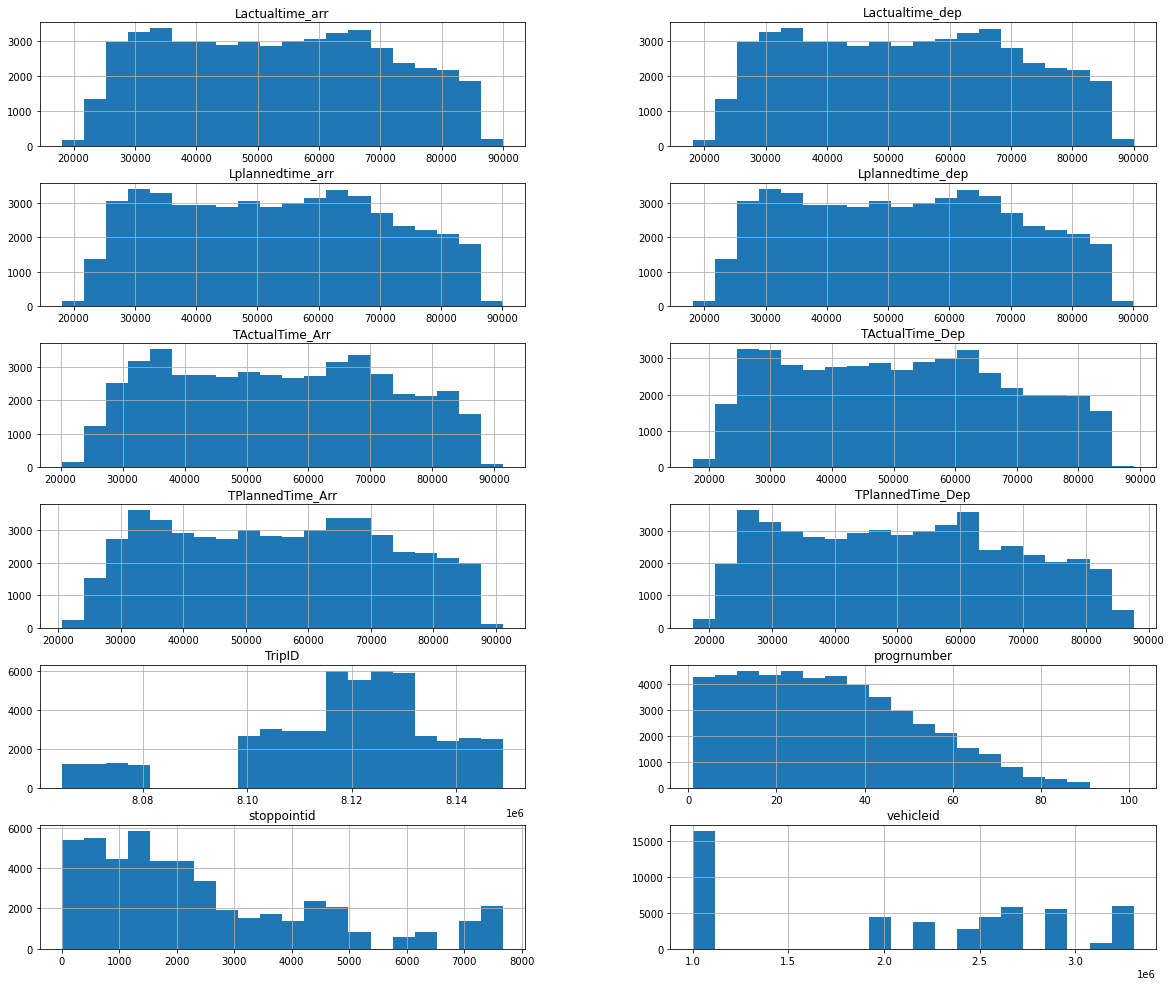

In [24]:
df_sample[continuous_columns].hist(layout=(7, 2), figsize=(20,20), bins=20)
plt.show()

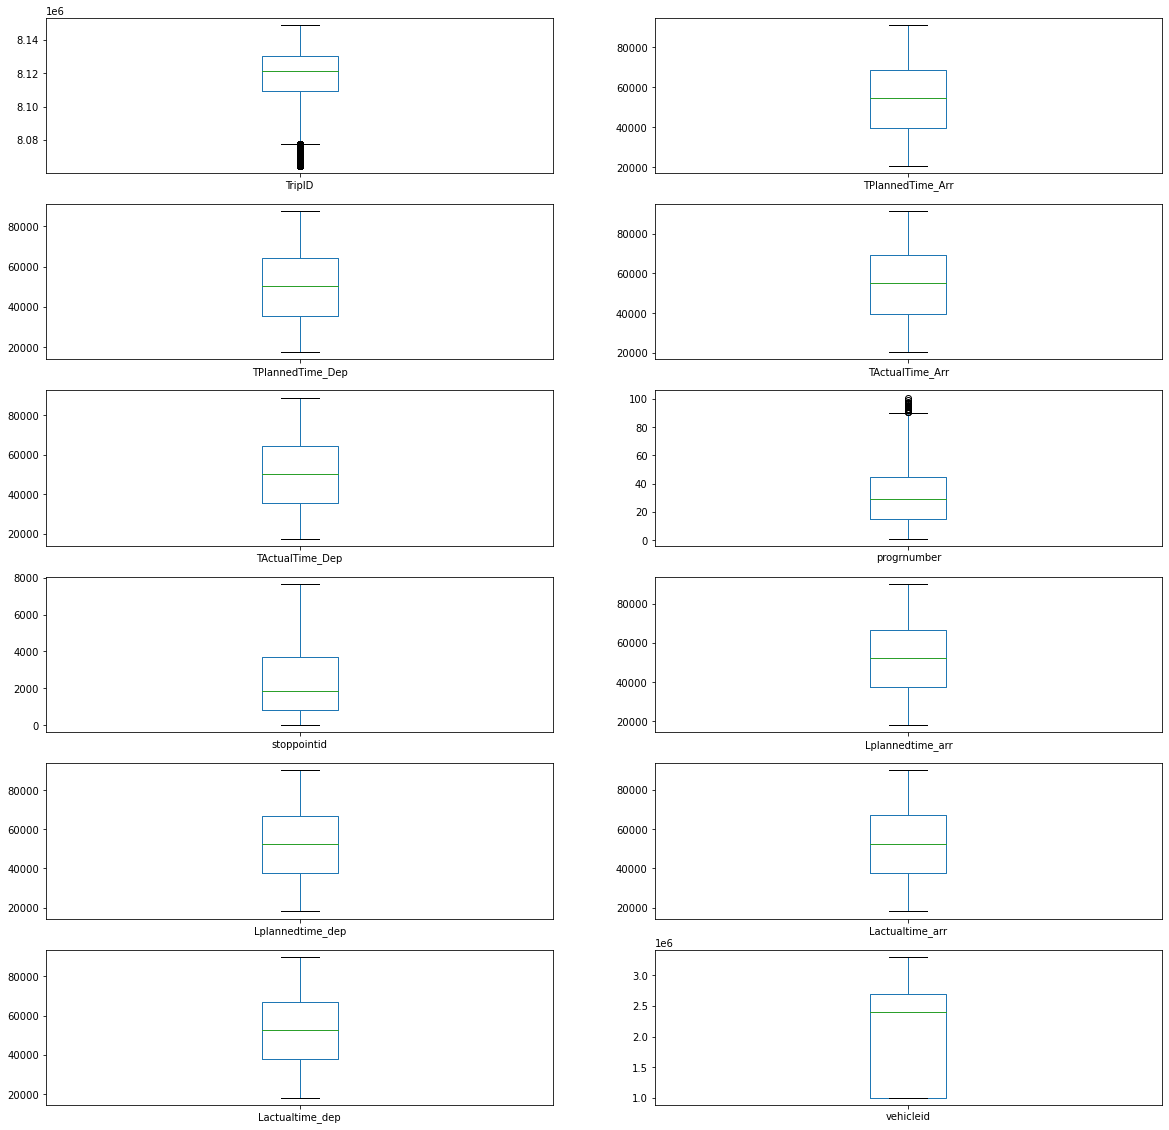

In [25]:
df_sample[continuous_columns].dropna().astype('int64').plot(kind='box', subplots=True, figsize=(20,20), layout=(6,2), sharex=False, sharey=False)
plt.show()

In [26]:
corr = df_sample[continuous_columns].corr()
corr

TripID  TPlannedTime_Arr  TPlannedTime_Dep  \
TripID            1.000000          0.012387          0.007359   
TPlannedTime_Arr  0.012387          1.000000          0.997302   
TPlannedTime_Dep  0.007359          0.997302          1.000000   
TActualTime_Arr   0.010983          0.999324          0.996484   
TActualTime_Dep   0.009235          0.997198          0.999906   
progrnumber      -0.004333          0.017812         -0.006334   
stoppointid      -0.008858         -0.002973         -0.002739   
Lplannedtime_arr  0.009505          0.996592          0.996533   
Lplannedtime_dep  0.009505          0.996592          0.996533   
Lactualtime_arr   0.008572          0.996058          0.995918   
Lactualtime_dep   0.008580          0.996062          0.995912   
vehicleid        -0.009730          0.080181          0.070031   

                  TActualTime_Arr  TActualTime_Dep  progrnumber  stoppointid  \
TripID                   0.010983         0.009235    -0.004333    -0.008858   
TPlannedTime_Arr         0.999324         0.997198     0.017812    -0.002973   
TPlannedTime_Dep         0.996484         0.999906    -0.006334    -0.002739   
TActualTime_Arr          1.000000         0.996505     0.021681    -0.004110   
TActualTime_Dep          0.996505         1.000000    -0.008436    -0.001291   
progrnumber              0.021681        -0.008436     1.000000     0.002104   
stoppointid             -0.004110        -0.001291     0.002104     1.000000   
Lplannedtime_arr         0.995829         0.996446     0.070536    -0.002019   
Lplannedtime_dep         0.995829         0.996446     0.070536    -0.002019   
Lactualtime_arr          0.995931         0.995981     0.074225    -0.001641   
Lactualtime_dep          0.995941         0.995975     0.074213    -0.001712   
vehicleid                0.077141         0.067967     0.073785     0.026118   

                  Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  \
TripID                    0.009505          0.009505         0.008572   
TPlannedTime_Arr          0.996592          0.996592         0.996058   
TPlannedTime_Dep          0.996533          0.996533         0.995918   
TActualTime_Arr           0.995829          0.995829         0.995931   
TActualTime_Dep           0.996446          0.996446         0.995981   
progrnumber               0.070536          0.070536         0.074225   
stoppointid              -0.002019         -0.002019        -0.001641   
Lplannedtime_arr          1.000000          1.000000         0.999689   
Lplannedtime_dep          1.000000          1.000000         0.999689   
Lactualtime_arr           0.999689          0.999689         1.000000   
Lactualtime_dep           0.999686          0.999686         0.999998   
vehicleid                 0.074953          0.074953         0.074656   

                  Lactualtime_dep  vehicleid  
TripID                   0.008580  -0.009730  
TPlannedTime_Arr         0.996062   0.080181  
TPlannedTime_Dep         0.995912   0.070031  
TActualTime_Arr          0.995941   0.077141  
TActualTime_Dep          0.995975   0.067967  
progrnumber              0.074213   0.073785  
stoppointid             -0.001712   0.026118  
Lplannedtime_arr         0.999686   0.074953  
Lplannedtime_dep         0.999686   0.074953  
Lactualtime_arr          0.999998   0.074656  
Lactualtime_dep          1.000000   0.074655  
vehicleid                0.074655   1.000000

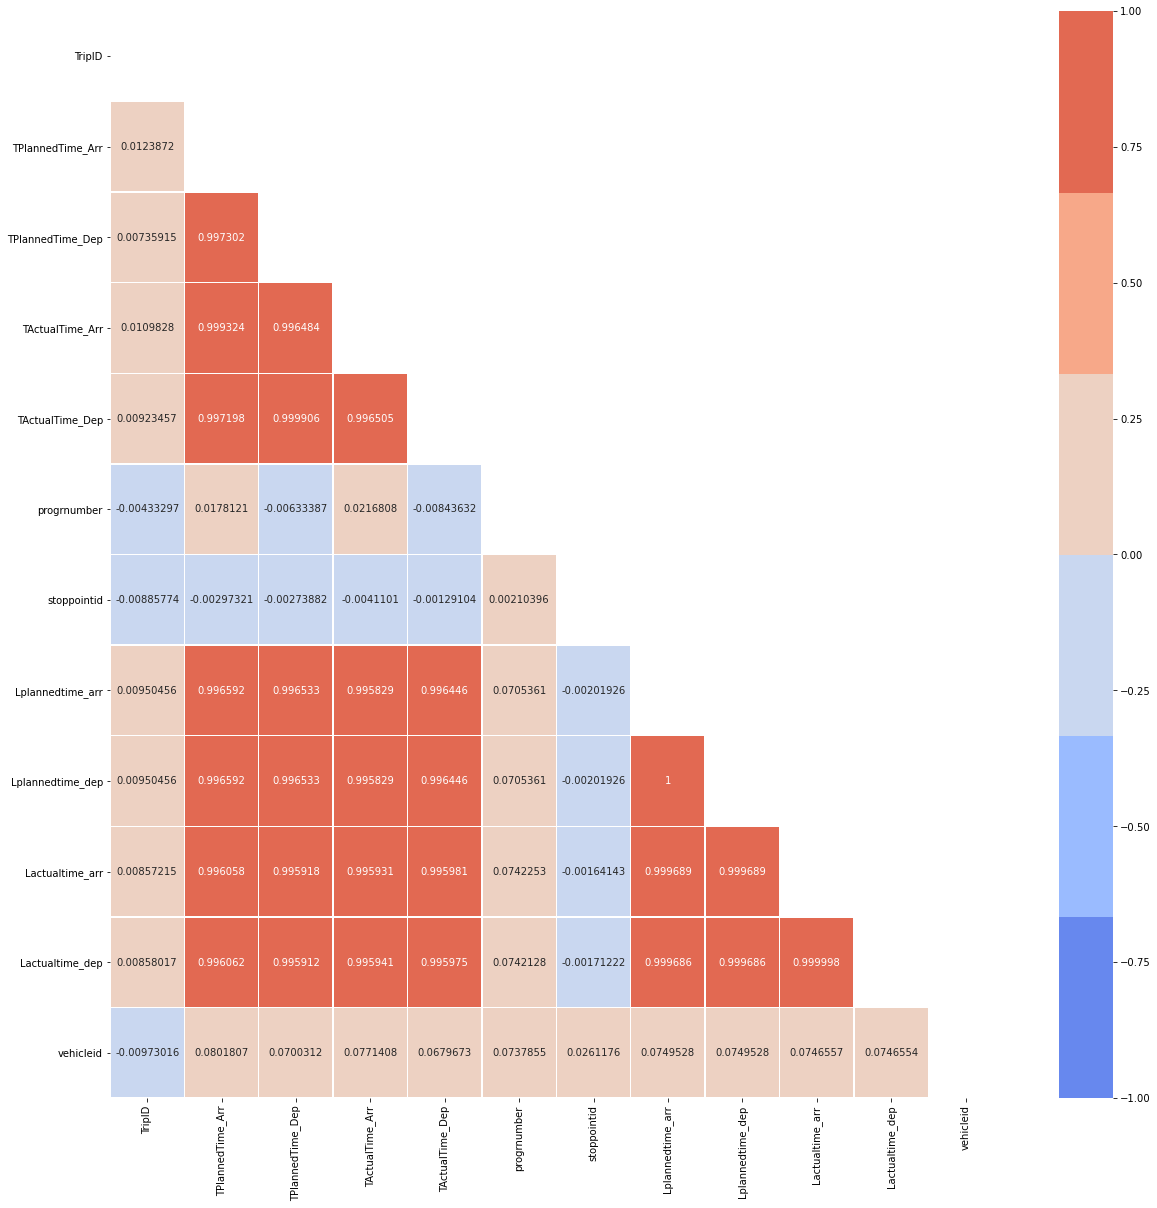

In [27]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (20,20))
color = sns.color_palette("coolwarm")
sns.heatmap(corr, cmap=color, annot=True, fmt='g', vmax=1, vmin=-1,linewidths=.5, mask=mask)

C:\Users\frank\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


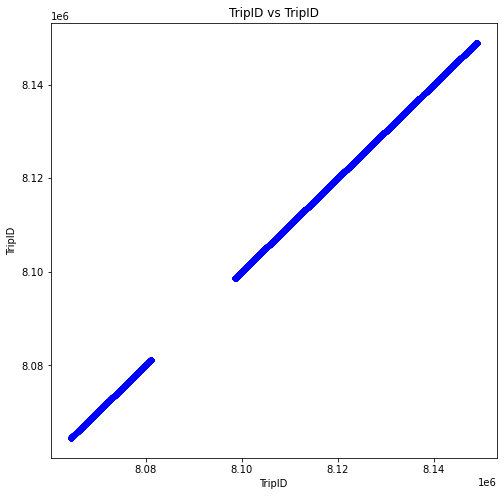

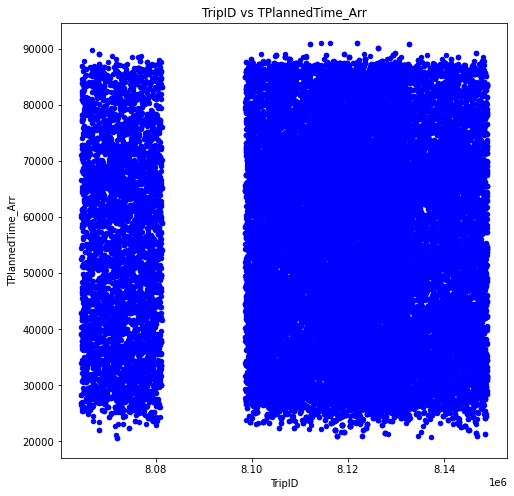

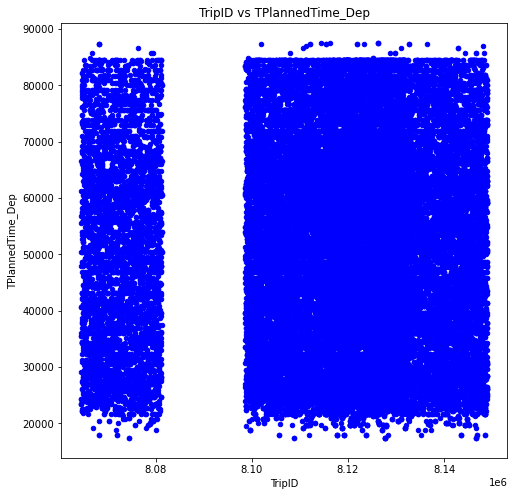

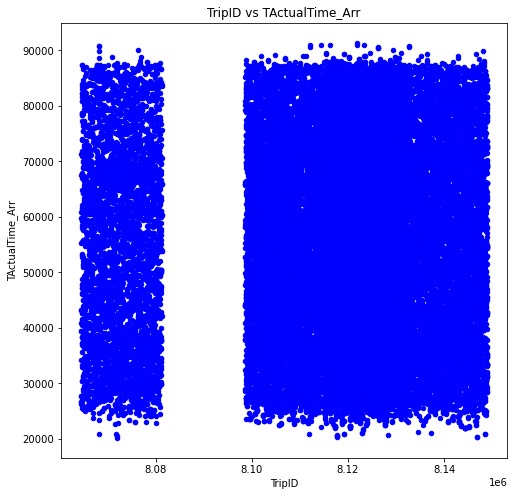

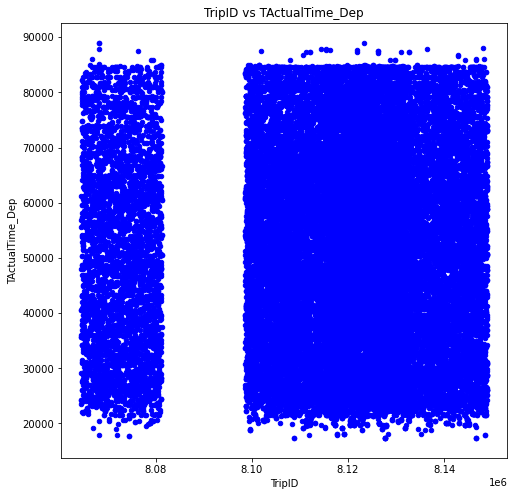

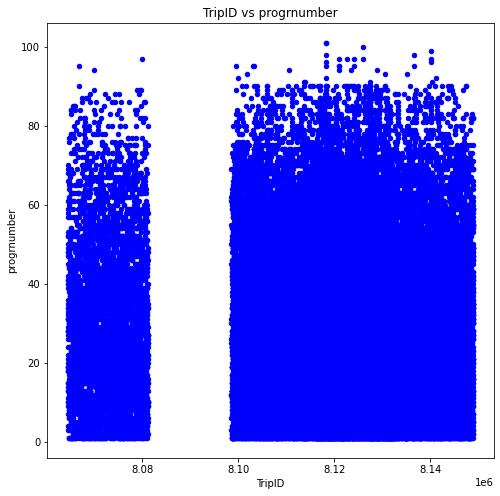

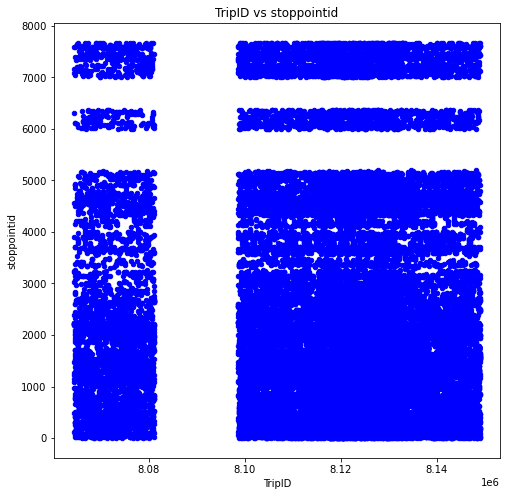

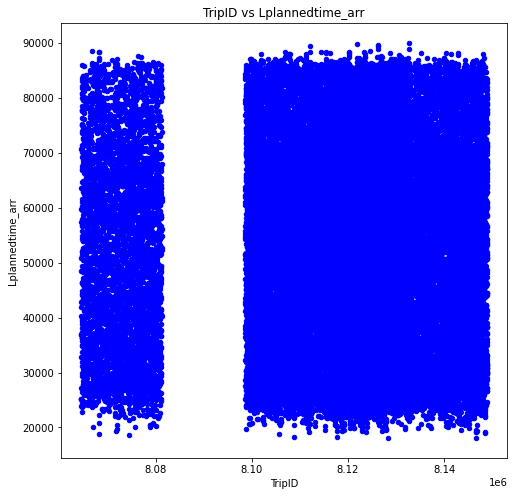

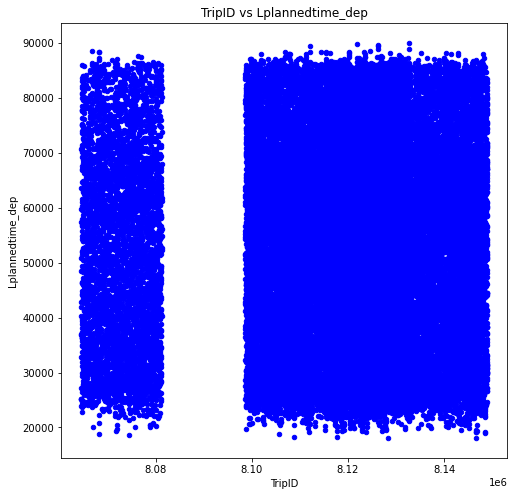

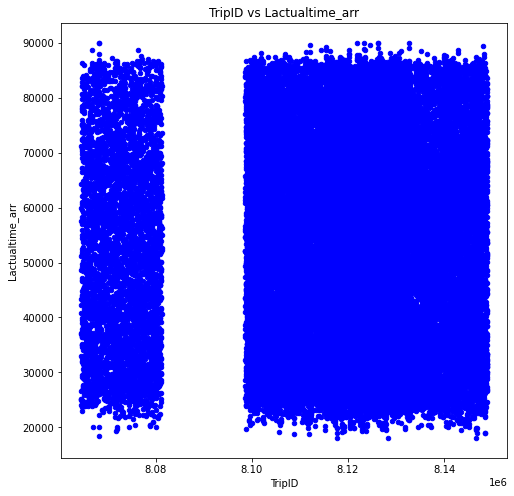

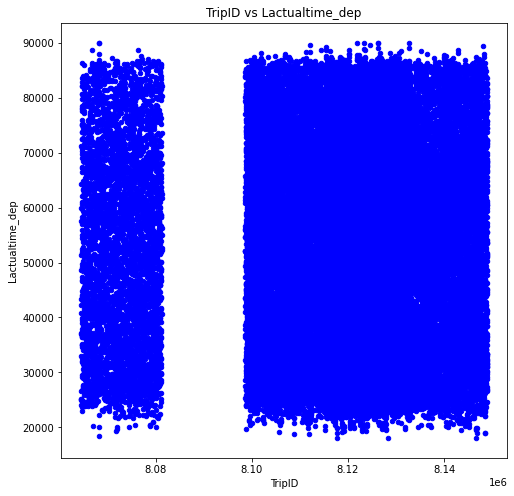

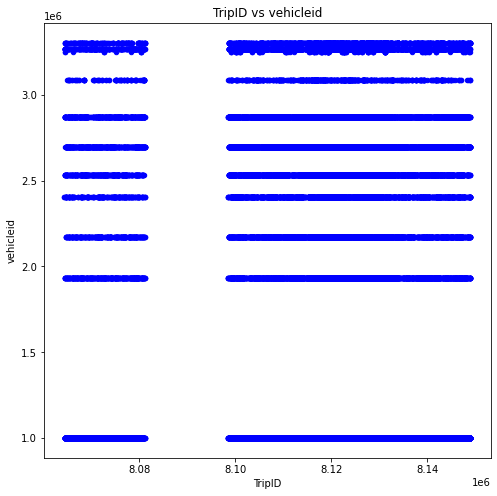

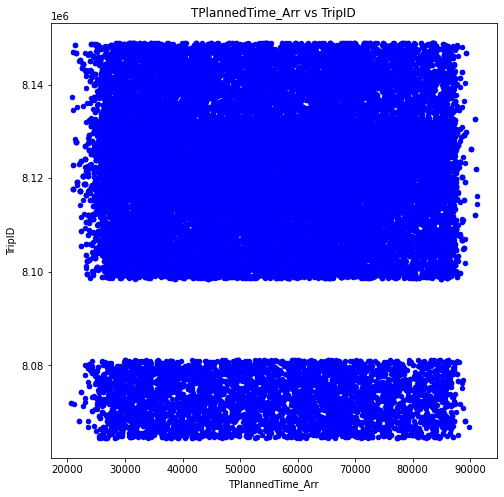

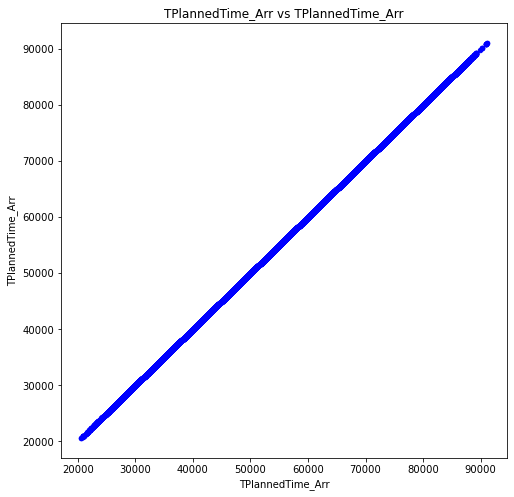

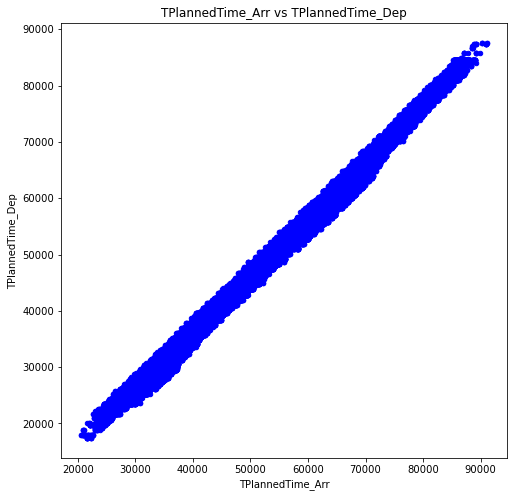

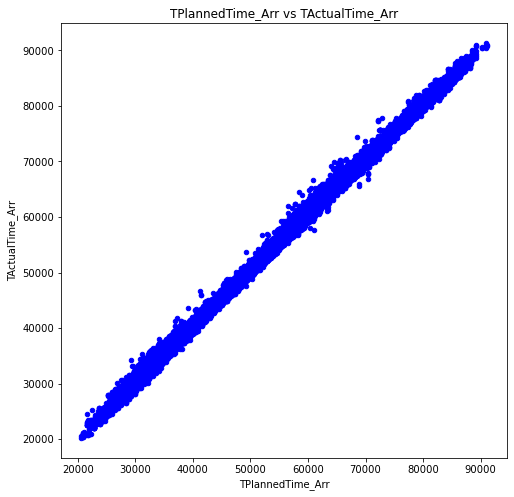

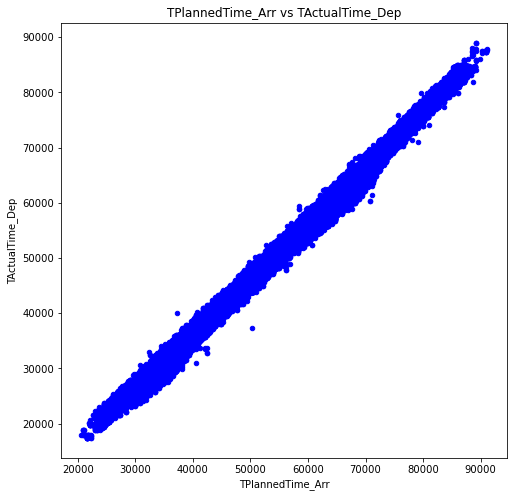

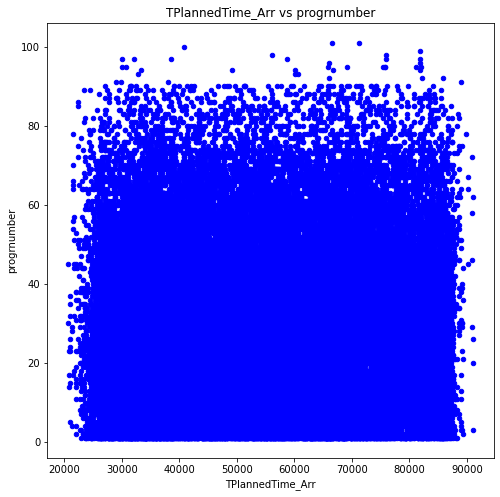

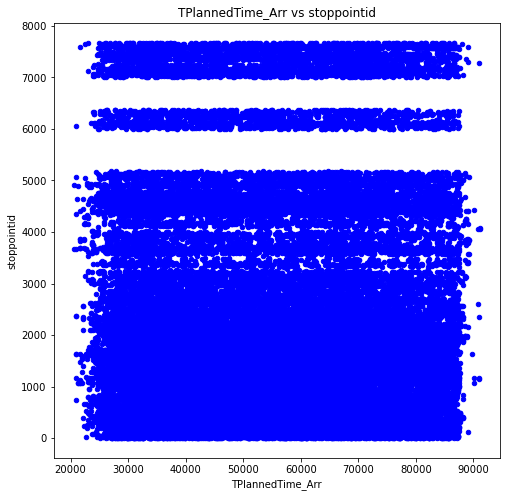

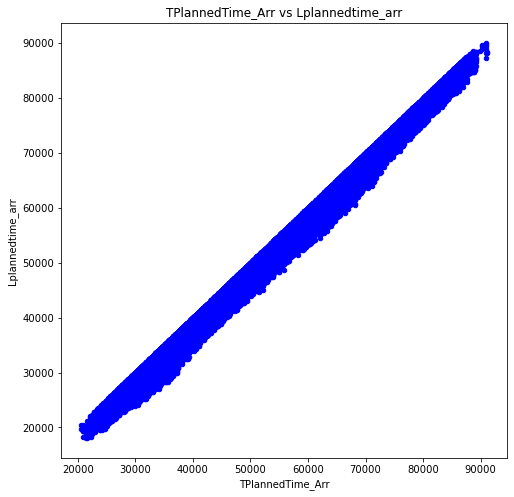

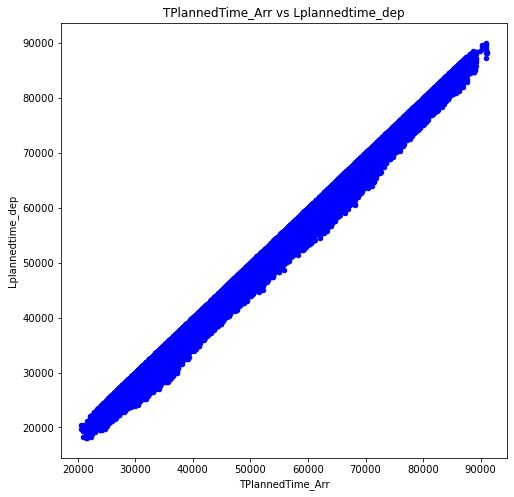

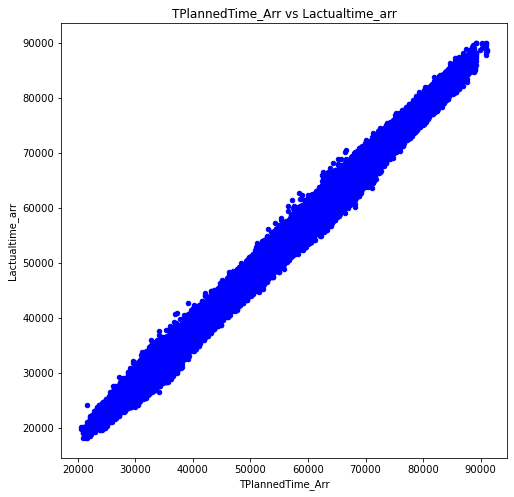

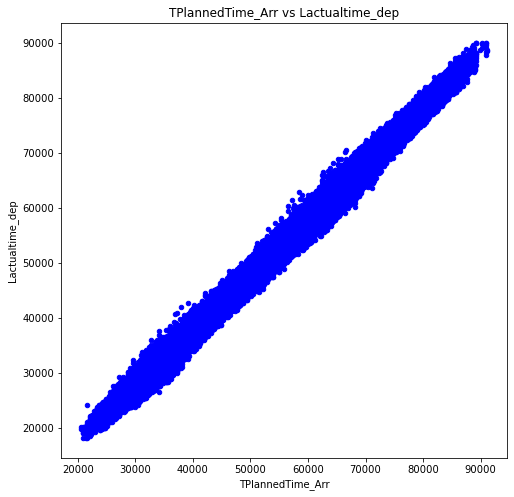

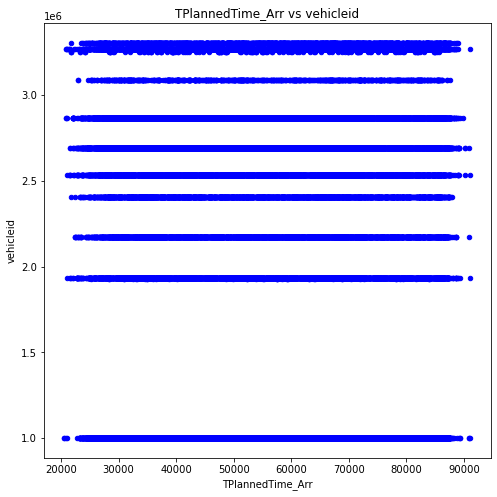

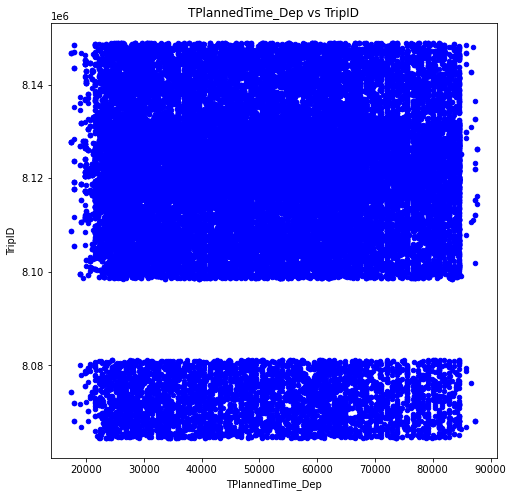

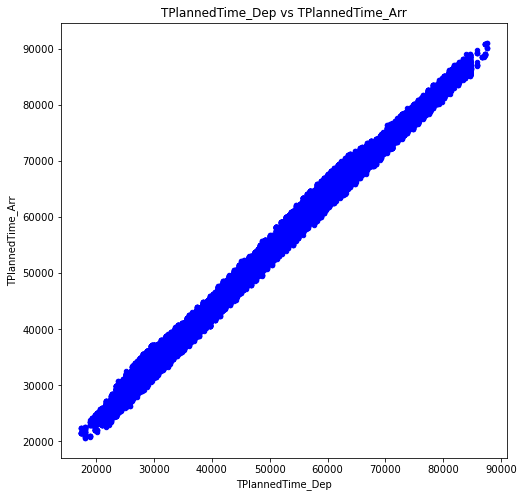

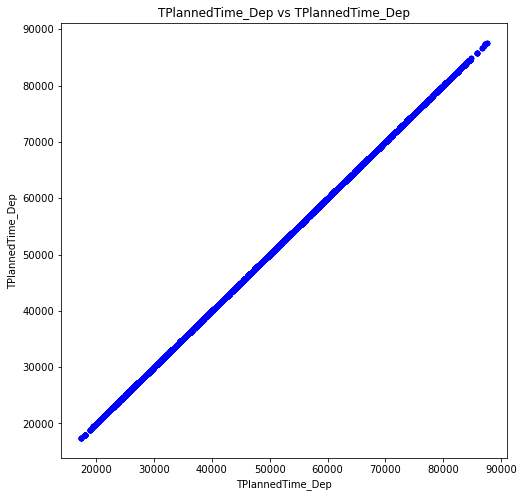

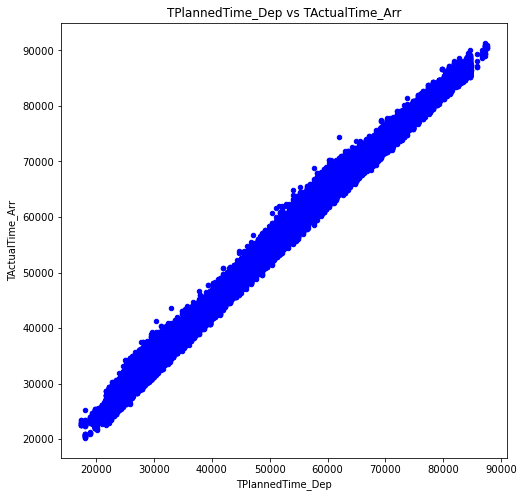

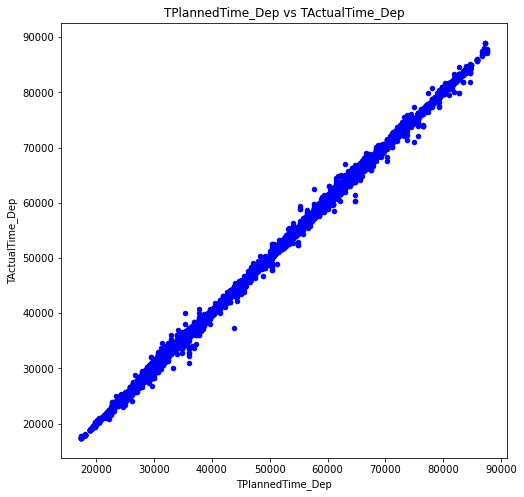

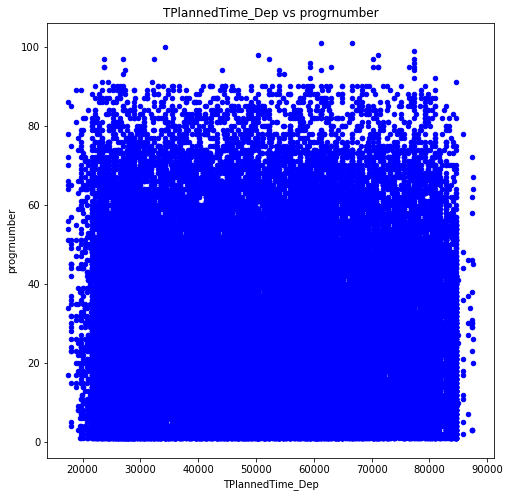

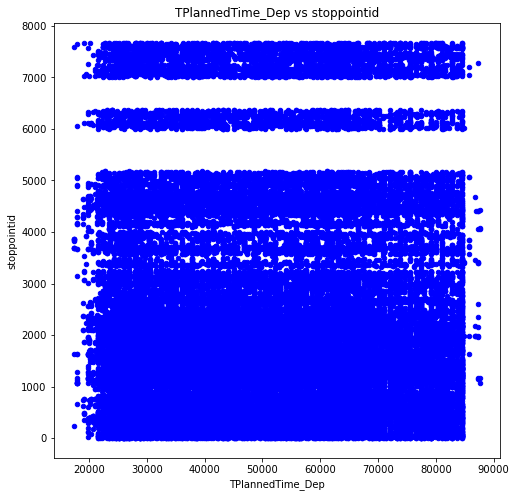

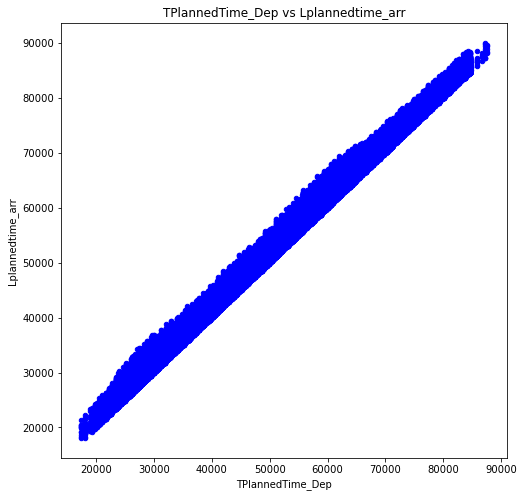

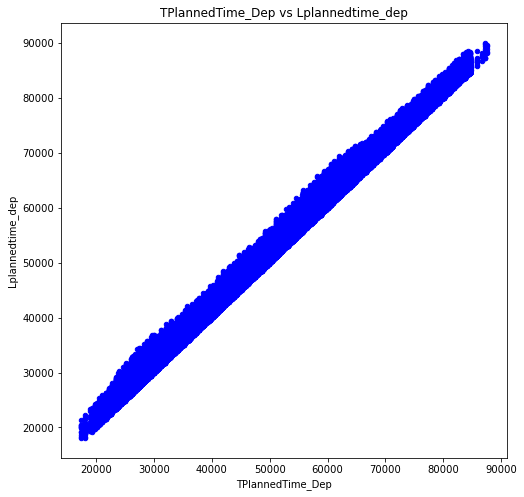

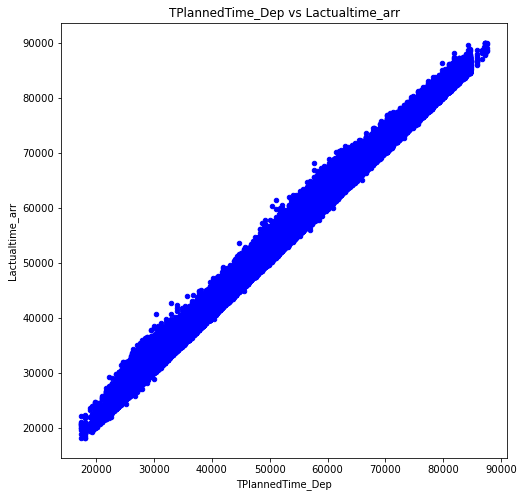

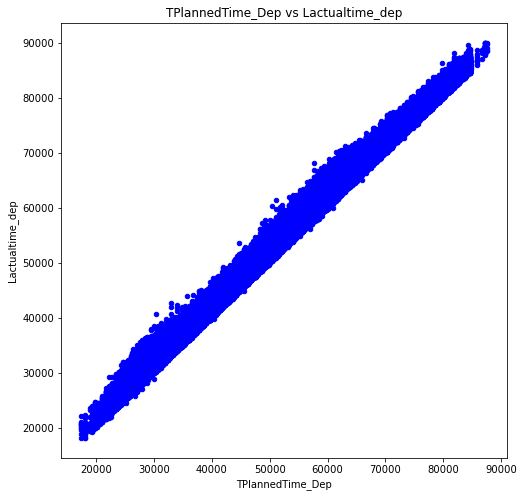

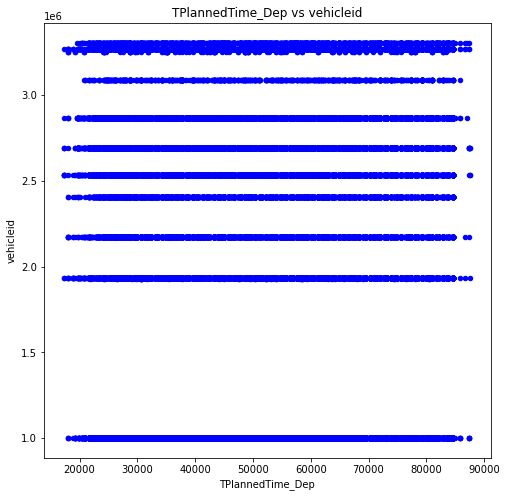

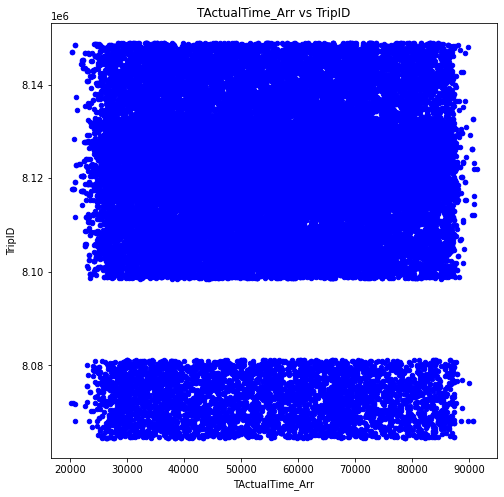

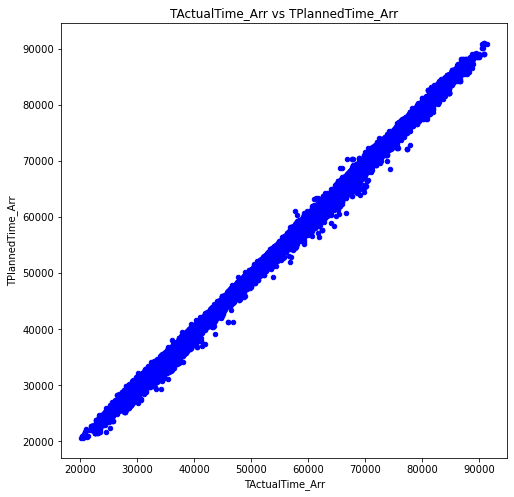

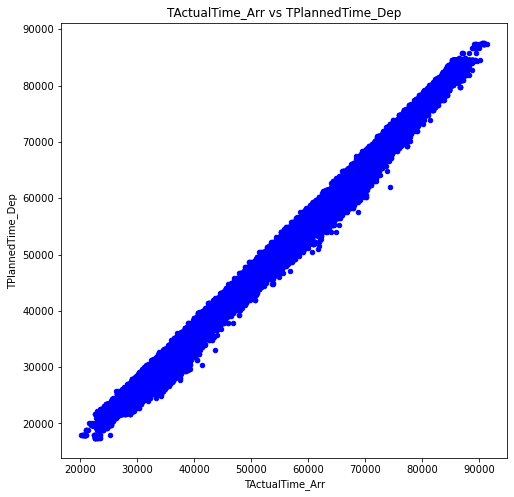

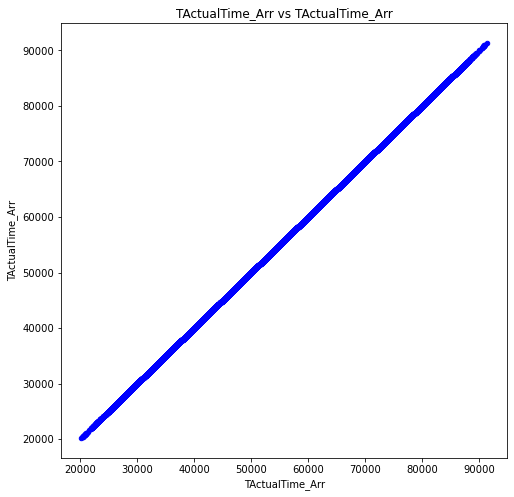

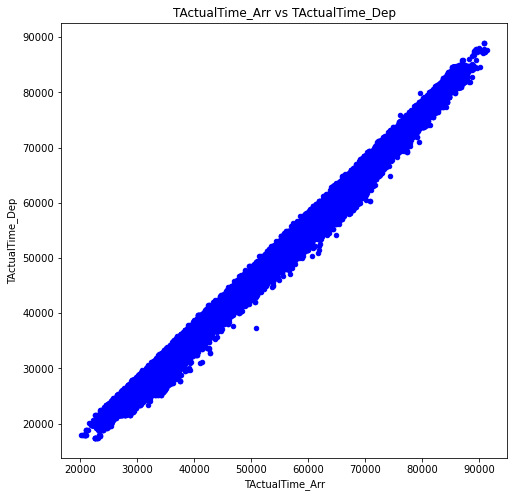

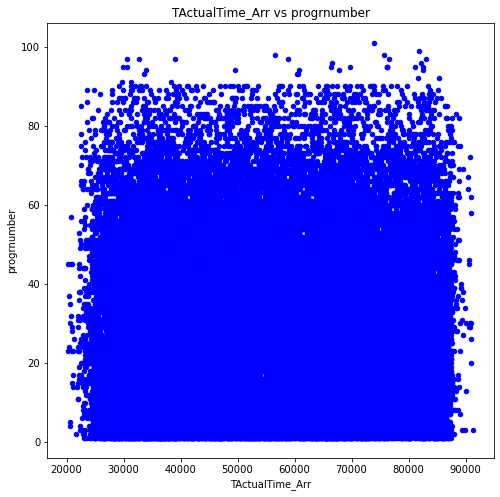

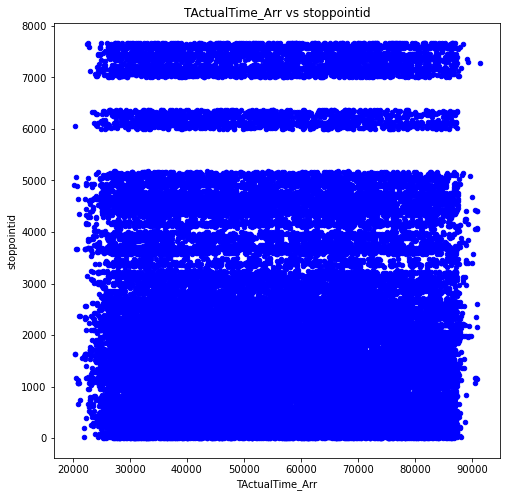

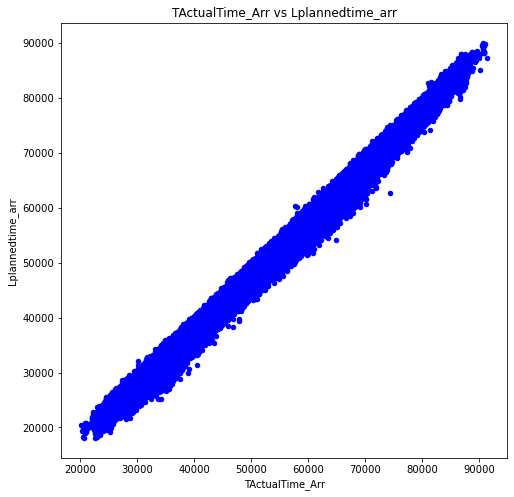

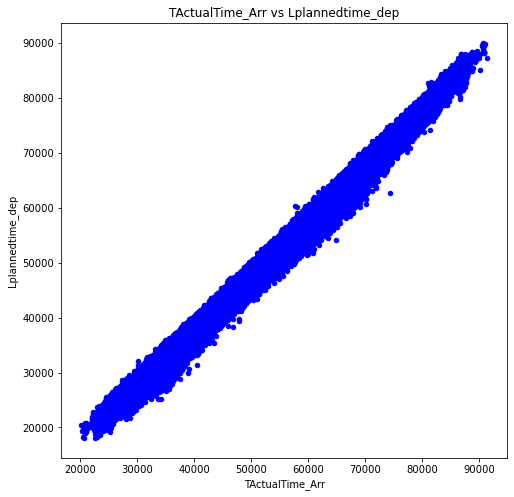

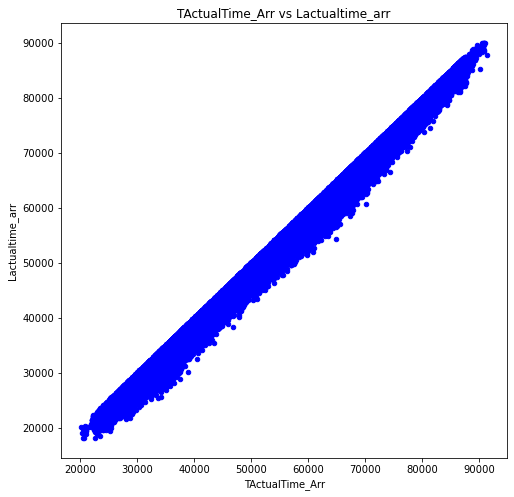

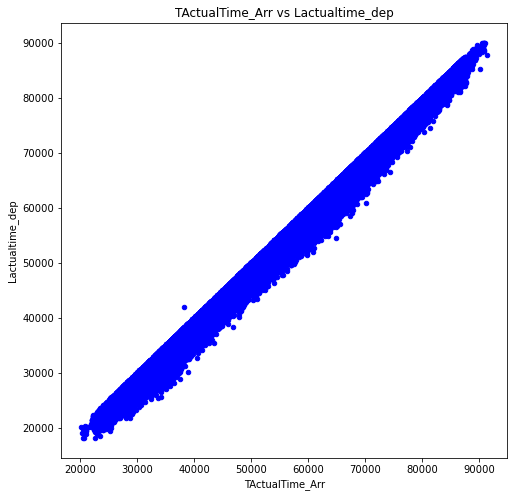

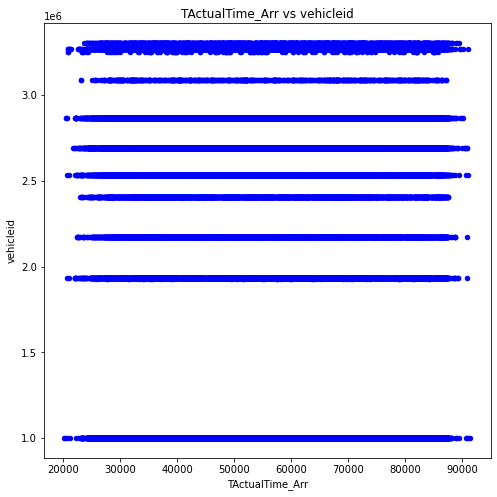

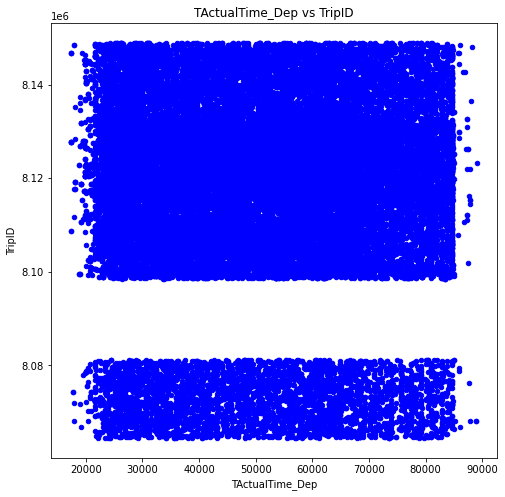

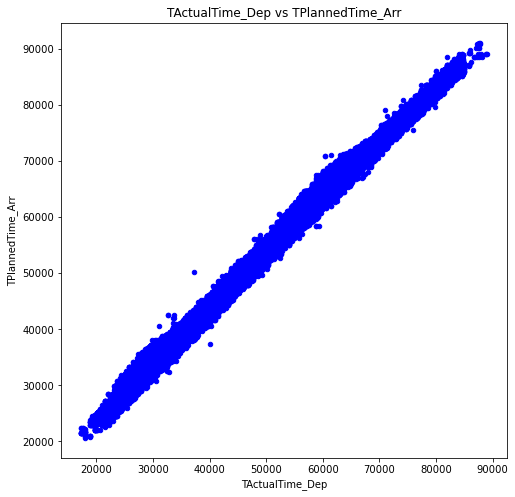

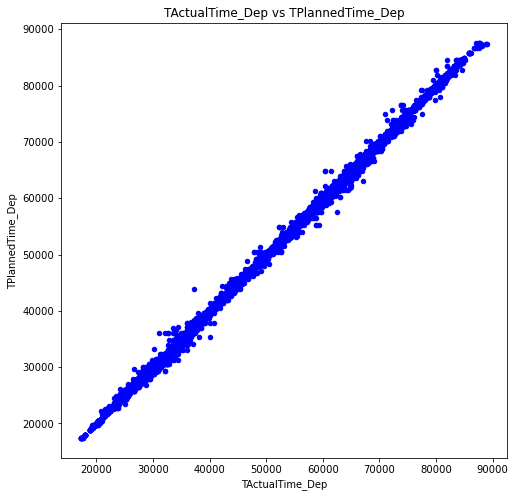

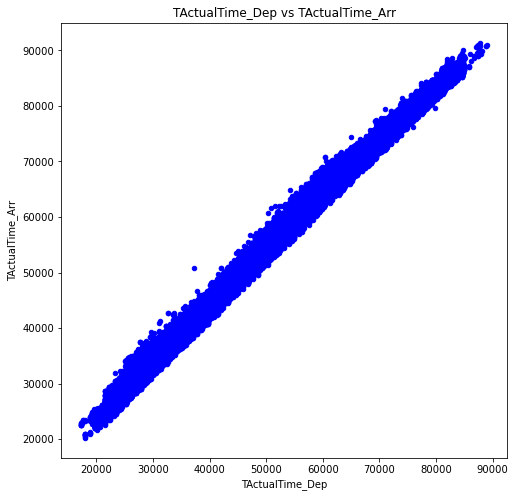

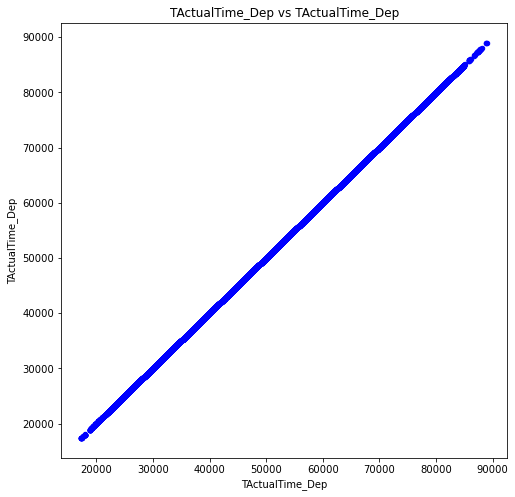

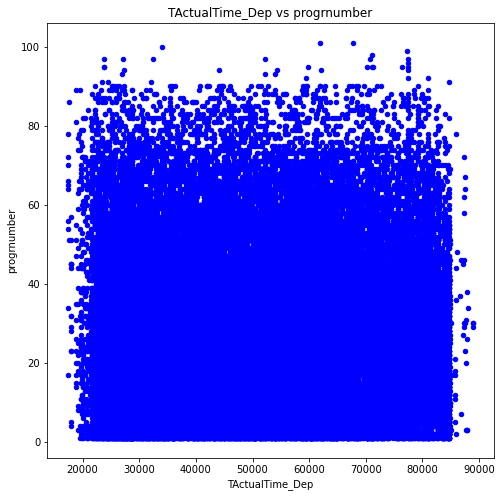

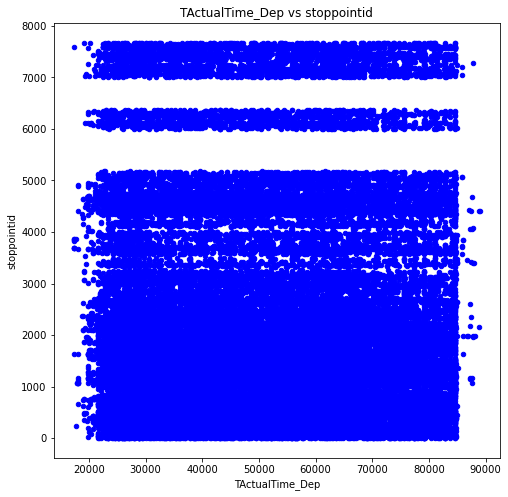

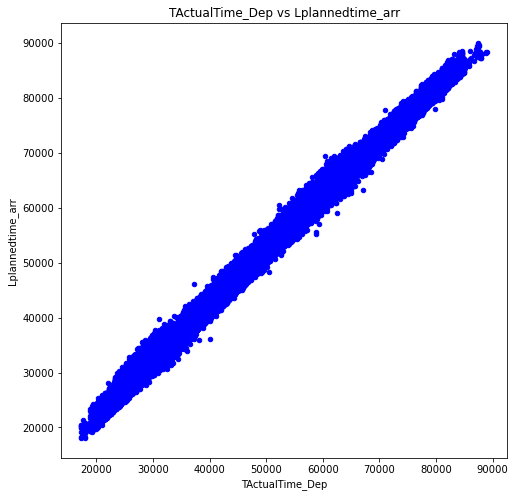

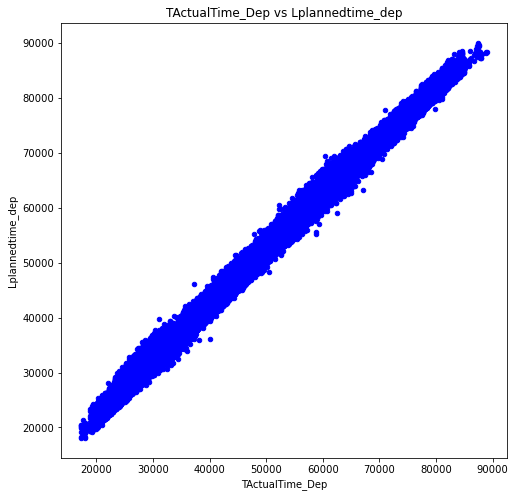

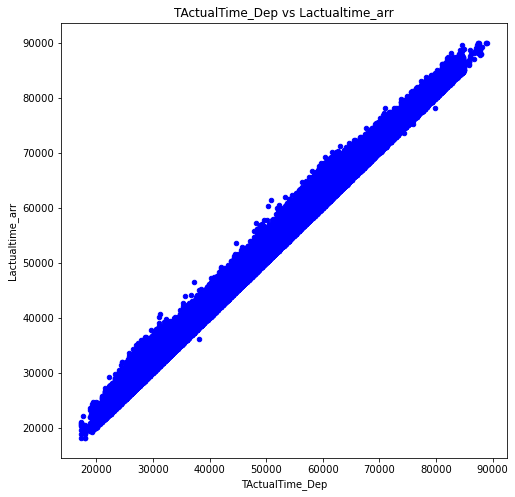

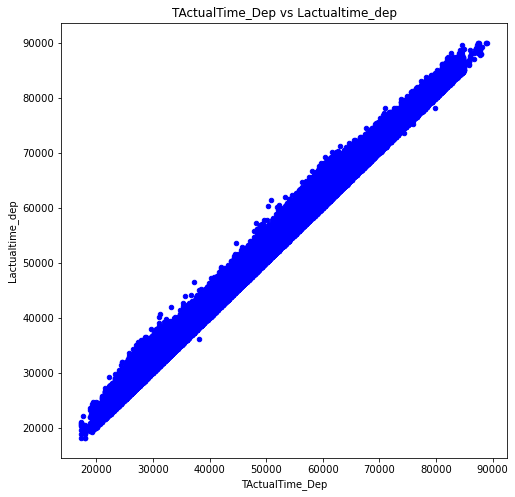

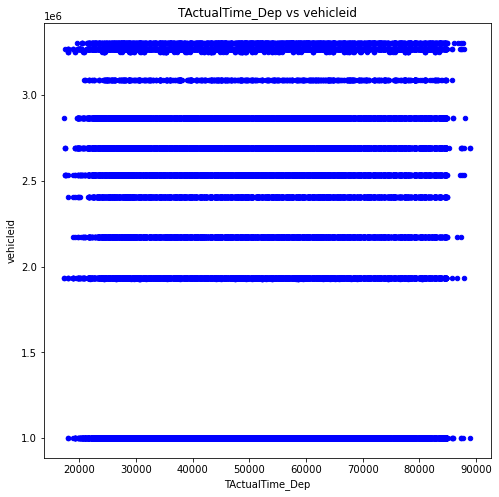

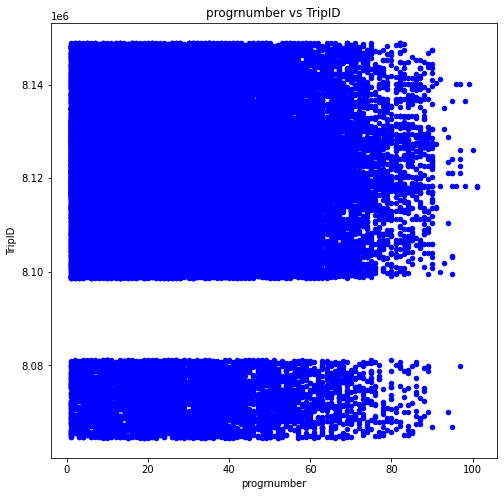

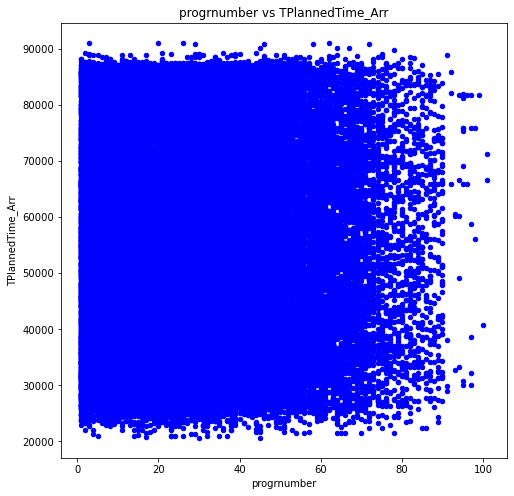

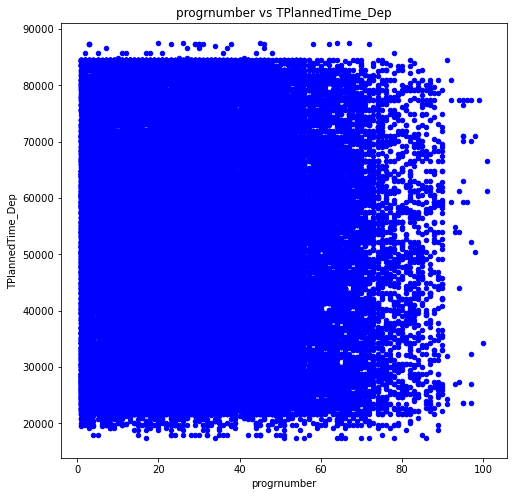

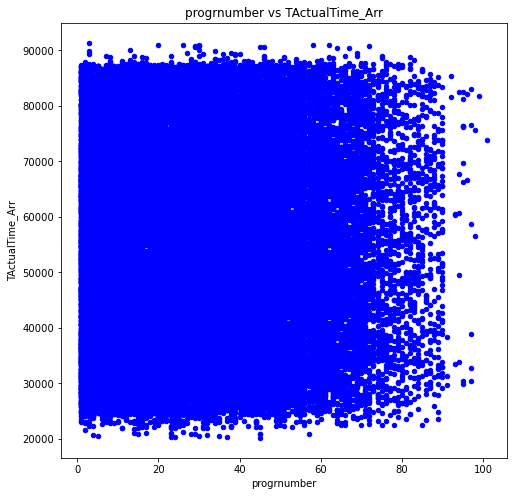

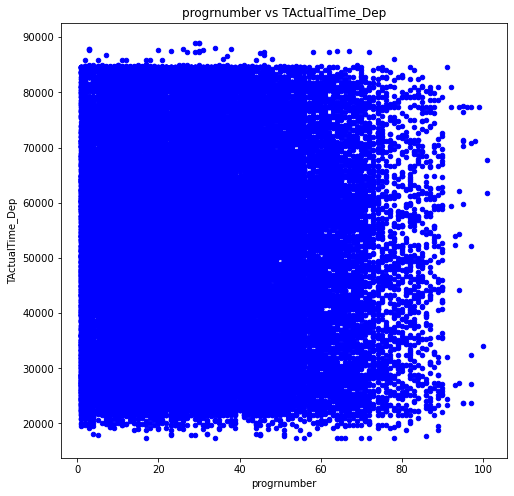

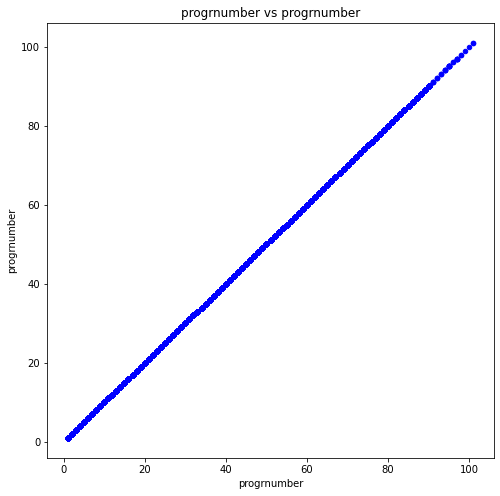

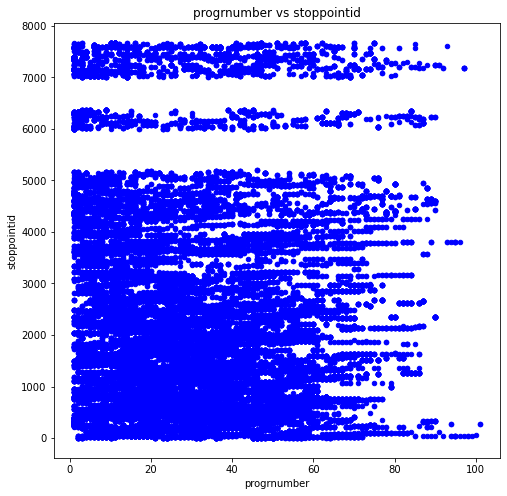

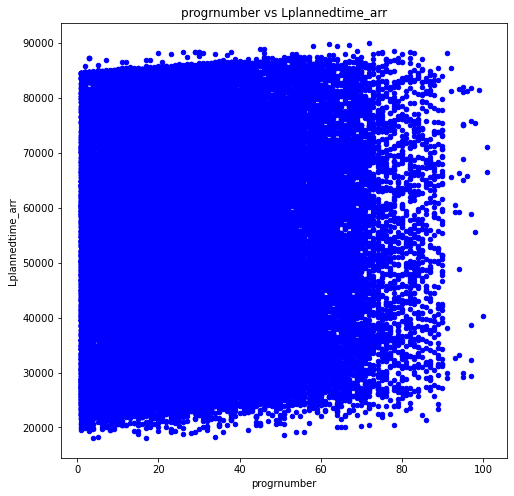

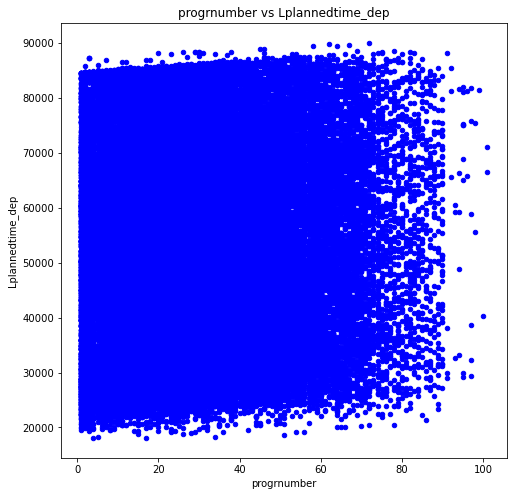

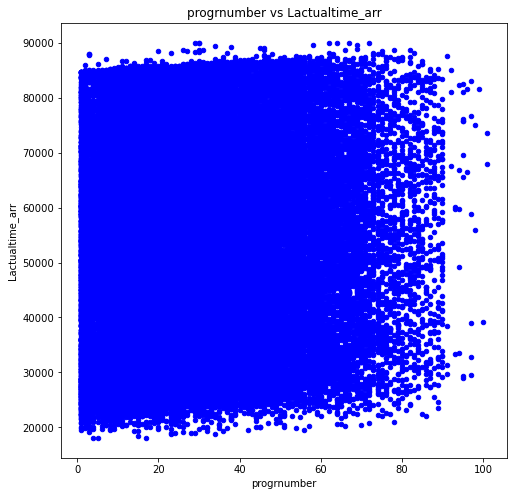

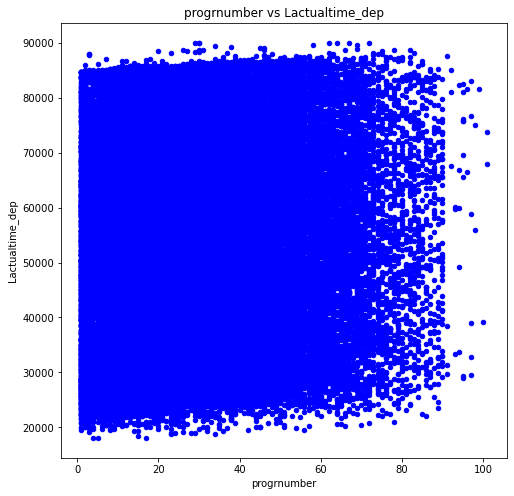

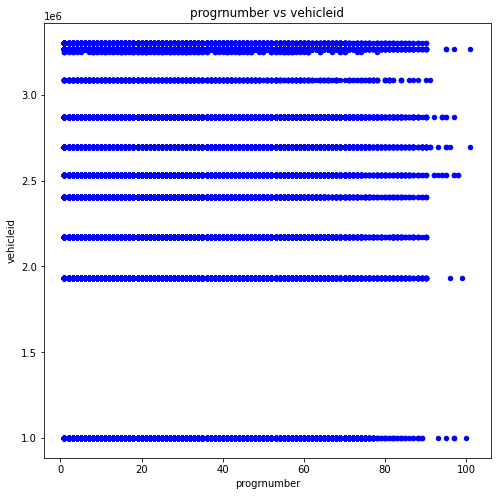

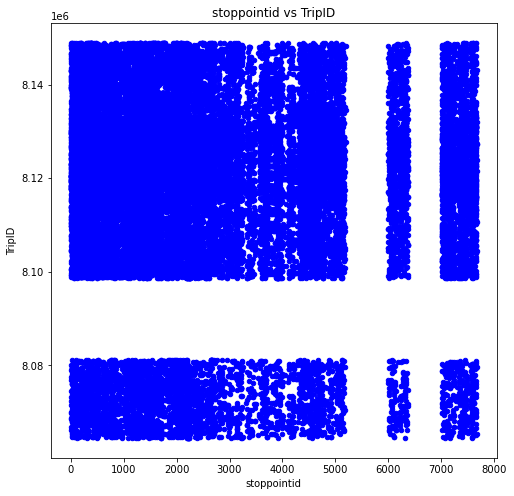

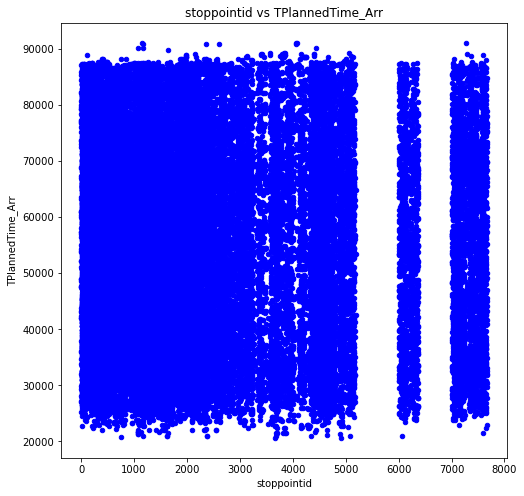

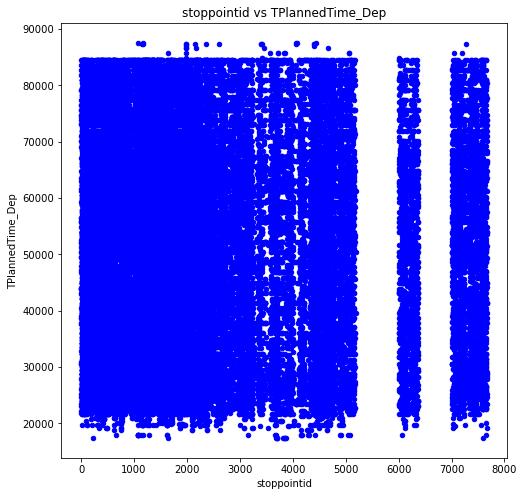

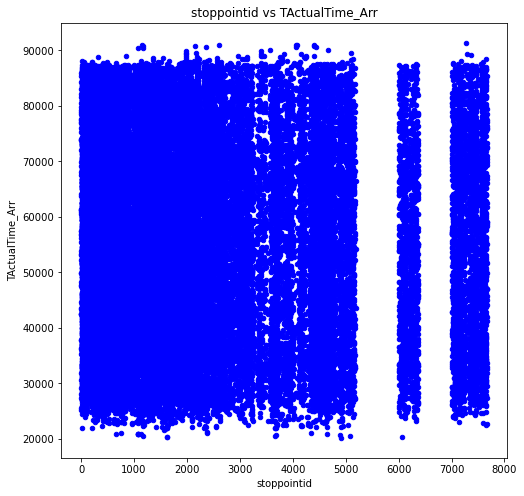

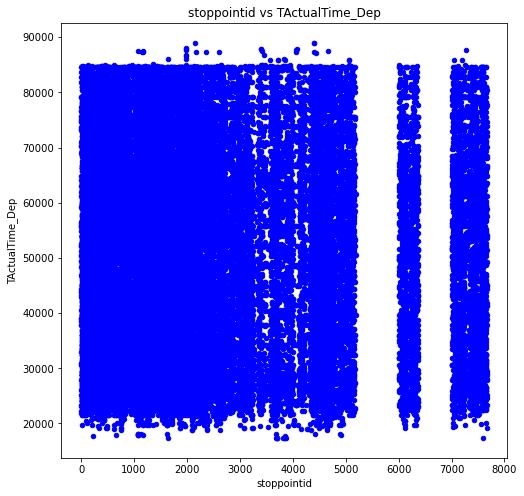

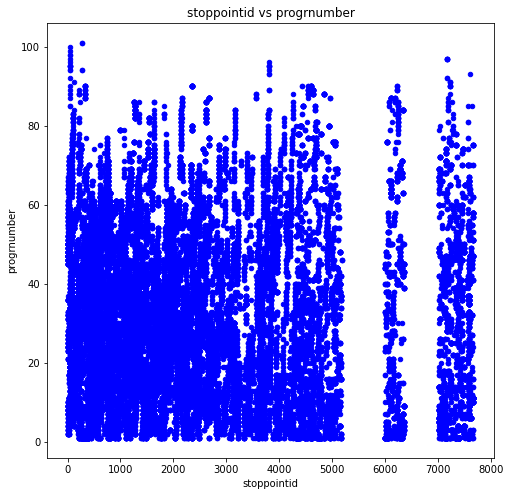

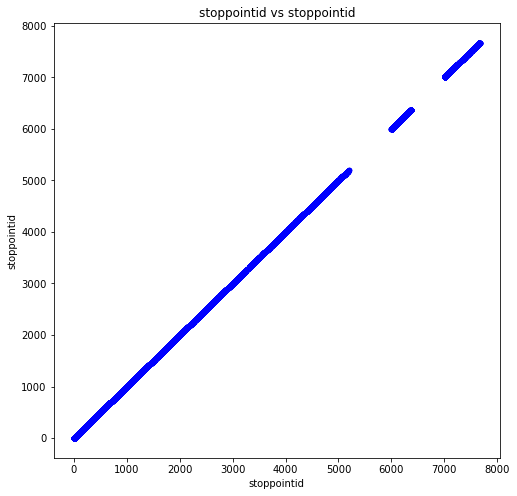

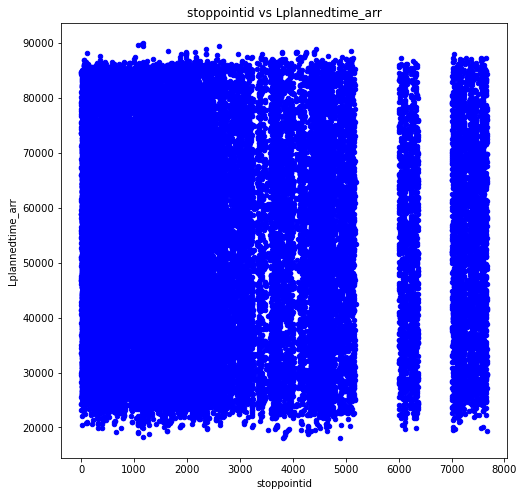

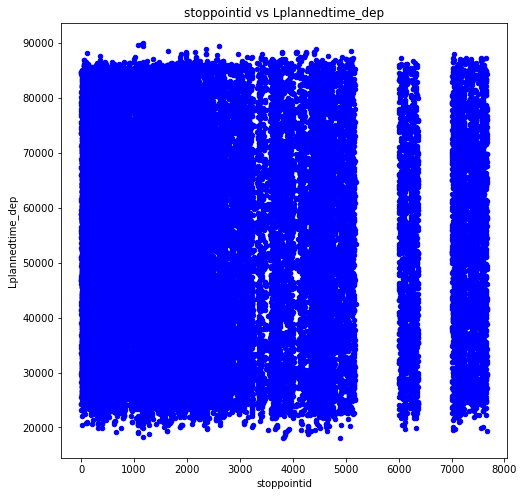

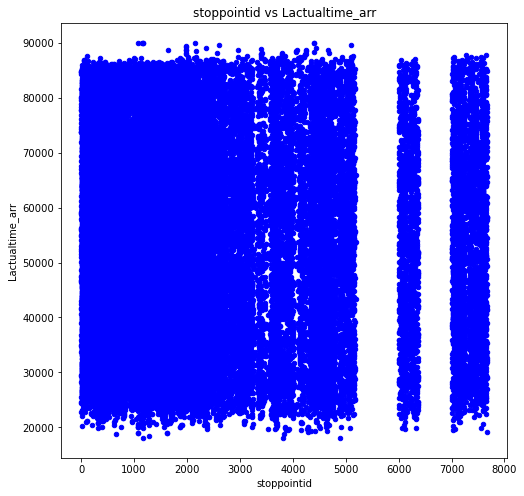

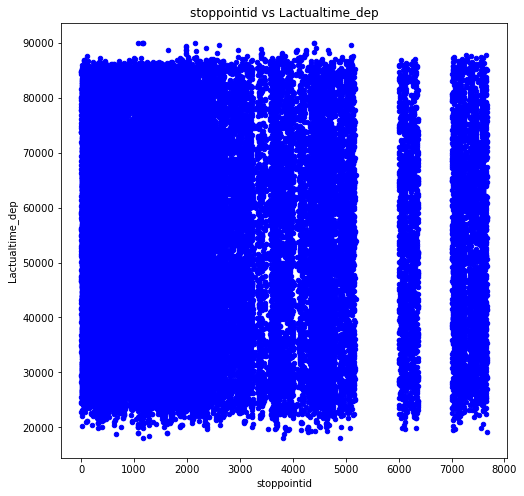

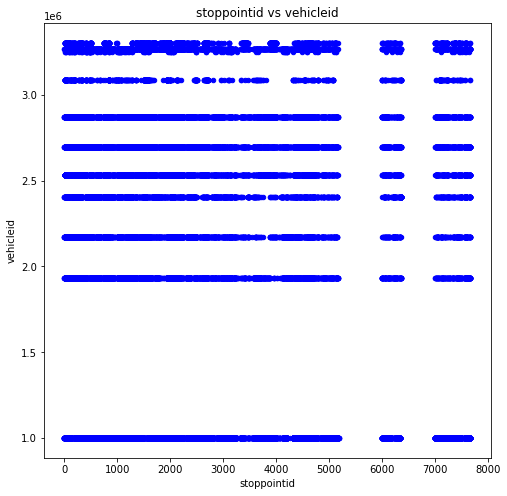

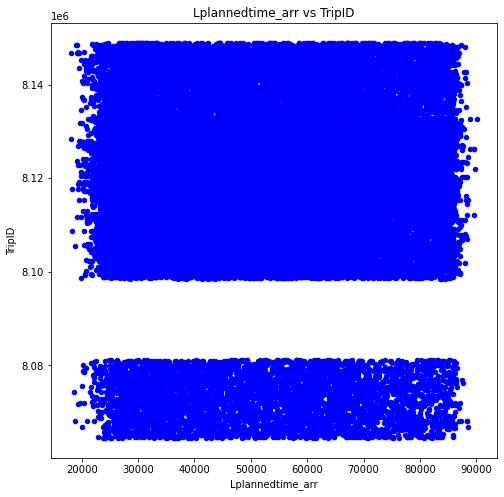

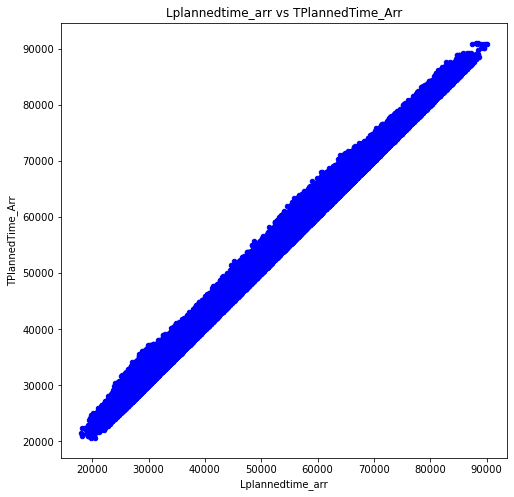

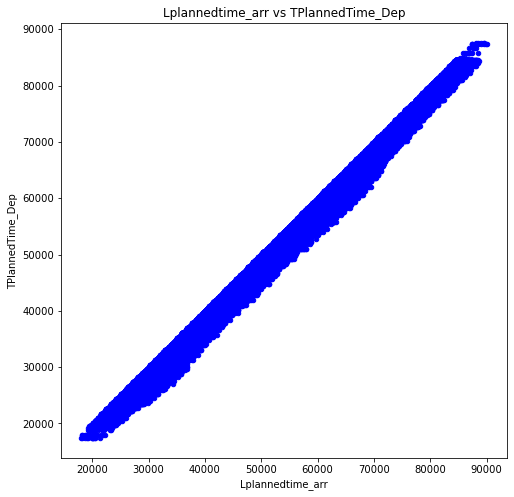

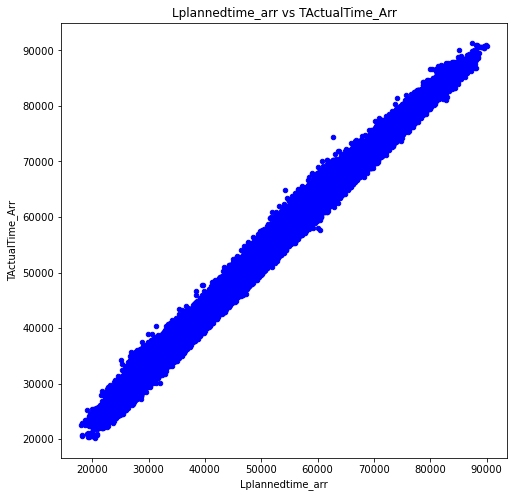

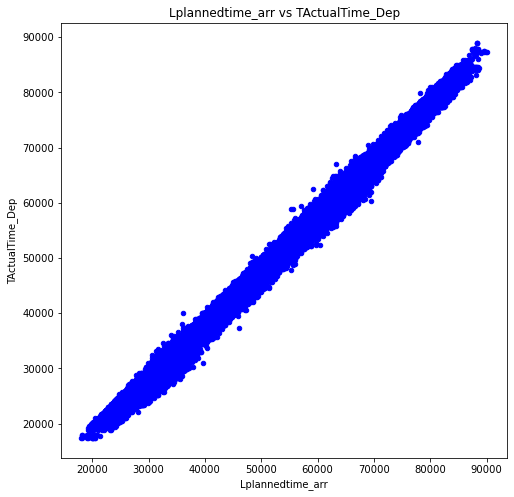

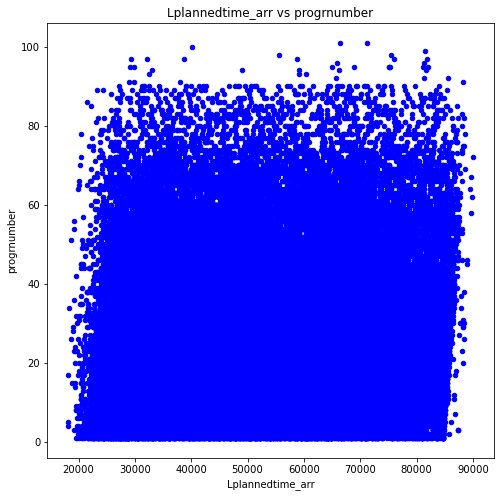

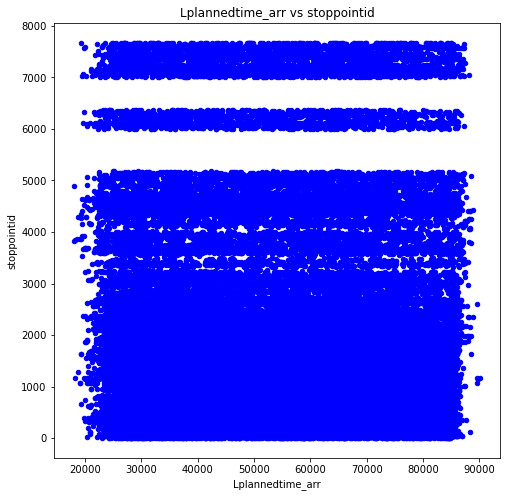

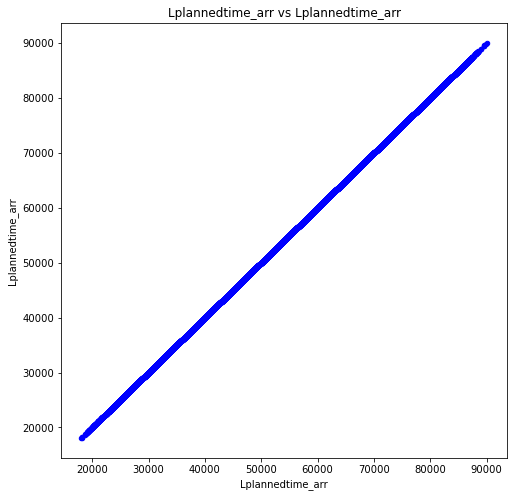

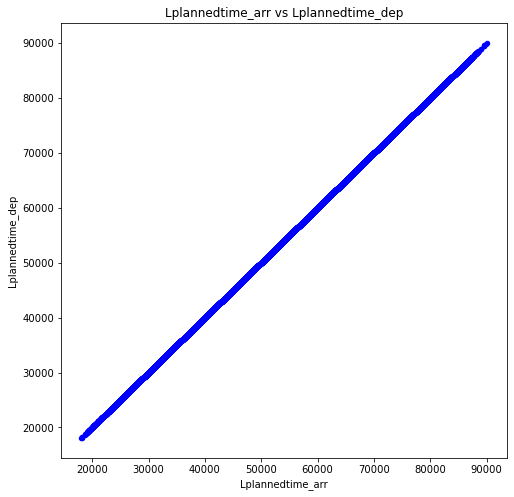

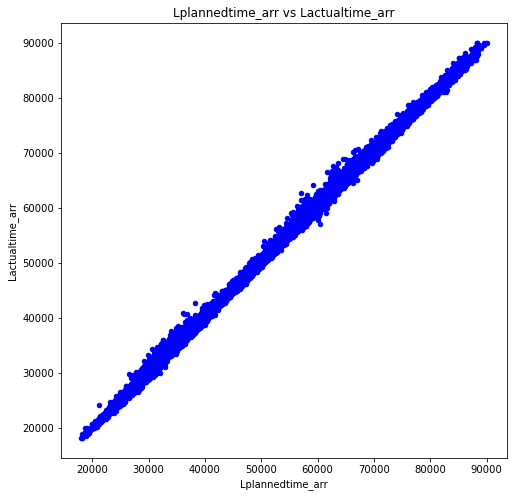

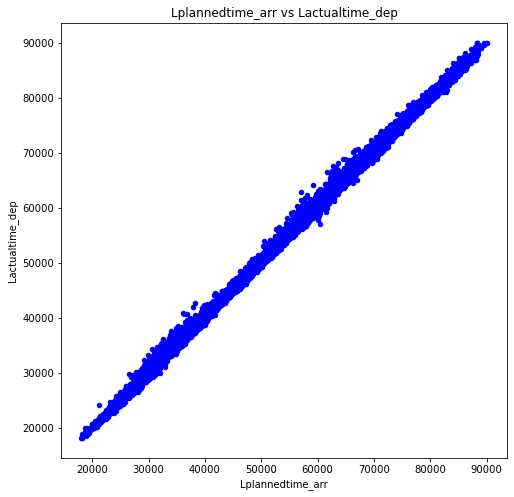

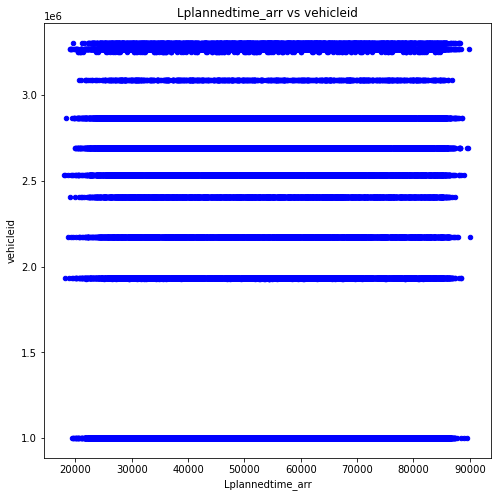

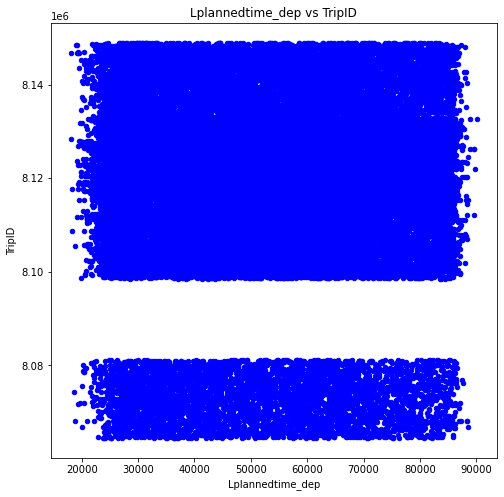

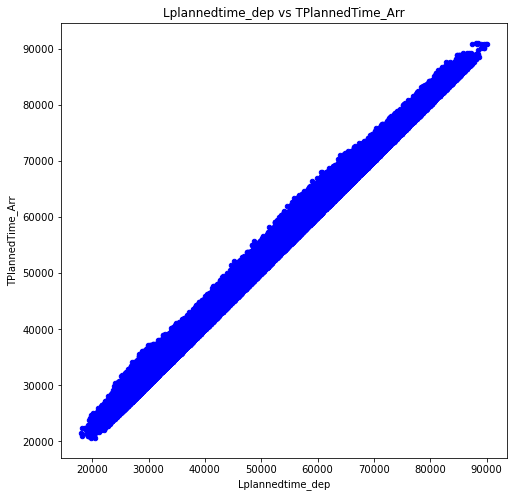

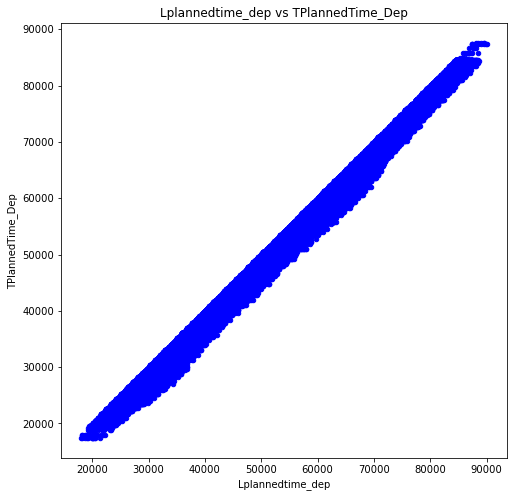

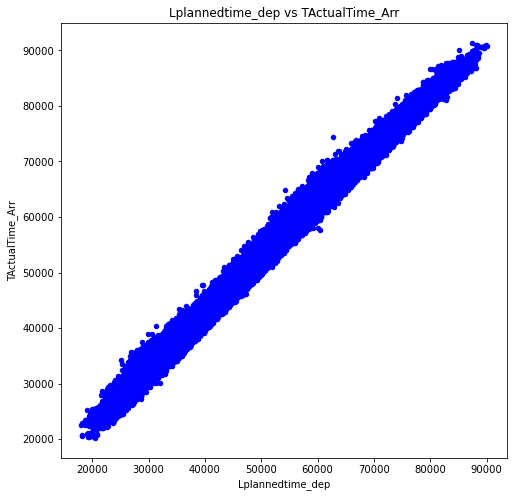

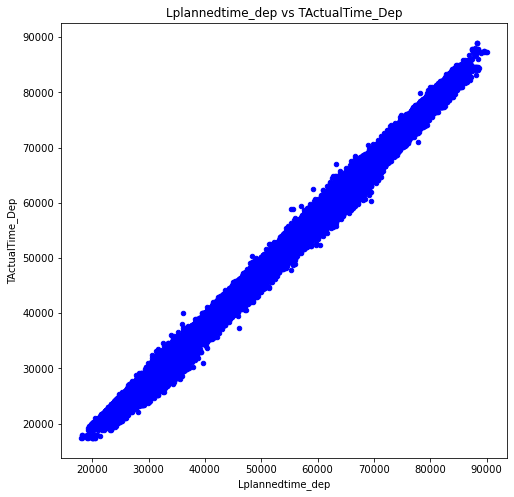

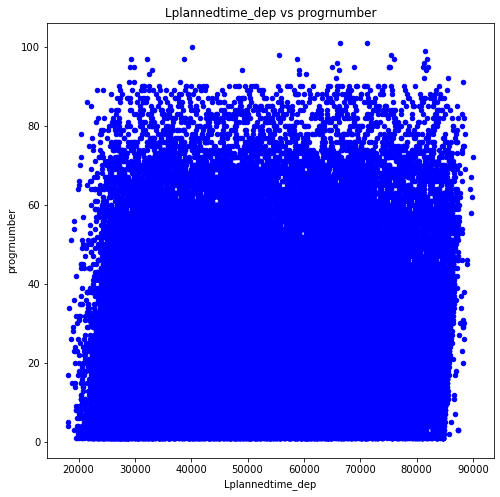

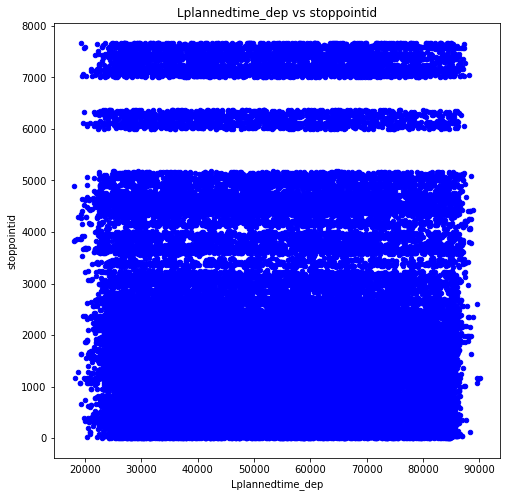

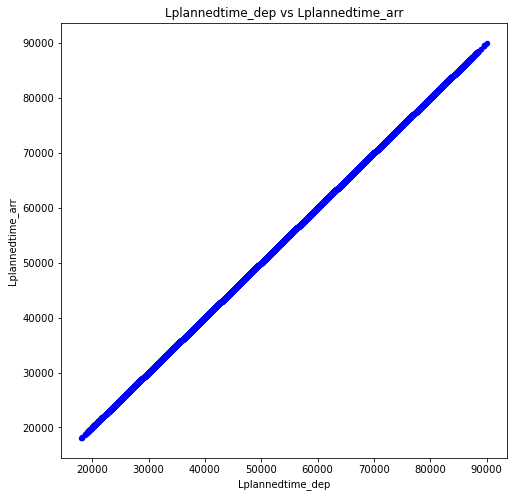

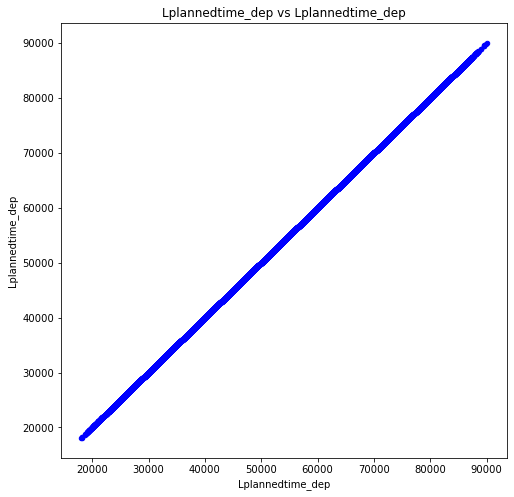

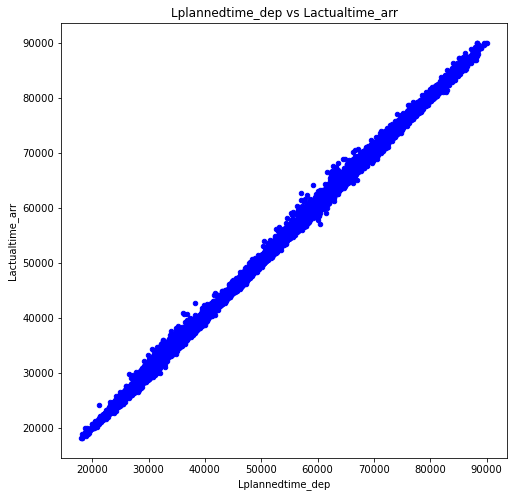

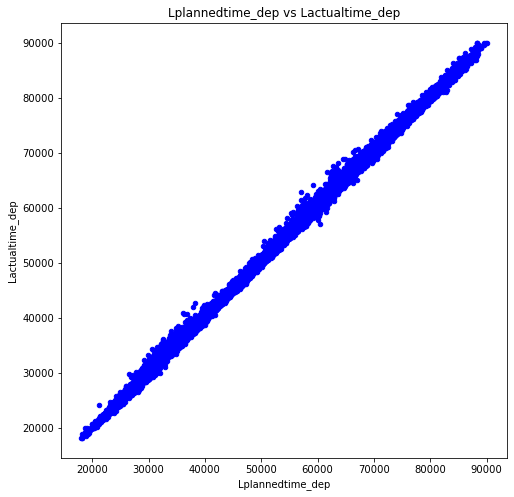

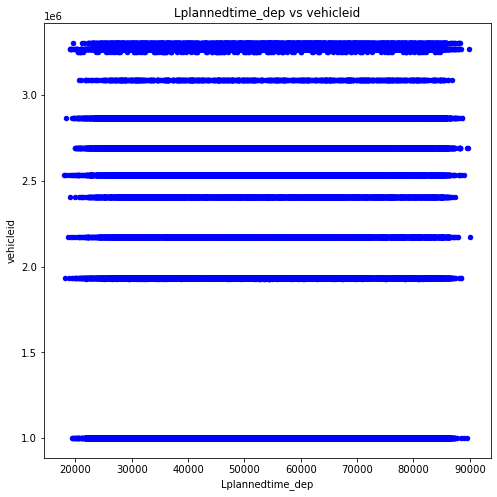

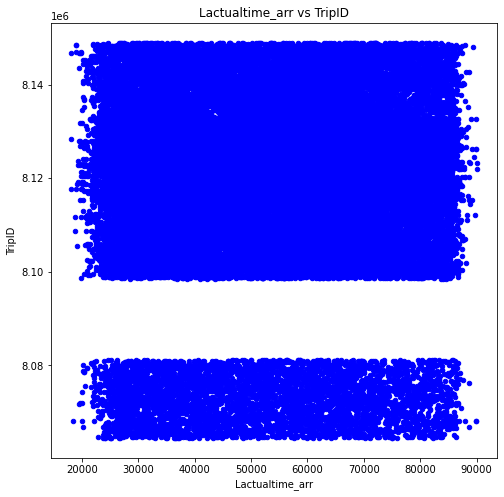

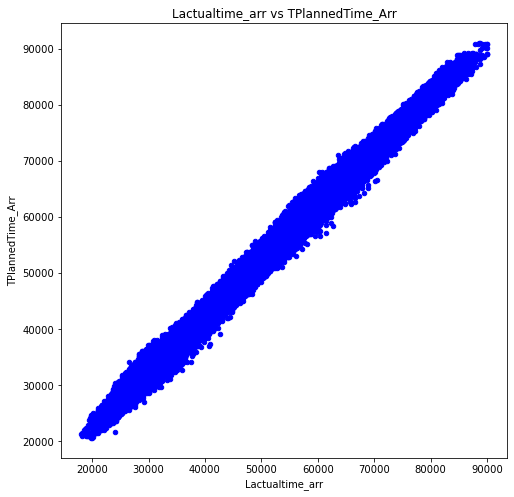

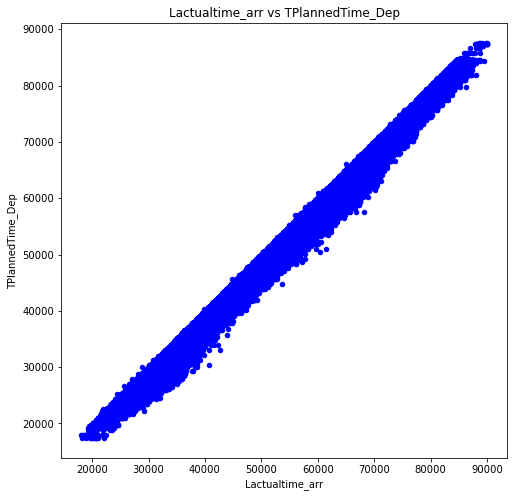

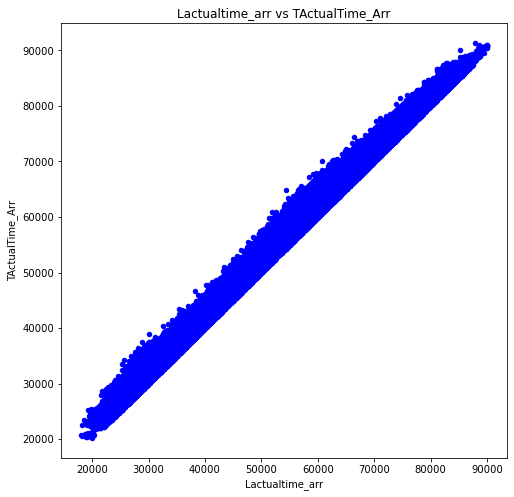

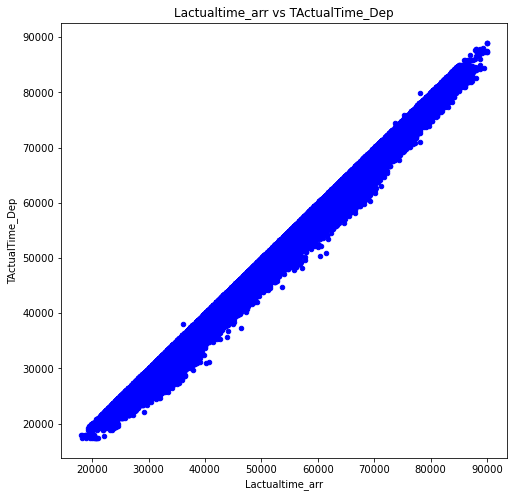

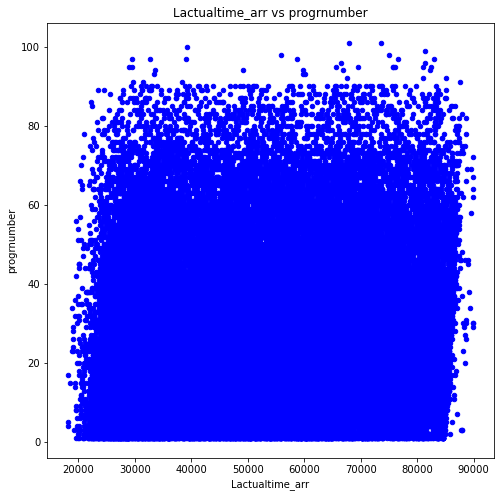

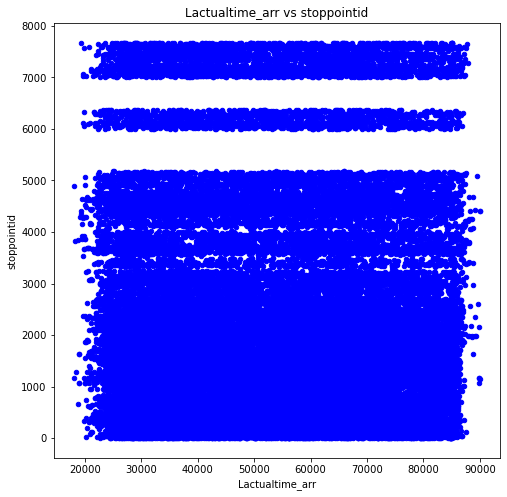

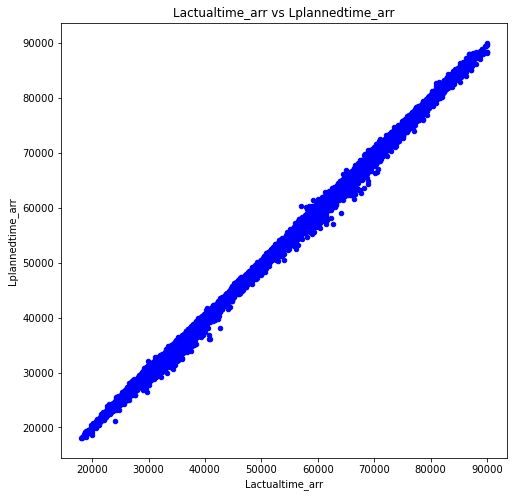

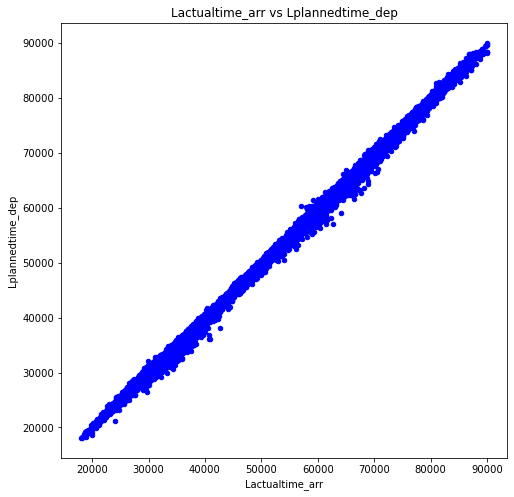

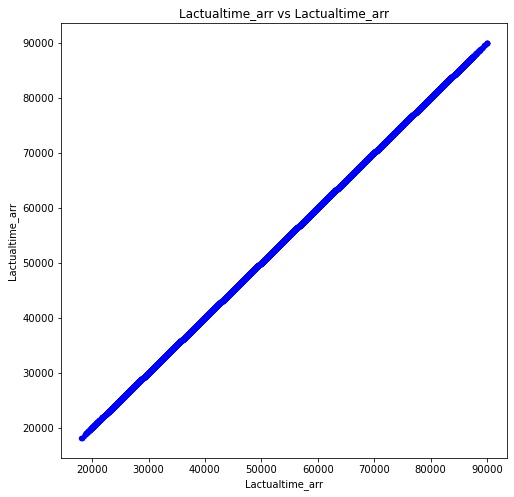

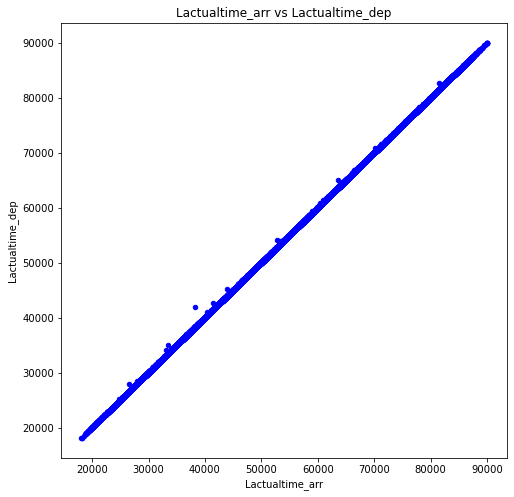

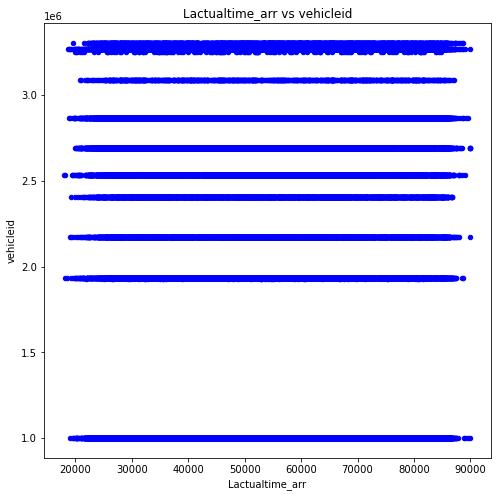

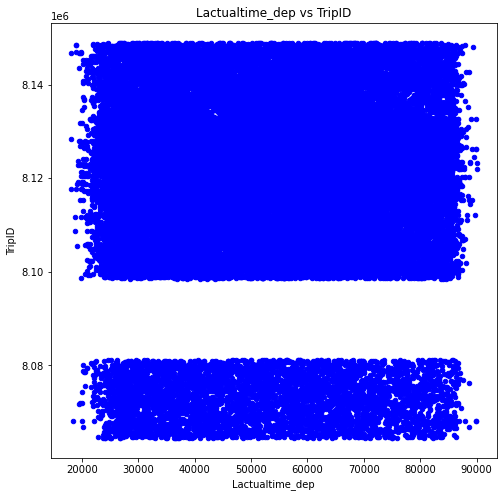

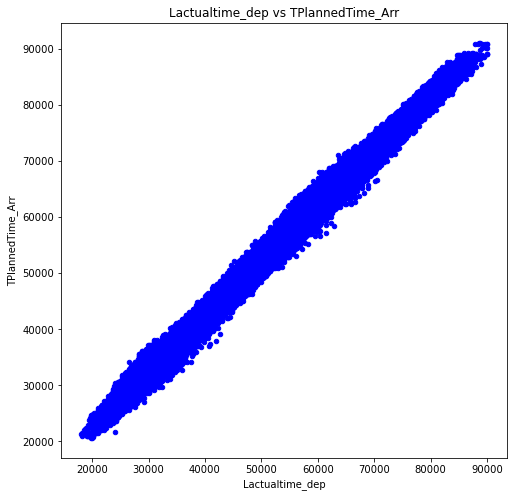

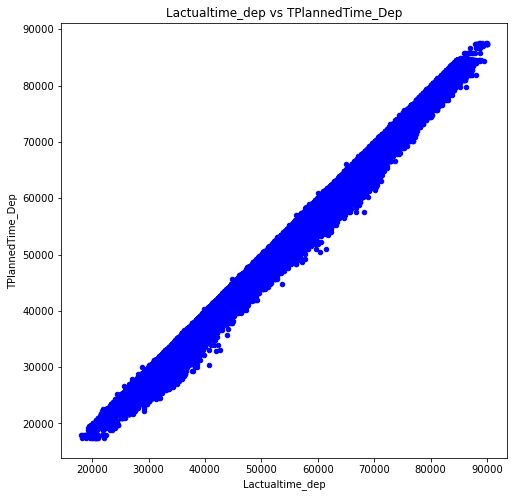

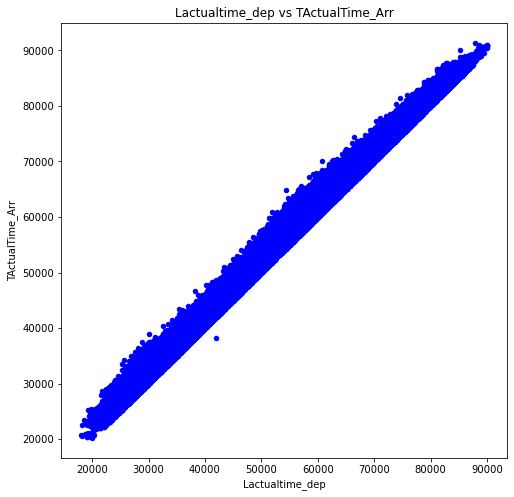

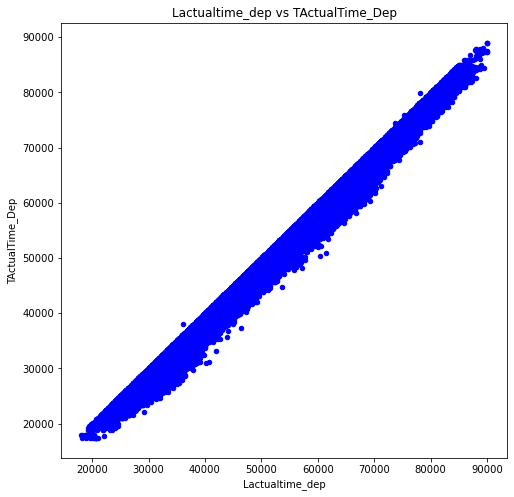

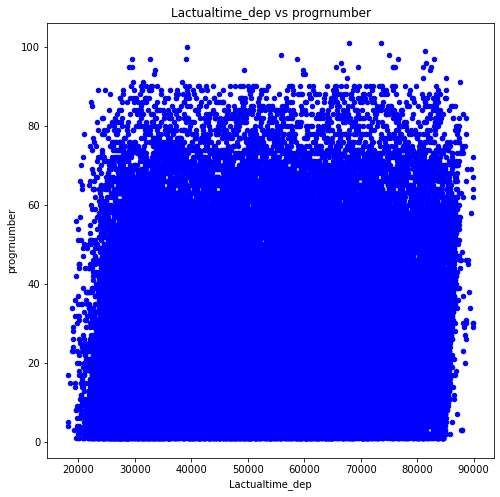

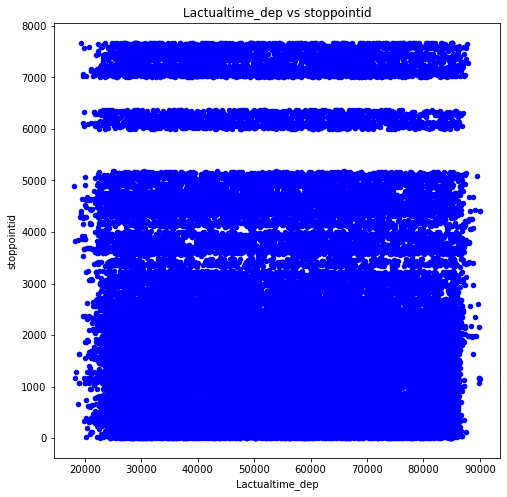

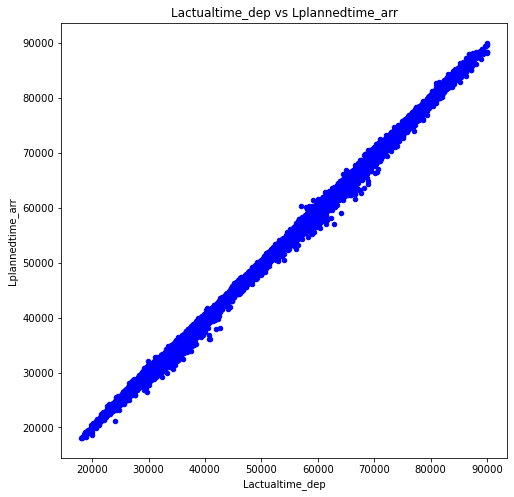

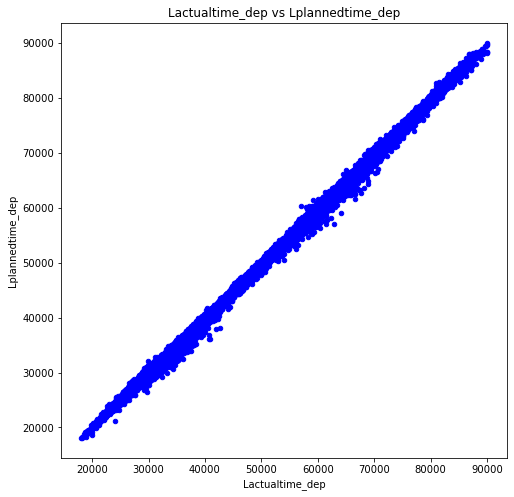

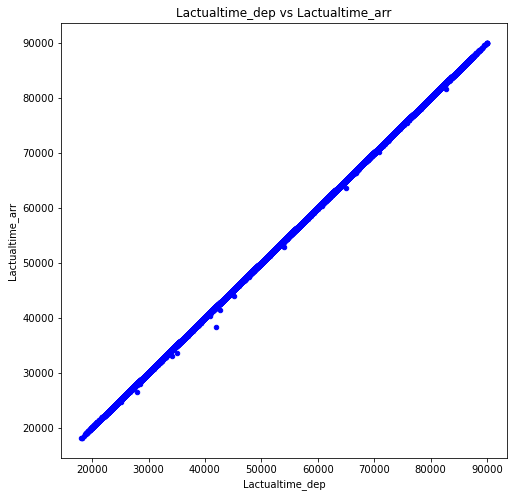

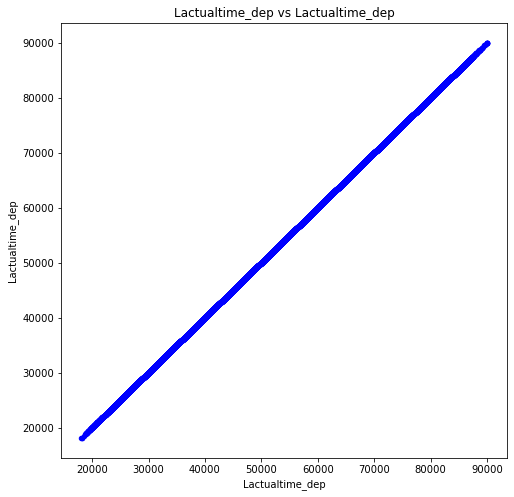

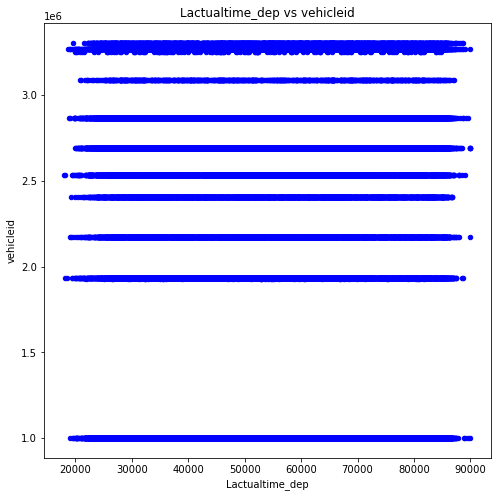

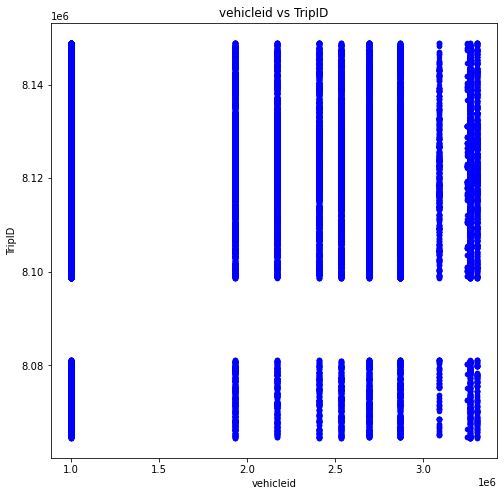

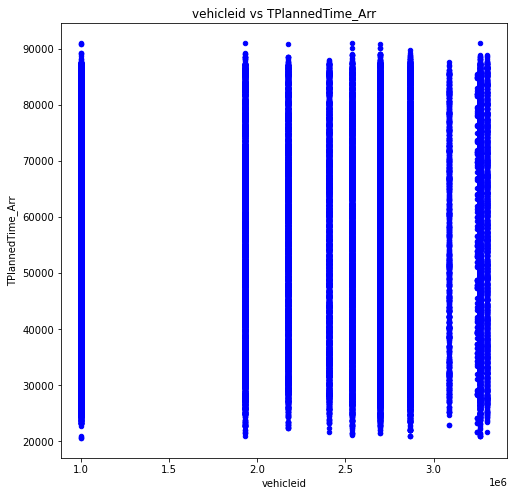

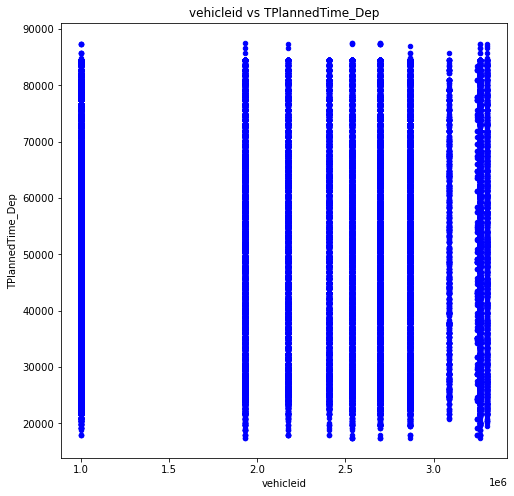

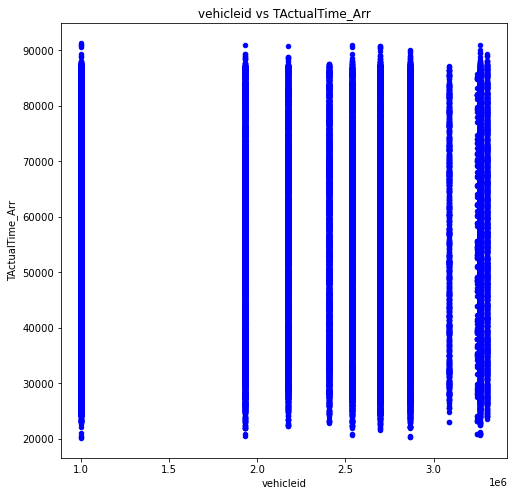

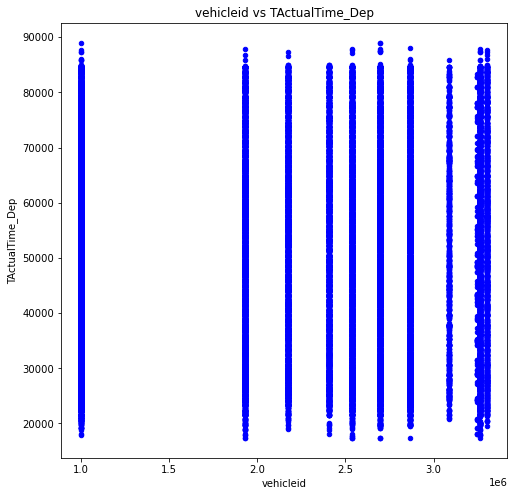

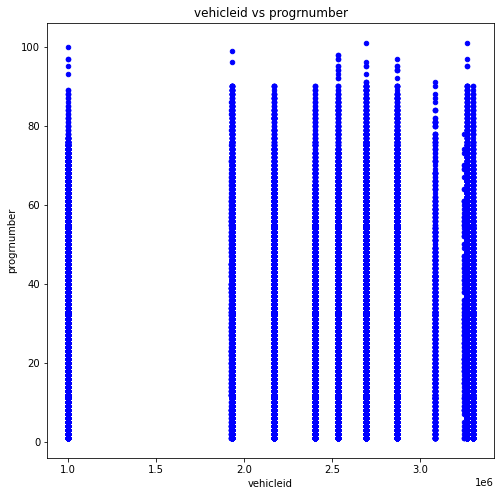

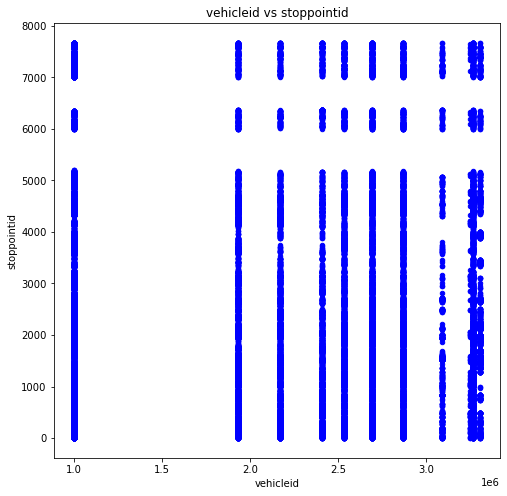

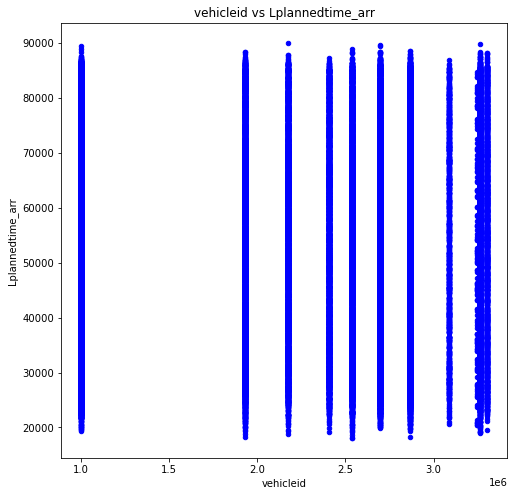

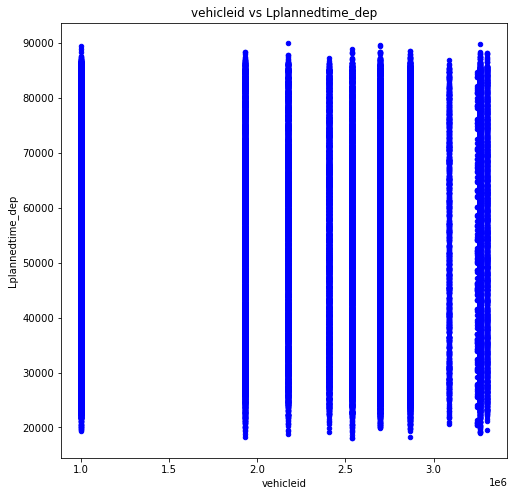

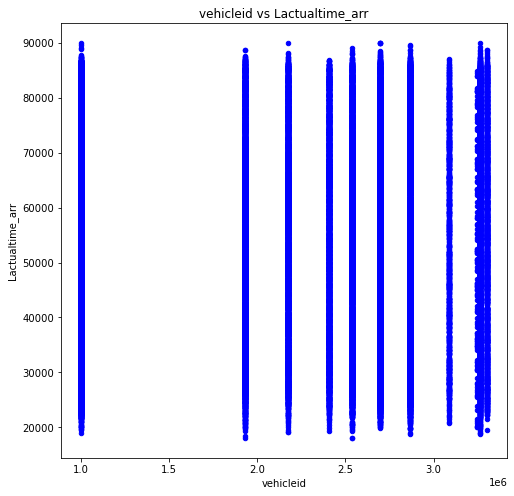

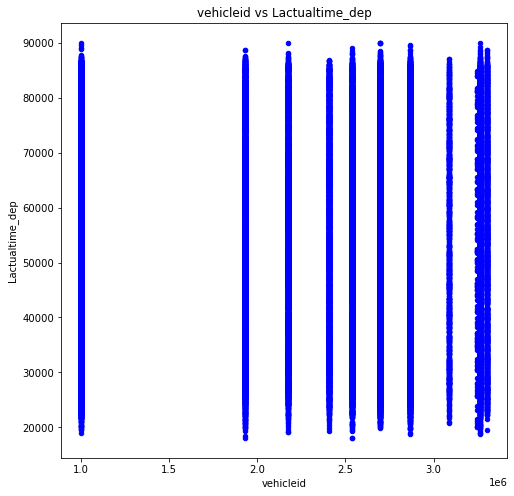

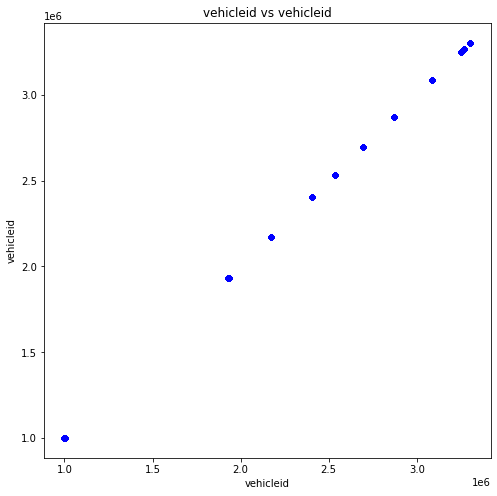

In [28]:
for feature in continuous_columns:
    for feature2 in continuous_columns:
        df_sample.plot(kind='scatter', x=feature, y=feature2, color="b", figsize=(8,8), title=f"{feature} vs {feature2}")

As we see from the above we gain valuable information on the distribution of each of the features in our dataset, we also see what features are highly corrolated and which may be of use when we are selecting features

# Datetime Features

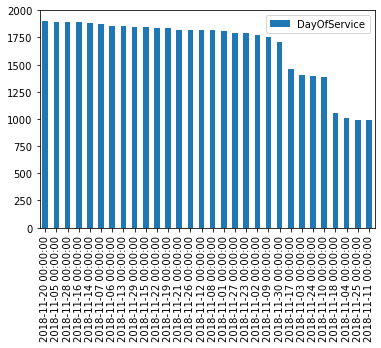

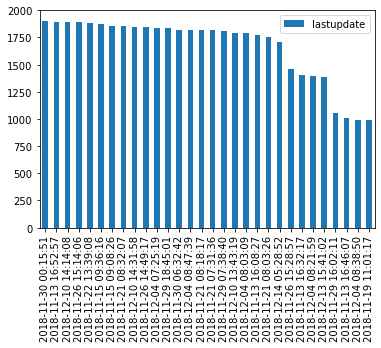

In [29]:
for col in datetime_columns:
    dates = pd.DataFrame(df_sample[col].astype("datetime64[ns]").value_counts())
    dates.plot(kind="bar")
    plt.show()

# Categorical Features

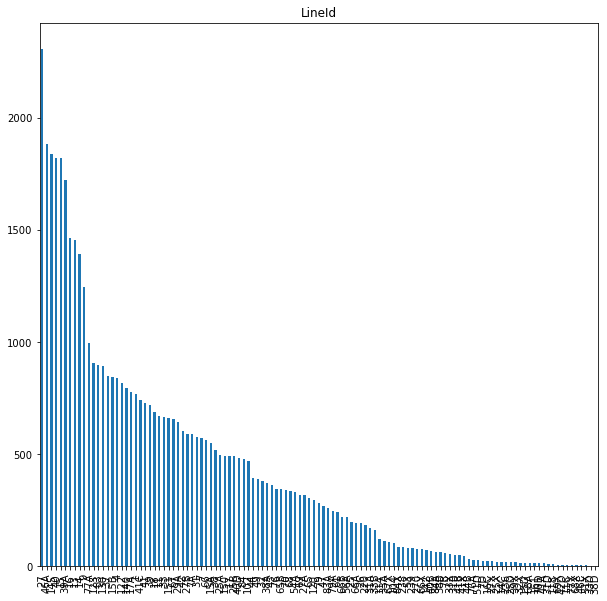

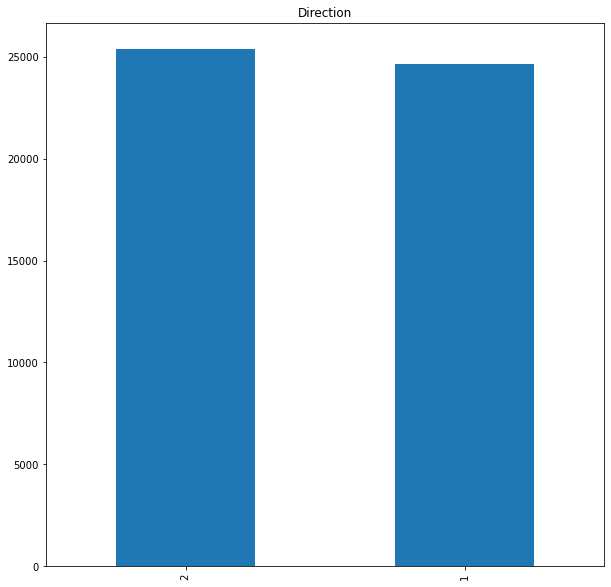

In [30]:
for col in categorical_columns:
    f = df_sample[col].value_counts().plot(kind='bar', figsize=(10,10))
    plt.title(col)
    plt.show()

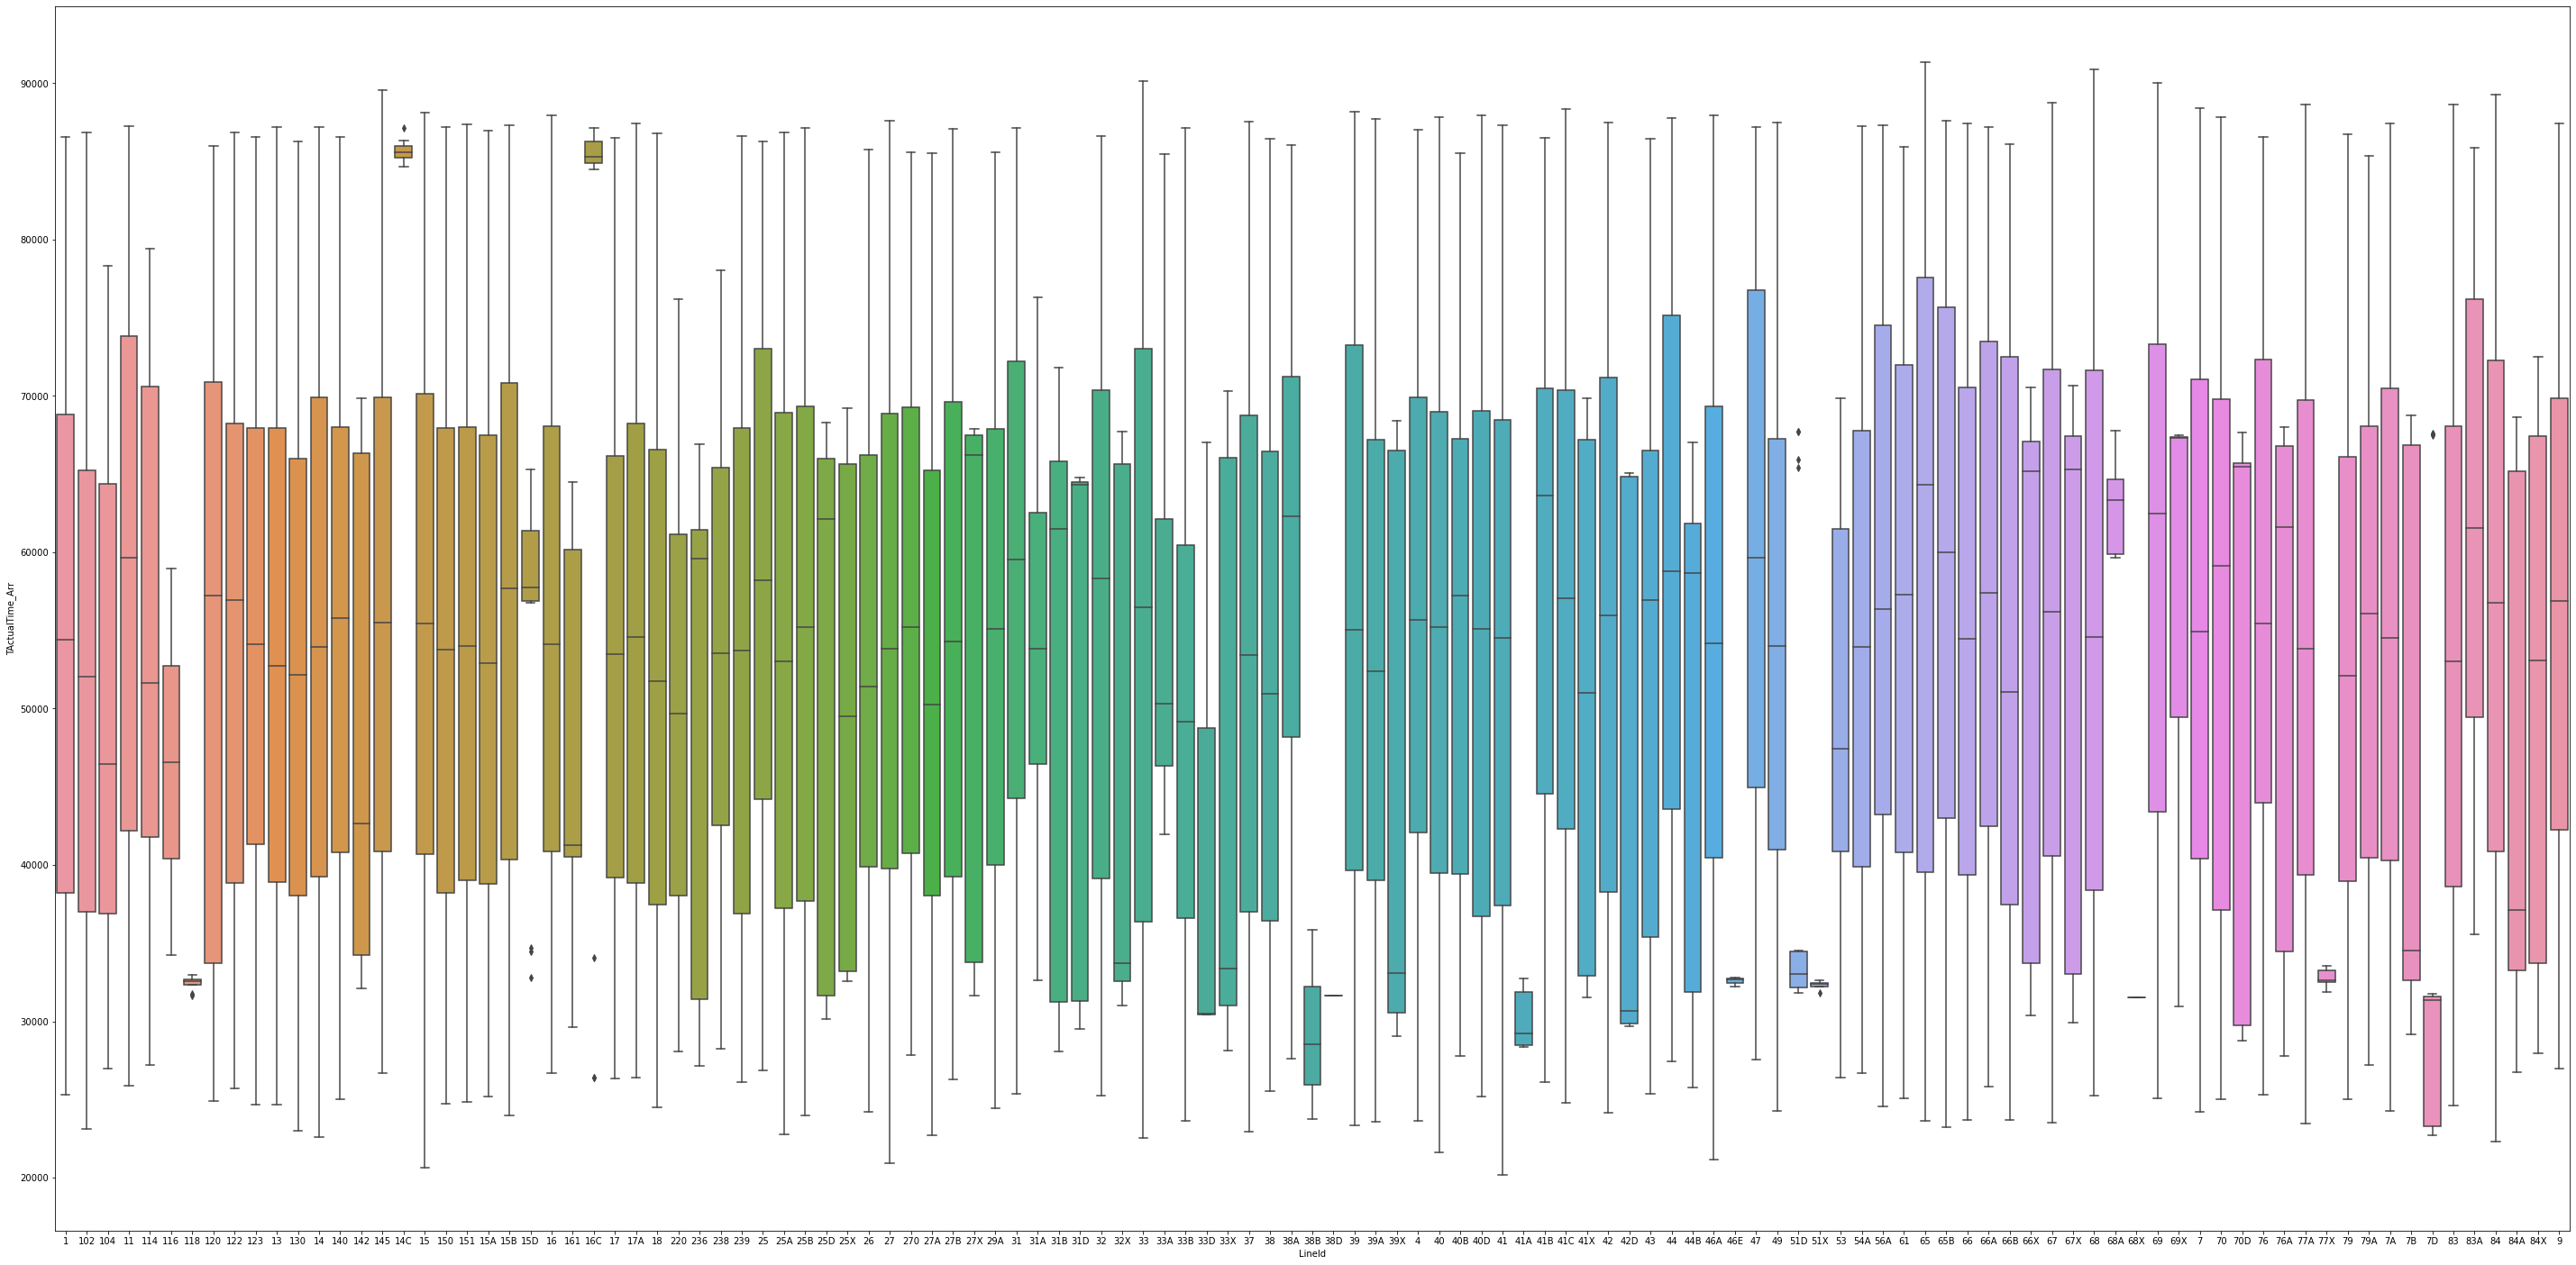

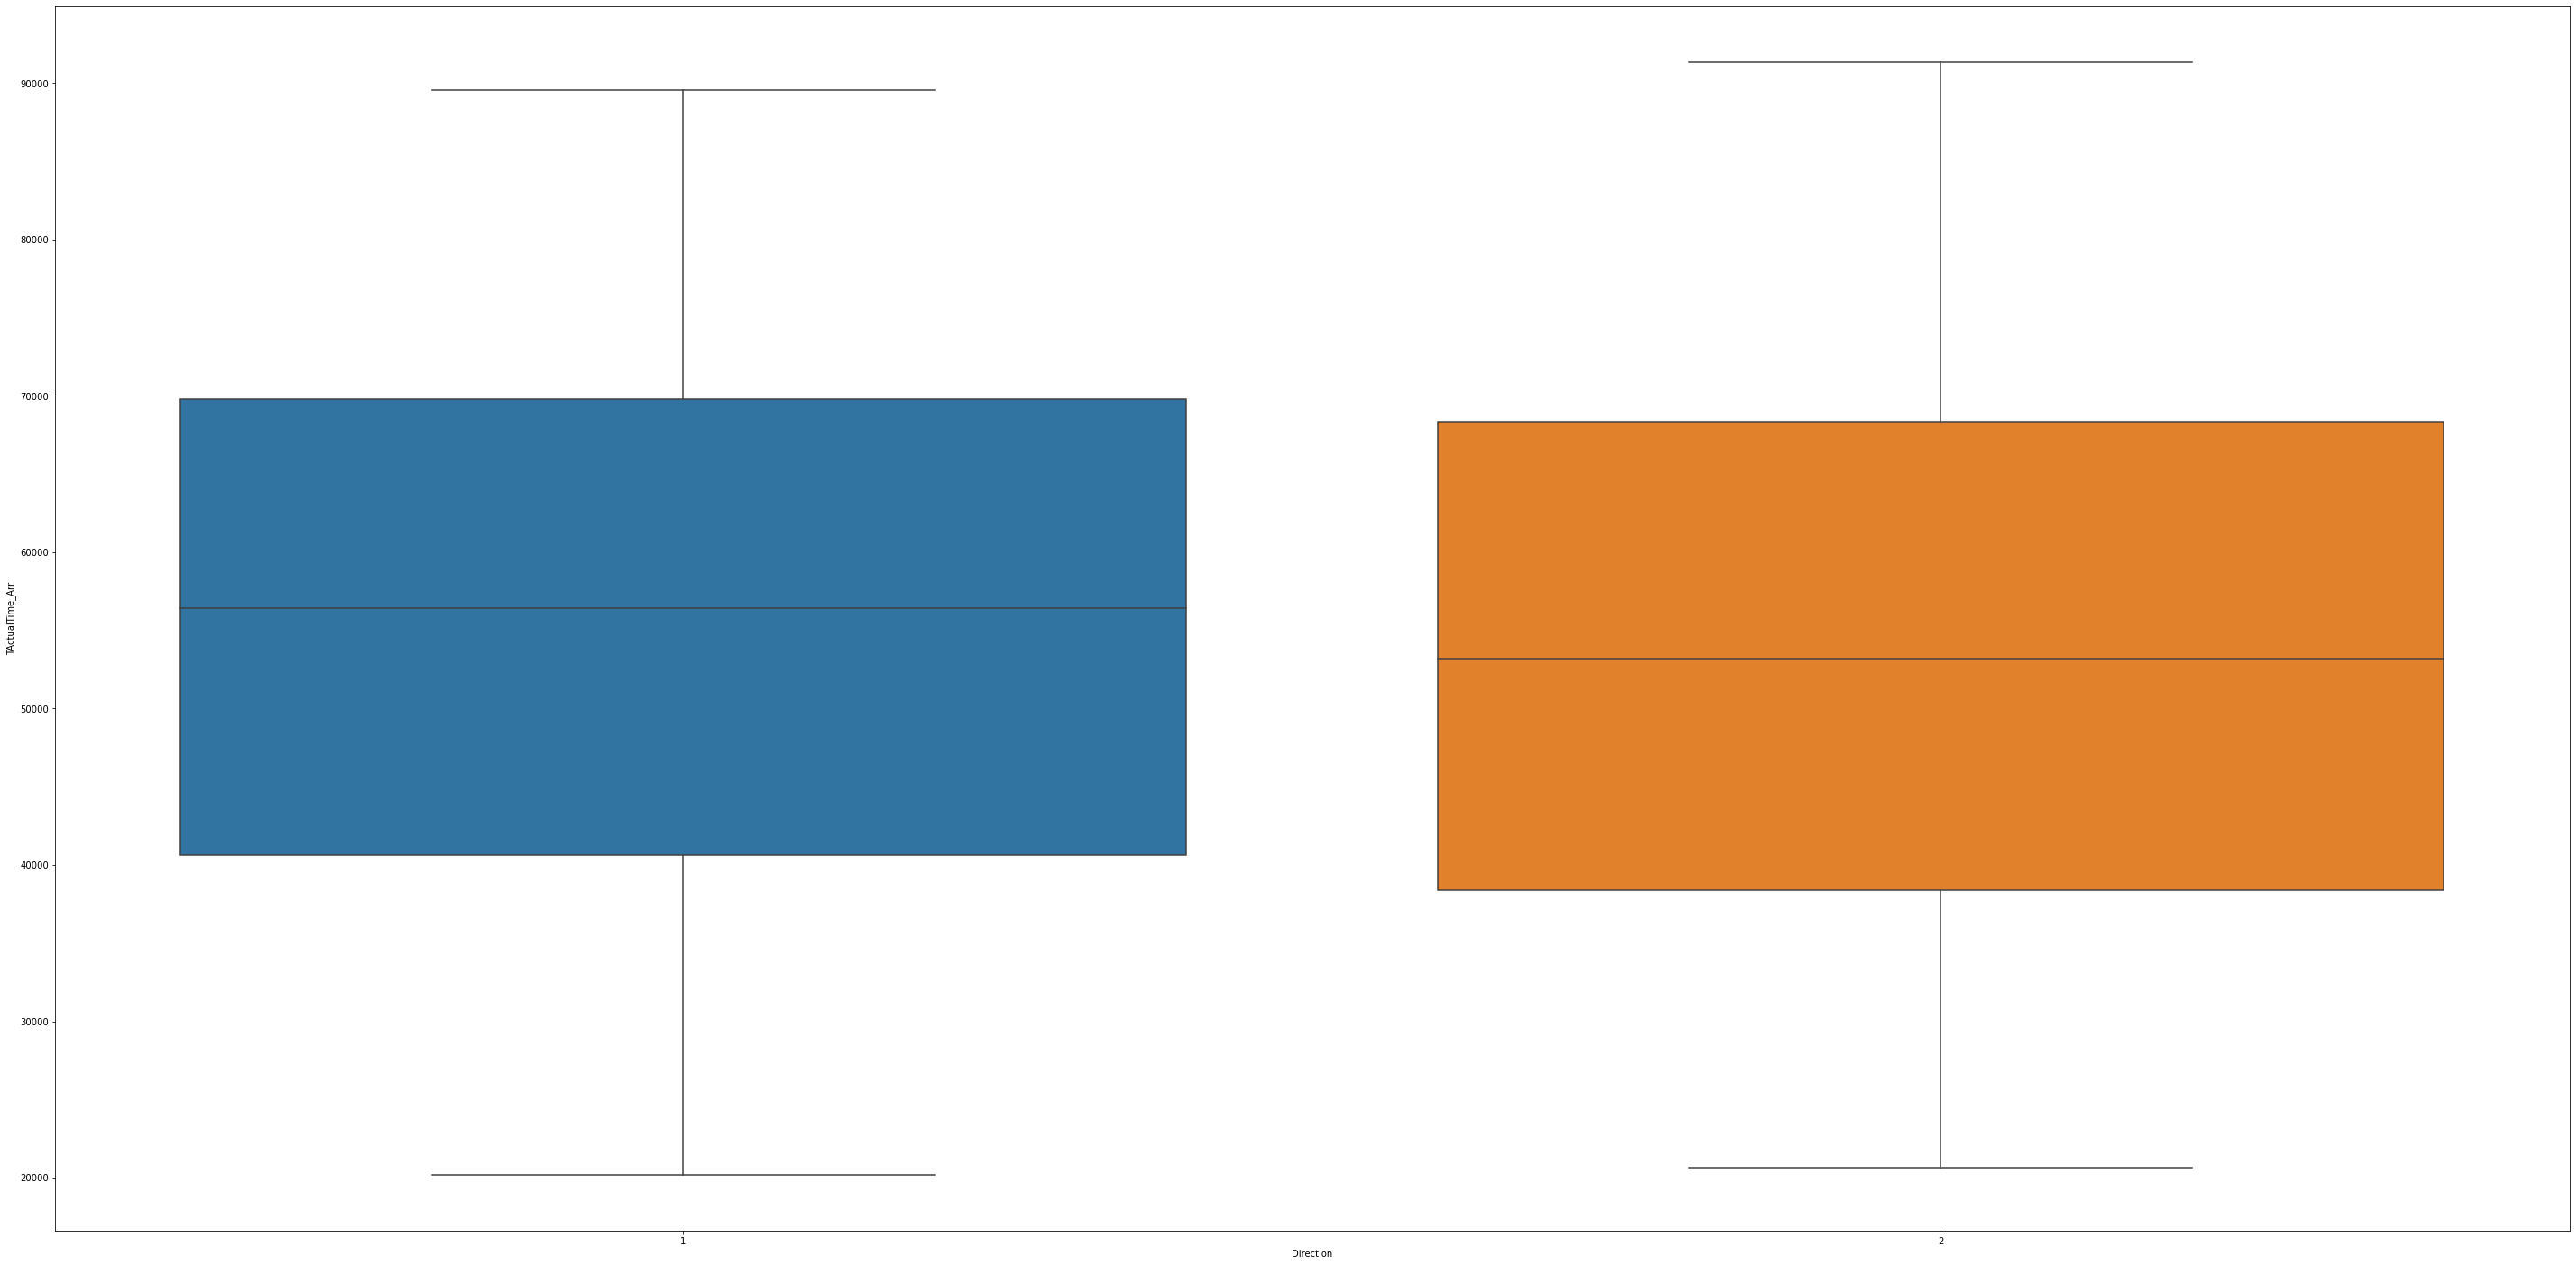

In [31]:
for feature in categorical_columns: 
    plt.figure(figsize=(50,25))
    sns.boxplot(data=df_sample[[feature,"TActualTime_Arr"]], x=feature, y="TActualTime_Arr")
    plt.show()

# Additional Analysis

### Logical integrity

Ensures that the planned trip arrival time is less than the planned trip departure time

In [32]:
# the following code origionated from sample_solution_COMP47350_DQR_DQP_DataExploration_DataPrep_CreditRiskPrediction from lab5
test_1 = df[['TPlannedTime_Arr','TPlannedTime_Dep']][(df['TPlannedTime_Arr'] <  df['TPlannedTime_Dep'])]
print("Number of rows failing the test: ", test_1.shape[0])
test_1.head(5)

Number of rows failing the test:  0


Empty DataFrame
Columns: [TPlannedTime_Arr, TPlannedTime_Dep]
Index: []

Ensures that the trip actural arrival time is less than the trip actural departure time

In [33]:
# the following code origionated from sample_solution_COMP47350_DQR_DQP_DataExploration_DataPrep_CreditRiskPrediction from lab5
test_2 = df[['TActualTime_Arr', 'TActualTime_Dep']][(df['TActualTime_Arr'] <  df['TActualTime_Dep'])]
print("Number of rows failing the test: ", test_2.shape[0])
test_2.head(5)

Number of rows failing the test:  188


TActualTime_Arr  TActualTime_Dep
2436879          27078.0          28494.0
2436880          27078.0          28494.0
2436881          27078.0          28494.0
2436882          27078.0          28494.0
2436883          27078.0          28494.0

Ensures that the leavetime planned arrival time is less than the planned leavetime departure time

In [34]:
# the following code origionated from sample_solution_COMP47350_DQR_DQP_DataExploration_DataPrep_CreditRiskPrediction from lab5
test_3 = df[['Lplannedtime_arr','Lplannedtime_dep']][(df['Lplannedtime_arr'] <  df['Lplannedtime_dep'])]
print("Number of rows failing the test: ", test_3.shape[0])
test_3.head(5)

Number of rows failing the test:  0


Empty DataFrame
Columns: [Lplannedtime_arr, Lplannedtime_dep]
Index: []

Ensures that the leavetime actual arrival time is greater than the actual leavetime departure time

In [35]:
# the following code origionated from sample_solution_COMP47350_DQR_DQP_DataExploration_DataPrep_CreditRiskPrediction from lab5
test_4 = df[['Lactualtime_arr', 'Lactualtime_dep']][(df['Lactualtime_arr'] >  df['Lactualtime_dep'])]
print("Number of rows failing the test: ", test_4.shape[0])
test_4.head(5)

Number of rows failing the test:  0


Empty DataFrame
Columns: [Lactualtime_arr, Lactualtime_dep]
Index: []

# Findings

| Feature                 | Potential Problen/ Data Quality Issue
|-------------------------|----------------------      
LineId | LineId's that do not exist anymore in the most up to date gtfs data https://transitfeeds.com/p/transport-for-ireland/782
stoppointid | station numbers that do not exist anymore in the most up to date gtfs data https://transitfeeds.com/p/transport-for-ireland/782
TActualTime_Arr | Null values, 5%
TActualTime_Dep | Null values, 6%
Lplannedtime_arr | Duplicate column
Lplannedtime_dep | Duplicate column
Lactualtime_arr | Duplicate column, Logical integrity checks failing
Lactualtime_dep | Duplicate column, Logical integrity checks failing
TActualTime_Arr | Logical integrity checks failing
TActualTime_Dep | Logical integrity checks failing



### Solutions to deal with problems

    - Duplicate cols
        - drop columns Lactualtime_arr and Lactualtime_dep as they will not be available on the web server. Drop feature Lplannedtime_dep as we will be using arrival times to create our target feature
    - Null values
        - drop col with actual time arrival missing as this will not be available when predicting
        - drop col with actual time departure missing as this will not be available when predicting
    - LineId's that do not exist anymore in the most up to date gtfs data
        - Leave LineId's that no longer exist as the names of these may have simply changed or new routes that will service many of the same stations
    - stoppointid that have changed
        - stop numbers that no longer exist since 2018 can be removed as we will be looking at the journey time between stations, there is no need to predict journey times between stations that no longer exist and will reduce the size of the training data.
    - Logical integrity 
        - remove failing rows from the dataframe to ensure that the data is fully cleaned for training

# Duplicate cols

It was decided to drop as we will be predicting arrival times

In [36]:
df = df.drop("Lplannedtime_dep", 1)

# Null values

In [37]:
df = df.drop('TActualTime_Arr', 1)
df = df.drop('TActualTime_Dep', 1)

In [38]:
df.head(5)

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0  1541030400000000000  8064443     15         1             34061   
1  1541030400000000000  8064443     15         1             34061   
2  1541030400000000000  8064443     15         1             34061   
3  1541030400000000000  8064443     15         1             34061   
4  1541030400000000000  8064443     15         1             34061   

   TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
0             29160            2         6319             29193   
1             29160            3         7246             29233   
2             29160            4         6320             29318   
3             29160            5         4594             29419   
4             29160            6         4595             29570   

   Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  
0            29192            29202    2534808  1543477120000000000  
1            29236            29247    2534808  1543477120000000000  
2            29335            29353    2534808  1543477120000000000  
3            29440            29462    2534808  1543477120000000000  
4            29546            29573    2534808  1543477120000000000

In [39]:
df.isnull().sum()

DayOfService        0
TripID              0
LineId              0
Direction           0
TPlannedTime_Arr    0
TPlannedTime_Dep    0
progrnumber         0
stoppointid         0
Lplannedtime_arr    0
Lactualtime_arr     0
Lactualtime_dep     0
vehicleid           0
lastupdate          0
dtype: int64

# Stop Id's

In [40]:
df = df[df['stoppointid'].isin(stop_nums)]

In [41]:
df.head(100)

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0   1541030400000000000  8064443     15         1             34061   
1   1541030400000000000  8064443     15         1             34061   
2   1541030400000000000  8064443     15         1             34061   
3   1541030400000000000  8064443     15         1             34061   
4   1541030400000000000  8064443     15         1             34061   
5   1541030400000000000  8064443     15         1             34061   
6   1541030400000000000  8064443     15         1             34061   
7   1541030400000000000  8064443     15         1             34061   
8   1541030400000000000  8064443     15         1             34061   
9   1541030400000000000  8064443     15         1             34061   
10  1541030400000000000  8064443     15         1             34061   
11  1541030400000000000  8064443     15         1             34061   
12  1541030400000000000  8064443     15         1             34061   
13  1541030400000000000  8064443     15         1             34061   
14  1541030400000000000  8064443     15         1             34061   
15  1541030400000000000  8064443     15         1             34061   
16  1541030400000000000  8064443     15         1             34061   
17  1541030400000000000  8064443     15         1             34061   
18  1541030400000000000  8064443     15         1             34061   
19  1541030400000000000  8064443     15         1             34061   
20  1541030400000000000  8064443     15         1             34061   
21  1541030400000000000  8064443     15         1             34061   
22  1541030400000000000  8064443     15         1             34061   
23  1541030400000000000  8064443     15         1             34061   
24  1541030400000000000  8064443     15         1             34061   
25  1541030400000000000  8064443     15         1             34061   
26  1541030400000000000  8064443     15         1             34061   
27  1541030400000000000  8064443     15         1             34061   
28  1541030400000000000  8064443     15         1             34061   
29  1541030400000000000  8064443     15         1             34061   
30  1541030400000000000  8064443     15         1             34061   
31  1541030400000000000  8064443     15         1             34061   
32  1541030400000000000  8064443     15         1             34061   
33  1541030400000000000  8064443     15         1             34061   
34  1541030400000000000  8064443     15         1             34061   
35  1541030400000000000  8064443     15         1             34061   
36  1541030400000000000  8064443     15         1             34061   
37  1541030400000000000  8064443     15         1             34061   
38  1541030400000000000  8064443     15         1             34061   
39  1541030400000000000  8064443     15         1             34061   
40  1541030400000000000  8064443     15         1             34061   
41  1541030400000000000  8064443     15         1             34061   
42  1541030400000000000  8064443     15         1             34061   
43  1541030400000000000  8064443     15         1             34061   
44  1541030400000000000  8064443     15         1             34061   
45  1541030400000000000  8064443     15         1             34061   
46  1541030400000000000  8064443     15         1             34061   
47  1541030400000000000  8064443     15         1             34061   
48  1541030400000000000  8064443     15         1             34061   
49  1541030400000000000  8064443     15         1             34061   
50  1541030400000000000  8064443     15         1             34061   
51  1541030400000000000  8064443     15         1             34061   
52  1541030400000000000  8064443     15         1             34061   
53  1541030400000000000  8064443     15         1             34061   
54  1541030400000000000  8064443     15         1             34061   
55  1541030400000000000  8064443   

In [42]:
print("Rows:" ,df.shape[0])
print("Columns:" ,df.shape[1])

Rows: 9382045
Columns: 13


# Logical integrity

In [43]:
# the following code origionated from sample_solution_COMP47350_DQR_DQP_DataExploration_DataPrep_CreditRiskPrediction from lab5
test_1 = df[['TPlannedTime_Arr','TPlannedTime_Dep']][(df['TPlannedTime_Arr'] <  df['TPlannedTime_Dep'])]
print("Number of rows failing the test: ", test_1.shape[0])
test_1.head(5)

Number of rows failing the test:  0


Empty DataFrame
Columns: [TPlannedTime_Arr, TPlannedTime_Dep]
Index: []

Test 2 requires TActualTime_Arr, TActualTime_Dep which were both dropped, no rows failing test

Test 3 requires Lplannedtime_dep which was dropped, no rows failing test

In [44]:
# the following code origionated from sample_solution_COMP47350_DQR_DQP_DataExploration_DataPrep_CreditRiskPrediction from lab5
test_4 = df[['Lactualtime_arr', 'Lactualtime_dep']][(df['Lactualtime_arr'] >  df['Lactualtime_dep'])]
print("Number of rows failing the test: ", test_4.shape[0])
test_4.head(5)

Number of rows failing the test:  0


Empty DataFrame
Columns: [Lactualtime_arr, Lactualtime_dep]
Index: []

# Create Features
### Day of the week

In [45]:
d = df["DayOfService"].astype("datetime64[ns]").dt.dayofweek

In [46]:
df.loc[d == 3]

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0        1541030400000000000  8064443     15         1             34061   
1        1541030400000000000  8064443     15         1             34061   
2        1541030400000000000  8064443     15         1             34061   
3        1541030400000000000  8064443     15         1             34061   
4        1541030400000000000  8064443     15         1             34061   
...                      ...      ...    ...       ...               ...   
9384590  1543449600000000000  8148957     41         1             68324   
9384591  1543449600000000000  8148957     41         1             68324   
9384592  1543449600000000000  8148957     41         1             68324   
9384593  1543449600000000000  8148957     41         1             68324   
9384594  1543449600000000000  8148957     41         1             68324   

         TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
0                   29160            2         6319             29193   
1                   29160            3         7246             29233   
2                   29160            4         6320             29318   
3                   29160            5         4594             29419   
4                   29160            6         4595             29570   
...                   ...          ...          ...               ...   
9384590             64200           47         4912             68138   
9384591             64200           11           21             65087   
9384592             64200           23         1626             66095   
9384593             64200           36         5074             67490   
9384594             64200           49         4914             68218   

         Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  
0                  29192            29202    2534808  1543477120000000000  
1                  29236            29247    2534808  1543477120000000000  
2                  29335            29353    2534808  1543477120000000000  
3                  29440            29462    2534808  1543477120000000000  
4                  29546            29573    2534808  1543477120000000000  
...                  ...              ...        ...                  ...  
9384590            68650            68666    2534845  1544452318000000000  
9384591            65330            65330    2534845  1544452318000000000  
9384592            66516            66568    2534845  1544452318000000000  
9384593            67842            67862    2534845  1544452318000000000  
9384594            68717            68717    2534845  1544452318000000000  

[1717866 rows x 13 columns]

In [47]:
d = df["DayOfService"].astype("datetime64[ns]").dt.dayofweek
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for val, day in enumerate(days):
    df[day] = 0
    df[day].loc[d == val] = 1 

C:\Users\frank\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
df

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0        1541030400000000000  8064443     15         1             34061   
1        1541030400000000000  8064443     15         1             34061   
2        1541030400000000000  8064443     15         1             34061   
3        1541030400000000000  8064443     15         1             34061   
4        1541030400000000000  8064443     15         1             34061   
...                      ...      ...    ...       ...               ...   
9733159  1543536000000000000  8148957     41         1             68324   
9733160  1543536000000000000  8148957     41         1             68324   
9733161  1543536000000000000  8148957     41         1             68324   
9733162  1543536000000000000  8148957     41         1             68324   
9733163  1543536000000000000  8148957     41         1             68324   

         TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
0                   29160            2         6319             29193   
1                   29160            3         7246             29233   
2                   29160            4         6320             29318   
3                   29160            5         4594             29419   
4                   29160            6         4595             29570   
...                   ...          ...          ...               ...   
9733159             64200           14          203             65317   
9733160             64200            1          288             64200   
9733161             64200           40         5075             67856   
9733162             64200            3         1172             64329   
9733163             64200           43         3864             68007   

         Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  \
0                  29192            29202    2534808  1543477120000000000   
1                  29236            29247    2534808  1543477120000000000   
2                  29335            29353    2534808  1543477120000000000   
3                  29440            29462    2534808  1543477120000000000   
4                  29546            29573    2534808  1543477120000000000   
...                  ...              ...        ...                  ...   
9733159            65390            65417    1932358  1544765332000000000   
9733160            64186            64186    1932358  1544765332000000000   
9733161            67912            67926    1932358  1544765332000000000   
9733162            64390            64401    1932358  1544765332000000000   
9733163            68085            68100    1932358  1544765332000000000   

         Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  
0             0        0          0         1       0         0       0  
1             0        0          0         1       0         0       0  
2             0        0          0         1       0         0       0  
3             0        0          0         1       0         0       0  
4             0        0          0         1       0         0       0  
...         ...      ...        ...       ...     ...       ...     ...  
9733159       0        0          0         0       1         0       0  
9733160       0        0          0         0       1         0       0  
9733161       0        0          0         0       1         0       0  
9733162       0        0          0         0       1         0       0  
9733163       0        0          0         0       1         0       0  

[9382045 rows x 20 columns]

### Create travel time feature

In [49]:
# sort values so they are grouped by day of service, tripid and then progression number
df = df.sort_values(by=['DayOfService','TripID','progrnumber'])

In [50]:
df.head(100)

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
63   1541030400000000000  8064443     15         1             34061   
0    1541030400000000000  8064443     15         1             34061   
1    1541030400000000000  8064443     15         1             34061   
2    1541030400000000000  8064443     15         1             34061   
3    1541030400000000000  8064443     15         1             34061   
4    1541030400000000000  8064443     15         1             34061   
5    1541030400000000000  8064443     15         1             34061   
6    1541030400000000000  8064443     15         1             34061   
7    1541030400000000000  8064443     15         1             34061   
8    1541030400000000000  8064443     15         1             34061   
64   1541030400000000000  8064443     15         1             34061   
9    1541030400000000000  8064443     15         1             34061   
10   1541030400000000000  8064443     15         1             34061   
11   1541030400000000000  8064443     15         1             34061   
12   1541030400000000000  8064443     15         1             34061   
13   1541030400000000000  8064443     15         1             34061   
14   1541030400000000000  8064443     15         1             34061   
65   1541030400000000000  8064443     15         1             34061   
15   1541030400000000000  8064443     15         1             34061   
16   1541030400000000000  8064443     15         1             34061   
17   1541030400000000000  8064443     15         1             34061   
18   1541030400000000000  8064443     15         1             34061   
19   1541030400000000000  8064443     15         1             34061   
20   1541030400000000000  8064443     15         1             34061   
21   1541030400000000000  8064443     15         1             34061   
22   1541030400000000000  8064443     15         1             34061   
23   1541030400000000000  8064443     15         1             34061   
24   1541030400000000000  8064443     15         1             34061   
66   1541030400000000000  8064443     15         1             34061   
25   1541030400000000000  8064443     15         1             34061   
26   1541030400000000000  8064443     15         1             34061   
27   1541030400000000000  8064443     15         1             34061   
28   1541030400000000000  8064443     15         1             34061   
29   1541030400000000000  8064443     15         1             34061   
30   1541030400000000000  8064443     15         1             34061   
31   1541030400000000000  8064443     15         1             34061   
32   1541030400000000000  8064443     15         1             34061   
33   1541030400000000000  8064443     15         1             34061   
67   1541030400000000000  8064443     15         1             34061   
34   1541030400000000000  8064443     15         1             34061   
35   1541030400000000000  8064443     15         1             34061   
36   1541030400000000000  8064443     15         1             34061   
37   1541030400000000000  8064443     15         1             34061   
38   1541030400000000000  8064443     15         1             34061   
39   1541030400000000000  8064443     15         1             34061   
40   1541030400000000000  8064443     15         1             34061   
41   1541030400000000000  8064443     15         1             34061   
42   1541030400000000000  8064443     15         1             34061   
68   1541030400000000000  8064443     15         1             34061   
43   1541030400000000000  8064443     15         1             34061   
44   1541030400000000000  8064443     15         1             34061   
45   1541030400000000000  8064443     15         1             34061   
46   1541030400000000000  8064443     15         1             34061   
47   1541030400000000000  8064443     15         1             34061   
48   1541030400000000000  8064443     15         1  

In [51]:
df['journeytime'] = df['Lactualtime_arr'].diff()

In [52]:
df

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
63       1541030400000000000  8064443     15         1             34061   
0        1541030400000000000  8064443     15         1             34061   
1        1541030400000000000  8064443     15         1             34061   
2        1541030400000000000  8064443     15         1             34061   
3        1541030400000000000  8064443     15         1             34061   
...                      ...      ...    ...       ...               ...   
9733120  1543536000000000000  8148957     41         1             68324   
9733122  1543536000000000000  8148957     41         1             68324   
9733123  1543536000000000000  8148957     41         1             68324   
9733125  1543536000000000000  8148957     41         1             68324   
9733147  1543536000000000000  8148957     41         1             68324   

         TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
63                  29160            1         6318             29160   
0                   29160            2         6319             29193   
1                   29160            3         7246             29233   
2                   29160            4         6320             29318   
3                   29160            5         4594             29419   
...                   ...          ...          ...               ...   
9733120             64200           47         4912             68138   
9733122             64200           48         4913             68185   
9733123             64200           49         4914             68218   
9733125             64200           50         4915             68258   
9733147             64200           51         4957             68324   

         Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  \
63                 29167            29167    2534808  1543477120000000000   
0                  29192            29202    2534808  1543477120000000000   
1                  29236            29247    2534808  1543477120000000000   
2                  29335            29353    2534808  1543477120000000000   
3                  29440            29462    2534808  1543477120000000000   
...                  ...              ...        ...                  ...   
9733120            68195            68205    1932358  1544765332000000000   
9733122            68233            68233    1932358  1544765332000000000   
9733123            68255            68264    1932358  1544765332000000000   
9733125            68313            68326    1932358  1544765332000000000   
9733147            68369            68369    1932358  1544765332000000000   

         Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  \
63            0        0          0         1       0         0       0   
0             0        0          0         1       0         0       0   
1             0        0          0         1       0         0       0   
2             0        0          0         1       0         0       0   
3             0        0          0         1       0         0       0   
...         ...      ...        ...       ...     ...       ...     ...   
9733120       0        0          0         0       1         0       0   
9733122       0        0          0         0       1         0       0   
9733123       0        0          0         0       1         0       0   
9733125       0        0          0         0       1         0       0   
9733147       0        0          0         0       1         0       0   

         journeytime  
63               NaN  
0               25.0  
1               44.0  
2               99.0  
3              105.0  
...              ...  
9733120         18.0  
9733122         38.0  
9733123         22.0  
9733125         58.0  
9733147         56.0  

[9382045 rows x 21 columns]

# Create first stop to next stop feature

In [53]:
previous_stop = [None] + list(df["stoppointid"][:len(df) - 1].values)

In [54]:
df["previous_stop"] = previous_stop

In [55]:
df = df.drop(list(df[['DayOfService', 'TripID']].drop_duplicates().index))

Drop the first occurance of a day of service and tipid as this will correspond to the first stop on the route, there will be no journey time as there was no previous stop

In [56]:
df["previous_stop"] = df["previous_stop"].astype("int64")

In [57]:
df.head()

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0  1541030400000000000  8064443     15         1             34061   
1  1541030400000000000  8064443     15         1             34061   
2  1541030400000000000  8064443     15         1             34061   
3  1541030400000000000  8064443     15         1             34061   
4  1541030400000000000  8064443     15         1             34061   

   TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
0             29160            2         6319             29193   
1             29160            3         7246             29233   
2             29160            4         6320             29318   
3             29160            5         4594             29419   
4             29160            6         4595             29570   

   Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  Monday  \
0            29192            29202    2534808  1543477120000000000       0   
1            29236            29247    2534808  1543477120000000000       0   
2            29335            29353    2534808  1543477120000000000       0   
3            29440            29462    2534808  1543477120000000000       0   
4            29546            29573    2534808  1543477120000000000       0   

   Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  journeytime  \
0        0          0         1       0         0       0         25.0   
1        0          0         1       0         0       0         44.0   
2        0          0         1       0         0       0         99.0   
3        0          0         1       0         0       0        105.0   
4        0          0         1       0         0       0        106.0   

   previous_stop  
0           6318  
1           6319  
2           7246  
3           6320  
4           4594

In [58]:
print("Rows:" ,df.shape[0])
print("Columns:" ,df.shape[1])

Rows: 9201548
Columns: 22


### Logical integrity of new features

In [59]:
df[df['journeytime'] <= 0]

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
12107    1541030400000000000  8064979    46A         1             57739   
22408    1541030400000000000  8065445      9         2             62852   
25324    1541030400000000000  8065539    123         1             44648   
60200    1541030400000000000  8067272     49         1             37551   
60201    1541030400000000000  8067272     49         1             37551   
...                      ...      ...    ...       ...               ...   
9704686  1543536000000000000  8147461    123         1             50779   
9708548  1543536000000000000  8147616     14         1             80373   
9714530  1543536000000000000  8147971    123         1             39095   
9715542  1543536000000000000  8148133    239         2             66316   
9724602  1543536000000000000  8148558    123         1             52219   

         TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
12107               53280           20          846             55087   
22408               58200           39          196             60979   
25324               41280            2         2183             41309   
60200               35100           28         2518             36557   
60201               35100           29         4749             36625   
...                   ...          ...          ...               ...   
9704686             47040            2         2183             47076   
9708548             76800           71         2863             80183   
9714530             35520            2         2183             35554   
9715542             63000            2         4715             63001   
9724602             48480            2         2183             48516   

         Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  \
12107              55322            55341    1000269  1543477120000000000   
22408              61427            61427    2868372  1543477120000000000   
25324              41313            41396    3265694  1543477120000000000   
60200              36674            36674    1932334  1543477120000000000   
60201              36674            36674    1932334  1543477120000000000   
...                  ...              ...        ...                  ...   
9704686            46952            47000    2534846  1544765332000000000   
9708548            80703            80703    2868382  1544765332000000000   
9714530            35435            35474    2868339  1544765332000000000   
9715542            63025            63025    1001188  1544765332000000000   
9724602            48333            48537    2868393  1544765332000000000   

         Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  \
12107         0        0          0         1       0         0       0   
22408         0        0          0         1       0         0       0   
25324         0        0          0         1       0         0       0   
60200         0        0          0         1       0         0       0   
60201         0        0          0         1       0         0       0   
...         ...      ...        ...       ...     ...       ...     ...   
9704686       0        0          0         0       1         0       0   
9708548       0        0          0         0       1         0       0   
9714530       0        0          0         0       1         0       0   
9715542       0        0          0         0       1         0       0   
9724602       0        0          0         0       1         0       0   

         journeytime  previous_stop  
12107         -644.0            845  
22408          -15.0            195  
25324            0.0           6057  
60200            0.0           2517  
60201            0.0           2518  
...              ...            ...  
9704686          0.0           6057  
9708548          0.0           2862  
9714530          0.0           6057  
9715542          0.0

Drop all journey times that are less than zero as these are sequential stops on a trip each stop should have positive journey time

In [60]:
df = df.drop(list(df[df['journeytime'] <= 0].index))

# Segment and categories

In this section we will use distances and timetabled times for station to station journeys from the gtfs data, these are created in the GTFS jupyter notebook in the same folder and loaded for use here

In [61]:
df["segment"] = df["previous_stop"].astype(str) + "_" + df["stoppointid"].astype(str)
df["segment"] = df["segment"].astype("category")

In [62]:
# https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict
import pickle

with open('journeytimes.pickle', 'rb') as handle:
    segment_categories = pickle.load(handle)

In [63]:
segment_categories_list = list(segment_categories.keys())

In [64]:
df = df[df['segment'].isin(segment_categories_list)]

In [65]:
df["timetabledtimes"] = df["segment"].map(segment_categories).astype("int64")

In [66]:
# https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict
import pickle

with open('distances.pickle', 'rb') as handle:
    distances = pickle.load(handle)

In [67]:
df["distances"] = df["segment"].map(distances).astype("float64")

In [68]:
df.dtypes

DayOfService           int64
TripID                 int64
LineId              category
Direction           category
TPlannedTime_Arr       int64
TPlannedTime_Dep       int64
progrnumber            int64
stoppointid            int64
Lplannedtime_arr       int64
Lactualtime_arr        int64
Lactualtime_dep        int64
vehicleid              int64
lastupdate             int64
Monday                 int64
Tuesday                int64
Wednesday              int64
Thursday               int64
Friday                 int64
Saturday               int64
Sunday                 int64
journeytime          float64
previous_stop          int64
segment             category
timetabledtimes        int64
distances            float64
dtype: object

In [69]:
df.head()

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0  1541030400000000000  8064443     15         1             34061   
1  1541030400000000000  8064443     15         1             34061   
2  1541030400000000000  8064443     15         1             34061   
3  1541030400000000000  8064443     15         1             34061   
4  1541030400000000000  8064443     15         1             34061   

   TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
0             29160            2         6319             29193   
1             29160            3         7246             29233   
2             29160            4         6320             29318   
3             29160            5         4594             29419   
4             29160            6         4595             29570   

   Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  Monday  \
0            29192            29202    2534808  1543477120000000000       0   
1            29236            29247    2534808  1543477120000000000       0   
2            29335            29353    2534808  1543477120000000000       0   
3            29440            29462    2534808  1543477120000000000       0   
4            29546            29573    2534808  1543477120000000000       0   

   Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  journeytime  \
0        0          0         1       0         0       0         25.0   
1        0          0         1       0         0       0         44.0   
2        0          0         1       0         0       0         99.0   
3        0          0         1       0         0       0        105.0   
4        0          0         1       0         0       0        106.0   

   previous_stop    segment  timetabledtimes  distances  
0           6318  6318_6319      23000000000   0.191049  
1           6319  6319_7246      33000000000   0.229054  
2           7246  7246_6320      67000000000   0.352163  
3           6320  6320_4594      48000000000   0.277041  
4           4594  4594_4595      72000000000   0.705783

In [70]:
# select a random segment to make sure it exists
df[df["segment"] == "758_759"]

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
4960     1541030400000000000  8064634    67X         2             32440   
6046     1541030400000000000  8064694    145         1             32282   
6138     1541030400000000000  8064696    145         1             45540   
6328     1541030400000000000  8064698    145         1             58181   
6422     1541030400000000000  8064700    145         1             71493   
...                      ...      ...    ...       ...               ...   
9717461  1543536000000000000  8148188    39A         2             24107   
9717603  1543536000000000000  8148190    39A         2             36594   
9717788  1543536000000000000  8148194    39A         2             61991   
9726233  1543536000000000000  8148708    145         1             55982   
9726380  1543536000000000000  8148710    145         1             69304   

         TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
4960                27000           49          759             32122   
6046                27600           19          759             29355   
6138                40800           19          759             42532   
6328                52800           19          759             54647   
6422                66000           19          759             68108   
...                   ...          ...          ...               ...   
9717461             19200           66          759             23709   
9717603             30600           66          759             36183   
9717788             56400           66          759             61555   
9726233             50400           19          759             52265   
9726380             63600           19          759             65784   

         Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  \
4960               31367            31367    1000594  1543477120000000000   
6046               29765            29782    1000590  1543477120000000000   
6138               42464            42464    1000590  1543477120000000000   
6328               54815            54815    1000590  1543477120000000000   
6422               68188            68200    1000590  1543477120000000000   
...                  ...              ...        ...                  ...   
9717461            23896            23905    1000948  1544765332000000000   
9717603            37061            37061    1000948  1544765332000000000   
9717788            62626            62638    1000948  1544765332000000000   
9726233            52326            52342    2172277  1544765332000000000   
9726380            66136            66136    2172277  1544765332000000000   

         Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  \
4960          0        0          0         1       0         0       0   
6046          0        0          0         1       0         0       0   
6138          0        0          0         1       0         0       0   
6328          0        0          0         1       0         0       0   
6422          0        0          0         1       0         0       0   
...         ...      ...        ...       ...     ...       ...     ...   
9717461       0        0          0         0       1         0       0   
9717603       0        0          0         0       1         0       0   
9717788       0        0          0         0       1         0       0   
9726233       0        0          0         0       1         0       0   
9726380       0        0          0         0       1         0       0   

         journeytime  previous_stop  segment  timetabledtimes  distances  
4960            76.0            758  758_759     159000000000   0.388635  
6046            48.0            758  758_759     159000000000   0.388635  
6138            87.0            758  758_759     159000000000   0.388635  
6328            43.0            758  758_759     159000000000   0.388635  
6422            56.0     

# Weather Data

### Import the weather data

In [71]:
wdf = pd.read_csv("./RAW_DATA/weather_clean.csv")

### Examine the weather data

In [72]:
wdf.head()

weatherdate  rain  temp  wetb  dewpt  vappr  rhum    msl
0  2018-01-01 00:00:00   0.0   4.6   3.5    1.8    6.9    82  991.0
1  2018-01-01 01:00:00   0.1   4.7   3.6    1.8    7.0    81  991.1
2  2018-01-01 02:00:00   0.0   4.8   3.7    1.9    7.0    81  991.1
3  2018-01-01 03:00:00   0.0   4.9   3.8    2.2    7.2    82  990.7
4  2018-01-01 04:00:00   0.0   5.3   4.1    2.3    7.2    81  990.3

In [73]:
wdf.dtypes

weatherdate     object
rain           float64
temp           float64
wetb           float64
dewpt          float64
vappr          float64
rhum             int64
msl            float64
dtype: object

In [74]:
wdf["weatherdate"] = pd.to_datetime(wdf["weatherdate"]).astype('datetime64[ns]') 

In [75]:
wdf.head()

weatherdate  rain  temp  wetb  dewpt  vappr  rhum    msl
0 2018-01-01 00:00:00   0.0   4.6   3.5    1.8    6.9    82  991.0
1 2018-01-01 01:00:00   0.1   4.7   3.6    1.8    7.0    81  991.1
2 2018-01-01 02:00:00   0.0   4.8   3.7    1.9    7.0    81  991.1
3 2018-01-01 03:00:00   0.0   4.9   3.8    2.2    7.2    82  990.7
4 2018-01-01 04:00:00   0.0   5.3   4.1    2.3    7.2    81  990.3

# Merge Weather and Dublin Bus data

Create a shared column for actual arrival time, determine the weather for when the bus is planned to arrive to determine the weather in dublin at that time the bus is travelling

In [76]:
df["weatherdate"] = pd.to_datetime(df["DayOfService"]) + pd.to_timedelta(df["TPlannedTime_Arr"], unit='s')
df['weatherdate'] = df['weatherdate'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour))

In [77]:
df.head()

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0  1541030400000000000  8064443     15         1             34061   
1  1541030400000000000  8064443     15         1             34061   
2  1541030400000000000  8064443     15         1             34061   
3  1541030400000000000  8064443     15         1             34061   
4  1541030400000000000  8064443     15         1             34061   

   TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
0             29160            2         6319             29193   
1             29160            3         7246             29233   
2             29160            4         6320             29318   
3             29160            5         4594             29419   
4             29160            6         4595             29570   

   Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  Monday  \
0            29192            29202    2534808  1543477120000000000       0   
1            29236            29247    2534808  1543477120000000000       0   
2            29335            29353    2534808  1543477120000000000       0   
3            29440            29462    2534808  1543477120000000000       0   
4            29546            29573    2534808  1543477120000000000       0   

   Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  journeytime  \
0        0          0         1       0         0       0         25.0   
1        0          0         1       0         0       0         44.0   
2        0          0         1       0         0       0         99.0   
3        0          0         1       0         0       0        105.0   
4        0          0         1       0         0       0        106.0   

   previous_stop    segment  timetabledtimes  distances         weatherdate  
0           6318  6318_6319      23000000000   0.191049 2018-11-01 09:00:00  
1           6319  6319_7246      33000000000   0.229054 2018-11-01 09:00:00  
2           7246  7246_6320      67000000000   0.352163 2018-11-01 09:00:00  
3           6320  6320_4594      48000000000   0.277041 2018-11-01 09:00:00  
4           4594  4594_4595      72000000000   0.705783 2018-11-01 09:00:00

merge the weather and dublin bus on this new column

In [78]:
final = pd.merge(df,wdf, on='weatherdate')

In [79]:
final.columns

Index(['DayOfService', 'TripID', 'LineId', 'Direction', 'TPlannedTime_Arr',
       'TPlannedTime_Dep', 'progrnumber', 'stoppointid', 'Lplannedtime_arr',
       'Lactualtime_arr', 'Lactualtime_dep', 'vehicleid', 'lastupdate',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'journeytime', 'previous_stop', 'segment', 'timetabledtimes',
       'distances', 'weatherdate', 'rain', 'temp', 'wetb', 'dewpt', 'vappr',
       'rhum', 'msl'],
      dtype='object')

In [80]:
del wdf
del df

# Create time of day feature to merge weather on

In [81]:
final["hour"] = final["weatherdate"].dt.hour
final["hour"] = final["hour"].astype("category")

In [82]:
final.head()

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0  1541030400000000000  8064443     15         1             34061   
1  1541030400000000000  8064443     15         1             34061   
2  1541030400000000000  8064443     15         1             34061   
3  1541030400000000000  8064443     15         1             34061   
4  1541030400000000000  8064443     15         1             34061   

   TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
0             29160            2         6319             29193   
1             29160            3         7246             29233   
2             29160            4         6320             29318   
3             29160            5         4594             29419   
4             29160            6         4595             29570   

   Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  Monday  \
0            29192            29202    2534808  1543477120000000000       0   
1            29236            29247    2534808  1543477120000000000       0   
2            29335            29353    2534808  1543477120000000000       0   
3            29440            29462    2534808  1543477120000000000       0   
4            29546            29573    2534808  1543477120000000000       0   

   Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  journeytime  \
0        0          0         1       0         0       0         25.0   
1        0          0         1       0         0       0         44.0   
2        0          0         1       0         0       0         99.0   
3        0          0         1       0         0       0        105.0   
4        0          0         1       0         0       0        106.0   

   previous_stop    segment  timetabledtimes  distances         weatherdate  \
0           6318  6318_6319      23000000000   0.191049 2018-11-01 09:00:00   
1           6319  6319_7246      33000000000   0.229054 2018-11-01 09:00:00   
2           7246  7246_6320      67000000000   0.352163 2018-11-01 09:00:00   
3           6320  6320_4594      48000000000   0.277041 2018-11-01 09:00:00   
4           4594  4594_4595      72000000000   0.705783 2018-11-01 09:00:00   

   rain  temp  wetb  dewpt  vappr  rhum     msl hour  
0   0.0   2.7   2.4    2.0    7.1    95  1006.2    9  
1   0.0   2.7   2.4    2.0    7.1    95  1006.2    9  
2   0.0   2.7   2.4    2.0    7.1    95  1006.2    9  
3   0.0   2.7   2.4    2.0    7.1    95  1006.2    9  
4   0.0   2.7   2.4    2.0    7.1    95  1006.2    9

# School Holidays

In [83]:
# from www.mummypages.ie%2Fschool-calendar-and-holidays-20172018-republic-of-ireland&usg=AOvVaw0I7h3OF8HhiK1Om33irR_P
# assume june july and august all schools off and we are using monthly data so do not need to give model that detail for those months as will be constant col
holidays = ['2018-01-01',
 '2018-01-02',
 '2018-01-03',
 '2018-01-04',
 '2018-01-05',
 '2018-02-12',
 '2018-02-13',
 '2018-02-14',
 '2018-02-15',
 '2018-02-16',
 '2018-03-23',
 '2018-03-23',
 '2018-03-26',
 '2018-03-27',
 '2018-03-28',
 '2018-03-29',
 '2018-03-30',
 '2018-04-02',
 '2018-04-03',
 '2018-04-04',
 '2018-04-05',
 '2018-04-06',
 '2018-05-01',
 '2018-10-29',
 '2018-10-30',
 '2018-10-31',
 '2018-11-01',
 '2018-11-02',
 '2018-12-24',
 '2018-12-25',
 '2018-12-26',
 '2018-12-27',
 '2018-12-28',
 '2018-12-31']

Create a feature holidays that will represent if a day is a public holiday

In [84]:
final["holiday"] = final["weatherdate"].dt.date.isin(holidays).astype("int64")

In [85]:
final = final.drop('weatherdate', 1)

# Outliers

In identifying outliers and our data set we have to be very careful as we will be predicting on real world data where outliers do happen. Other things we must consider is that bus journey times are heavily right skewed as we can see in the below plots and histograms. To take this into consideration we will log transform journey times so that it more closely resembles a normal distribution.

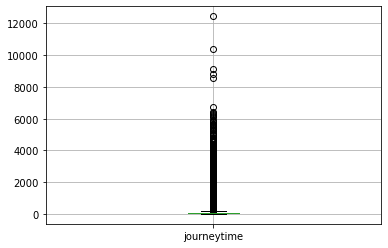

In [86]:
final.boxplot(column=['journeytime'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AAE3B43F40>]],
      dtype=object)

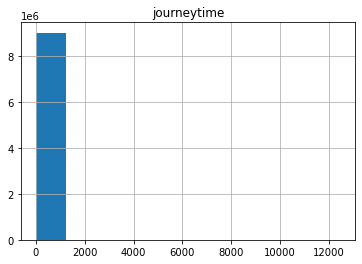

In [87]:
final.hist(column=['journeytime'])

In [88]:
print("standard deviation", final['journeytime'].std())
print("mean",final['journeytime'].mean())

standard deviation 79.69049147418892
mean 74.29063182401326


In [89]:
import math

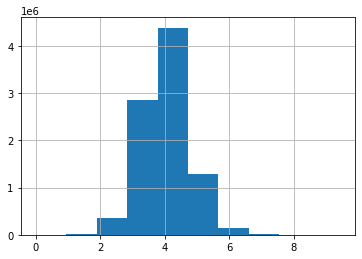

In [90]:
final["journeytime"] = final["journeytime"].transform(lambda x: math.log(x))
final["journeytime"].hist()

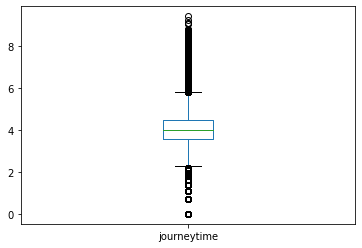

In [91]:
final["journeytime"].plot(kind="box")

In [92]:
print("standard deviation", final["journeytime"].std())
print("mean",final["journeytime"].mean())

standard deviation 0.7179564564217338
mean 4.029054557066381


as shorter journey times are more likely to be genuine as there is less reason why a bus would be significantly early compared to very long journey times which could be a result of a breakdown, road closure or other significant problem that our model would not be able to predict. This is reflected in the skewed nature of the data, in transforming the data we hope to remove this skew against longer times. For this reason we will only remove the most extreme large journey time outliers which could only have resulted from significant problems or changes on the root or to the bus itself and cannot be predicted by our model. These correspond to outliers outside 3 standard deviations from the mean on our log transformed data.

In [93]:
outtime = math.e ** (final["journeytime"].mean() + 4 * final["journeytime"].std())
print("removing outliers that are greater than: ", outtime // 60)

removing outliers that are greater than:  16.0


In [94]:
outliers = final["journeytime"][(final["journeytime"] > (final["journeytime"].mean() + 4 * final["journeytime"].std()))].index

In [95]:
outliers

Int64Index([    311,    1814,    1910,    3511,    3878,    5707,    6221,
               7611,    8760,   11854,
            ...
            8991332, 8991987, 8997652, 8997767, 9003434, 9007276, 9007641,
            9013256, 9021656, 9026839],
           dtype='int64', length=7141)

In [96]:
final = final.drop(outliers)

# Inspect the new dataframe

In [97]:
final.shape

(9020721, 34)

In [98]:
final.head()

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0  1541030400000000000  8064443     15         1             34061   
1  1541030400000000000  8064443     15         1             34061   
2  1541030400000000000  8064443     15         1             34061   
3  1541030400000000000  8064443     15         1             34061   
4  1541030400000000000  8064443     15         1             34061   

   TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
0             29160            2         6319             29193   
1             29160            3         7246             29233   
2             29160            4         6320             29318   
3             29160            5         4594             29419   
4             29160            6         4595             29570   

   Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  Monday  \
0            29192            29202    2534808  1543477120000000000       0   
1            29236            29247    2534808  1543477120000000000       0   
2            29335            29353    2534808  1543477120000000000       0   
3            29440            29462    2534808  1543477120000000000       0   
4            29546            29573    2534808  1543477120000000000       0   

   Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  journeytime  \
0        0          0         1       0         0       0     3.218876   
1        0          0         1       0         0       0     3.784190   
2        0          0         1       0         0       0     4.595120   
3        0          0         1       0         0       0     4.653960   
4        0          0         1       0         0       0     4.663439   

   previous_stop    segment  timetabledtimes  distances  rain  temp  wetb  \
0           6318  6318_6319      23000000000   0.191049   0.0   2.7   2.4   
1           6319  6319_7246      33000000000   0.229054   0.0   2.7   2.4   
2           7246  7246_6320      67000000000   0.352163   0.0   2.7   2.4   
3           6320  6320_4594      48000000000   0.277041   0.0   2.7   2.4   
4           4594  4594_4595      72000000000   0.705783   0.0   2.7   2.4   

   dewpt  vappr  rhum     msl hour  holiday  
0    2.0    7.1    95  1006.2    9        0  
1    2.0    7.1    95  1006.2    9        0  
2    2.0    7.1    95  1006.2    9        0  
3    2.0    7.1    95  1006.2    9        0  
4    2.0    7.1    95  1006.2    9        0

# Prepare the datframe for the model

# Save the new Data

In [99]:
#final.to_csv('january_cleaned.csv', index=False)

In [100]:
#final = pd.read_csv('january_cleaned.csv')

In [101]:
final.head()

DayOfService   TripID LineId Direction  TPlannedTime_Arr  \
0  1541030400000000000  8064443     15         1             34061   
1  1541030400000000000  8064443     15         1             34061   
2  1541030400000000000  8064443     15         1             34061   
3  1541030400000000000  8064443     15         1             34061   
4  1541030400000000000  8064443     15         1             34061   

   TPlannedTime_Dep  progrnumber  stoppointid  Lplannedtime_arr  \
0             29160            2         6319             29193   
1             29160            3         7246             29233   
2             29160            4         6320             29318   
3             29160            5         4594             29419   
4             29160            6         4595             29570   

   Lactualtime_arr  Lactualtime_dep  vehicleid           lastupdate  Monday  \
0            29192            29202    2534808  1543477120000000000       0   
1            29236            29247    2534808  1543477120000000000       0   
2            29335            29353    2534808  1543477120000000000       0   
3            29440            29462    2534808  1543477120000000000       0   
4            29546            29573    2534808  1543477120000000000       0   

   Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  journeytime  \
0        0          0         1       0         0       0     3.218876   
1        0          0         1       0         0       0     3.784190   
2        0          0         1       0         0       0     4.595120   
3        0          0         1       0         0       0     4.653960   
4        0          0         1       0         0       0     4.663439   

   previous_stop    segment  timetabledtimes  distances  rain  temp  wetb  \
0           6318  6318_6319      23000000000   0.191049   0.0   2.7   2.4   
1           6319  6319_7246      33000000000   0.229054   0.0   2.7   2.4   
2           7246  7246_6320      67000000000   0.352163   0.0   2.7   2.4   
3           6320  6320_4594      48000000000   0.277041   0.0   2.7   2.4   
4           4594  4594_4595      72000000000   0.705783   0.0   2.7   2.4   

   dewpt  vappr  rhum     msl hour  holiday  
0    2.0    7.1    95  1006.2    9        0  
1    2.0    7.1    95  1006.2    9        0  
2    2.0    7.1    95  1006.2    9        0  
3    2.0    7.1    95  1006.2    9        0  
4    2.0    7.1    95  1006.2    9        0

In [102]:
final.columns

Index(['DayOfService', 'TripID', 'LineId', 'Direction', 'TPlannedTime_Arr',
       'TPlannedTime_Dep', 'progrnumber', 'stoppointid', 'Lplannedtime_arr',
       'Lactualtime_arr', 'Lactualtime_dep', 'vehicleid', 'lastupdate',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'journeytime', 'previous_stop', 'segment', 'timetabledtimes',
       'distances', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl',
       'hour', 'holiday'],
      dtype='object')

In [103]:
dropped = ['Direction', 'LineId','Lplannedtime_arr',  'TPlannedTime_Arr', 'stoppointid', 'previous_stop', 'segment',
       'TPlannedTime_Dep', 'progrnumber','Lactualtime_arr', 'Lactualtime_dep','vehicleid', 'lastupdate', 'wetb' ,'dewpt', 'vappr']

In [104]:
final = final.drop(columns=dropped)

In [105]:
final = pd.get_dummies(final)

In [106]:
final

DayOfService   TripID  Monday  Tuesday  Wednesday  Thursday  \
0        1541030400000000000  8064443       0        0          0         1   
1        1541030400000000000  8064443       0        0          0         1   
2        1541030400000000000  8064443       0        0          0         1   
3        1541030400000000000  8064443       0        0          0         1   
4        1541030400000000000  8064443       0        0          0         1   
...                      ...      ...     ...      ...        ...       ...   
9027857  1543536000000000000  8148447       0        0          0         0   
9027858  1543536000000000000  8148447       0        0          0         0   
9027859  1543536000000000000  8148447       0        0          0         0   
9027860  1543536000000000000  8148447       0        0          0         0   
9027861  1543536000000000000  8148447       0        0          0         0   

         Friday  Saturday  Sunday  journeytime  timetabledtimes  distances  \
0             0         0       0     3.218876      23000000000   0.191049   
1             0         0       0     3.784190      33000000000   0.229054   
2             0         0       0     4.595120      67000000000   0.352163   
3             0         0       0     4.653960      48000000000   0.277041   
4             0         0       0     4.663439      72000000000   0.705783   
...         ...       ...     ...          ...              ...        ...   
9027857       1         0       0     3.637586      57000000000   0.243821   
9027858       1         0       0     4.330733      65000000000   0.373429   
9027859       1         0       0     2.302585     143000000000   0.178024   
9027860       1         0       0     2.944439     127000000000   0.167966   
9027861       1         0       0     2.772589      66000000000   0.052326   

         rain  temp  rhum     msl  holiday  hour_0  hour_1  hour_5  hour_6  \
0         0.0   2.7    95  1006.2        0       0       0       0       0   
1         0.0   2.7    95  1006.2        0       0       0       0       0   
2         0.0   2.7    95  1006.2        0       0       0       0       0   
3         0.0   2.7    95  1006.2        0       0       0       0       0   
4         0.0   2.7    95  1006.2        0       0       0       0       0   
...       ...   ...   ...     ...      ...     ...     ...     ...     ...   
9027857   0.0   6.2    78   996.4        0       0       0       1       0   
9027858   0.0   6.2    78   996.4        0       0       0       1       0   
9027859   0.0   6.2    78   996.4        0       0       0       1       0   
9027860   0.0   6.2    78   996.4        0       0       0       1       0   
9027861   0.0   6.2    78   996.4        0       0       0       1       0   

         hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  \
0             0       0       1        0        0        0        0        0   
1             0       0       1        0        0        0        0        0   
2             0       0       1        0        0        0        0        0   
3             0       0       1        0        0        0        0        0   
4             0       0       1        0        0        0        0        0   
...         ...     ...     ...      ...      ...      ...      ...      ...   
9027857       0       0       0        0        0        0        0        0   
9027858       0       0       0        0        0        0        0        0   
9027859       0       0       0        0        0        0        0        0   
9027860       0       0       0        0        0        0        0        0   
9027861       0       0       0        0        0        0        0        0   

         hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
0              0        0        0        0        0        0        0   
1              0        0        0        0        0        0        0   
2         

# Create X and y, features and target outcome

In [107]:
y = final["journeytime"]

In [108]:
X_col = list(final.columns)
X_col.remove("journeytime")
X_col.remove("TripID") # use this for testing
X_col.remove('DayOfService')

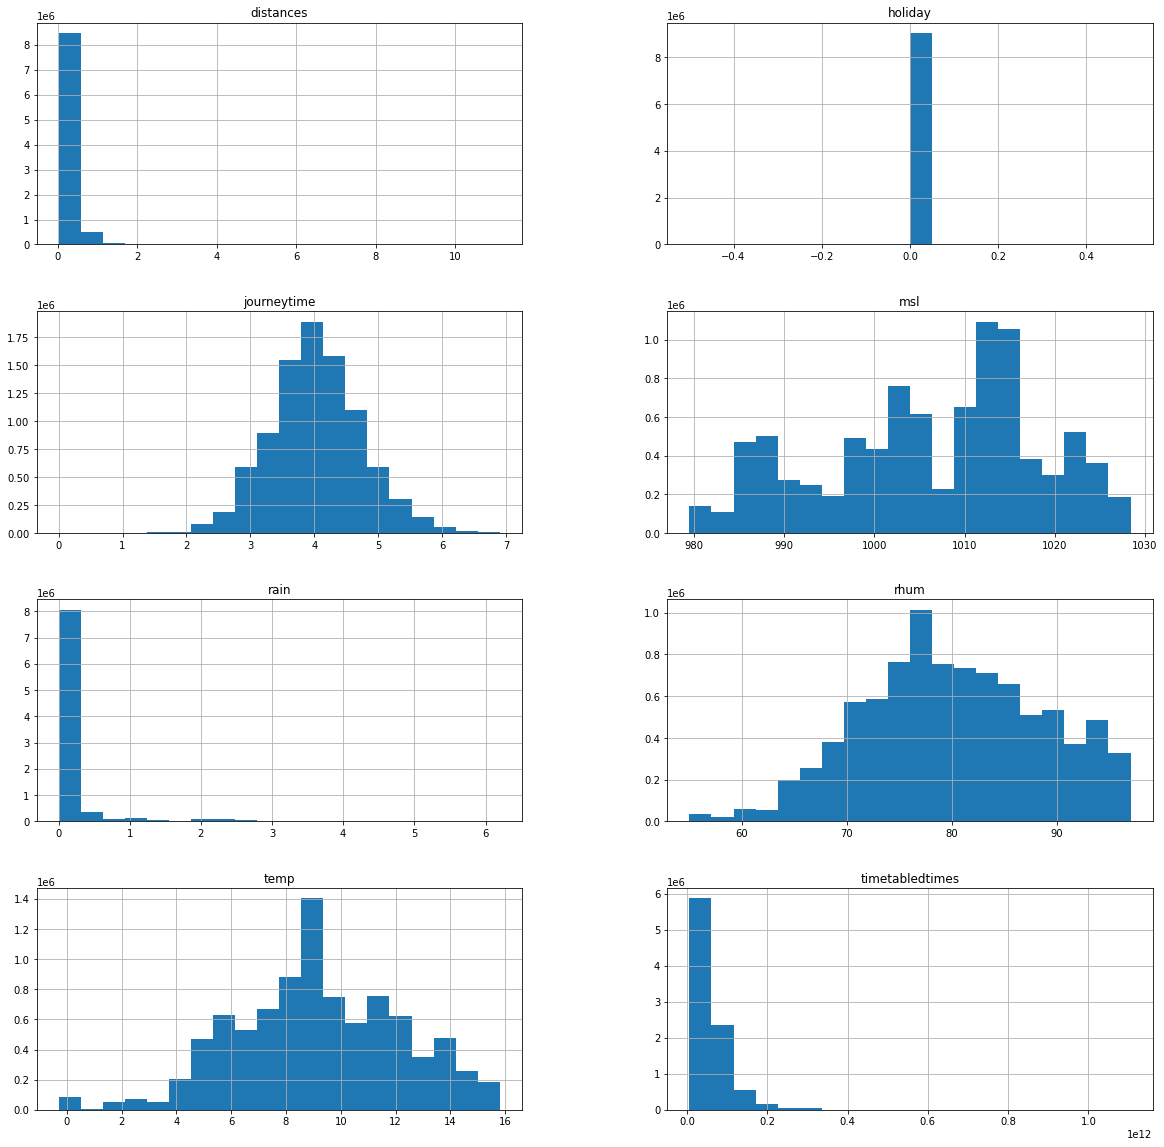

In [109]:
final[["journeytime","timetabledtimes","distances","rain","temp","rhum","msl","holiday"]].hist(layout=(4, 2), figsize=(20,20), bins=20)
plt.show()

We will transform highly skewed features distances and timetabledtimes, we decided on the use of log transformation as this gave the best approximation to the normal distrubution compared to other options such as square root etc.

In [110]:
final["distances"] = final["distances"].transform(lambda x: math.log(x))
final["timetabledtimes"] = final["timetabledtimes"].transform(lambda x: math.log(x))

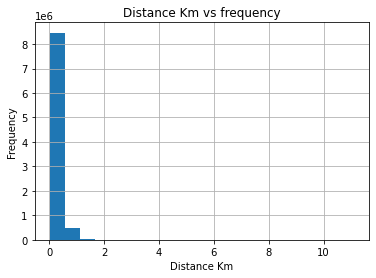

In [111]:
final["distances"].transform(lambda x: math.e ** (x)).hist(bins=20)
plt.title("Distance Km vs frequency")
plt.xlabel('Distance Km')
plt.ylabel('Frequency')
plt.show()

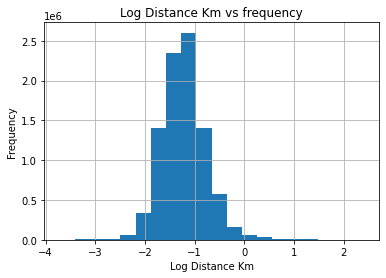

In [112]:
final["distances"].hist(bins=20)
plt.title("Log Distance Km vs frequency")
plt.xlabel('Log Distance Km')
plt.ylabel('Frequency')
plt.show()

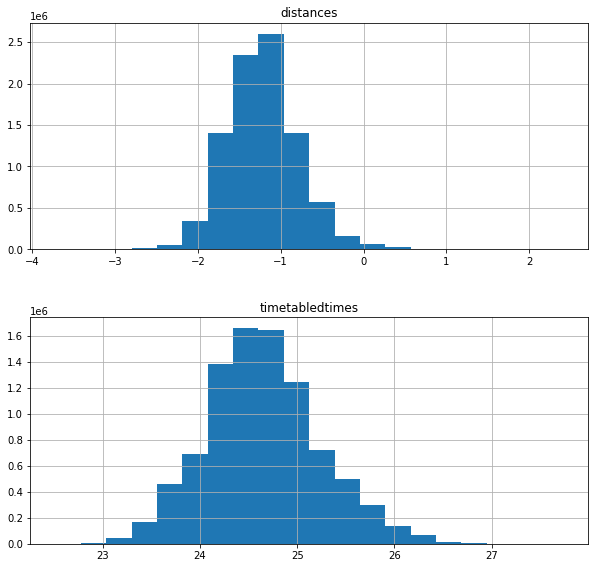

In [113]:
final[["timetabledtimes","distances"]].hist(layout=(3, 1), figsize=(10,15), bins=20)
plt.show()

In [114]:
X = final[X_col]

### As the data is timeseries split the data accordingly

In [115]:
test_size = int(X.shape[0] * 0.7)

In [116]:
X_train, X_test, y_train, y_test = X.loc[final.index[:test_size]], X.loc[final.index[test_size:]], y.loc[final.index[:test_size]], y.loc[final.index[test_size:]]

In [117]:
X_train.shape

(6314504, 35)

In [118]:
features = X_train.columns

In [119]:
for feature in features:
    print(feature)

Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday
timetabledtimes
distances
rain
temp
rhum
msl
holiday
hour_0
hour_1
hour_5
hour_6
hour_7
hour_8
hour_9
hour_10
hour_11
hour_12
hour_13
hour_14
hour_15
hour_16
hour_17
hour_18
hour_19
hour_20
hour_21
hour_22
hour_23


### Fit a linear regression model on the data

In [120]:
linreg = LinearRegression().fit(X_train, y_train)

In [121]:
results = linreg.predict(X_train)

In [122]:
print("MAE", metrics.mean_absolute_error(y_train, results))
print("MSE",metrics.mean_squared_error(y_train, results))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_train, results)))

MAE 0.4325530922415007
MSE 0.305745942826542
RMSE 0.5529429833414491


### Get the average difference in time in minuites and seconds compared to the actual time

In [123]:
mean_time_error = sum(abs((math.e ** y_train) - (math.e ** results)))/ len(y_train)
str(pd.to_timedelta(mean_time_error, unit='s'))

'0 days 00:00:30.007798'

In [124]:
results = linreg.predict(X_test)

In [125]:
print("MAE", metrics.mean_absolute_error(y_test, results))
print("MSE",metrics.mean_squared_error(y_test, results))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, results)))

MAE 0.4330451289361882
MSE 0.30631720751233776
RMSE 0.5534593097169274


In [126]:
mean_time_error = sum(abs((math.e ** y_test) - (math.e ** results)))/ len(y_test)
str(pd.to_timedelta(mean_time_error, unit='s'))

'0 days 00:00:30.449985'

In [127]:
print("Features: \n", features)
print("\nCoeficients: \n", linreg.coef_)
print("\nIntercept: \n", linreg.intercept_)

Features: 
 Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'timetabledtimes', 'distances', 'rain', 'temp', 'rhum', 'msl',
       'holiday', 'hour_0', 'hour_1', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

Coeficients: 
 [-3.90686136e+07 -3.90686136e+07 -3.90686135e+07 -3.90686135e+07
 -3.90686135e+07 -3.90686137e+07 -3.90686137e+07  5.51065346e-01
  3.36911524e-01  2.45753411e-02  2.31999229e-03 -5.90303714e-05
 -2.91516539e-04  6.06318316e+07 -8.20181491e+08 -8.20181491e+08
 -8.20181491e+08 -8.20181491e+08 -8.20181491e+08 -8.20181490e+08
 -8.20181490e+08 -8.20181490e+08 -8.20181490e+08 -8.20181490e+08
 -8.20181490e+08 -8.20181490e+08 -8.20181490e+08 -8.20181490e+08
 -8.20181490e+08 -8.20181490e+08 -8.20181490e+08 -8.20181490e+08
 -8.2018149

In [128]:
importance = pd.DataFrame({'feature': features, 'importance':linreg.coef_})
importance.sort_values('importance', ascending=False)

feature    importance
13          holiday  6.063183e+07
7   timetabledtimes  5.510653e-01
8         distances  3.369115e-01
9              rain  2.457534e-02
10             temp  2.319992e-03
11             rhum -5.903037e-05
12              msl -2.915165e-04
2         Wednesday -3.906861e+07
3          Thursday -3.906861e+07
4            Friday -3.906861e+07
1           Tuesday -3.906861e+07
0            Monday -3.906861e+07
5          Saturday -3.906861e+07
6            Sunday -3.906861e+07
28          hour_17 -8.201815e+08
29          hour_18 -8.201815e+08
27          hour_16 -8.201815e+08
20           hour_9 -8.201815e+08
26          hour_15 -8.201815e+08
19           hour_8 -8.201815e+08
25          hour_14 -8.201815e+08
30          hour_19 -8.201815e+08
24          hour_13 -8.201815e+08
23          hour_12 -8.201815e+08
21          hour_10 -8.201815e+08
22          hour_11 -8.201815e+08
31          hour_20 -8.201815e+08
18           hour_7 -8.201815e+08
32          hour_21 -8.201815e+08
33          hour_22 -8.201815e+08
17           hour_6 -8.201815e+08
34          hour_23 -8.201815e+08
16           hour_5 -8.201815e+08
14           hour_0 -8.201815e+08
15           hour_1 -8.201815e+08

As we can see from the above the categorical features, days of the week and time of day all have the same coefficient, this suggests that the model has not identified differences between different days of the week or hours of the day and their impact on the journey time. This could suggest that the model is over reliant on other featires like timetabledtimes or temp for example and that hour of day and day of the week are not as important in the model as these and should be dropped.

# Random Forrest

From testing the random forrest model was found to be the most accurate model, however the size of the model for one month was over 14Gb and so will not be run

In [129]:
#rf = RandomForestRegressor(random_state=0, n_jobs=10).fit(X_train, y_train)

In [130]:
#importance = pd.DataFrame({'feature': features, 'importance':rf.feature_importances_})
#importance.sort_values('importance', ascending=False)

In [131]:
#results = rf.predict(X_train)

In [132]:
#print("MAE", metrics.mean_absolute_error(y_train, results))
#print("MSE",metrics.mean_squared_error(y_train, results))
#print("RMSE",np.sqrt(metrics.mean_squared_error(y_train, results)))

In [133]:
#mean_time_error = sum(abs((math.e ** y_train) - (math.e ** results)))/ len(y_train)
#str(pd.to_timedelta(mean_time_error, unit='s'))

In [134]:
#results = rf.predict(X_test)

In [135]:
#print("MAE", metrics.mean_absolute_error(y_test, results))
#print("MSE",metrics.mean_squared_error(y_test, results))
#print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, results)))

In [136]:
#mean_time_error = sum(abs((math.e ** y_test) - (math.e **results)))/ len(y_test)
#mae_time = str(pd.to_timedelta(mean_time_error, unit='s'))
#print("MAE converted to time:", mae_time)

# Gradient Boosted Regressor

In [137]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [138]:
results = reg.predict(X_train)

In [139]:
print("MAE", metrics.mean_absolute_error(y_train, results))
print("MSE",metrics.mean_squared_error(y_train, results))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_train, results)))

MAE 0.4189694505423062
MSE 0.2876477338324841
RMSE 0.5363280095543064


In [140]:
mean_time_error = sum(abs((math.e ** y_train) - (math.e **results)))/ len(y_train)
str(pd.to_timedelta(mean_time_error, unit='s'))

'0 days 00:00:28.903893'

In [141]:
results = reg.predict(X_test)

In [142]:
print("MAE", metrics.mean_absolute_error(y_test, results))
print("MSE",metrics.mean_squared_error(y_test, results))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, results)))

MAE 0.4198670149496262
MSE 0.28888572667101947
RMSE 0.5374809081921138


In [143]:
mean_time_error = sum(abs((math.e ** y_test) - (math.e **results)))/ len(y_test)
str(pd.to_timedelta(mean_time_error, unit='s'))

'0 days 00:00:29.355041'

# Test Trips

## We will now test the models on the total trip time for the test data

In [144]:
trips = final.loc[final.index[test_size:]][["TripID", "DayOfService"]].drop_duplicates()[:1000]

In [145]:
trips

TripID         DayOfService
6319574  8116025  1542844800000000000
6319611  8116064  1542844800000000000
6319652  8116076  1542844800000000000
6319736  8116086  1542844800000000000
6319776  8116142  1542844800000000000
...          ...                  ...
6369357  8119045  1542844800000000000
6369403  8119098  1542844800000000000
6369446  8119105  1542844800000000000
6369483  8119143  1542844800000000000
6369532  8119151  1542844800000000000

[1000 rows x 2 columns]

In [146]:
def test_trips(trips, model):
    trip_time = []
    for index in trips.index:
        trip_journeys = final[(final["TripID"] == final.loc[index]["TripID"])&(final["DayOfService"] == final.loc[index]["DayOfService"])]["journeytime"]
        predicttime = 0
        for i in trip_journeys.index:
            #print(i)
            result = model.predict([final.loc[i][X_col]])
            predicttime += math.e ** abs(result[0] - final.loc[i]["journeytime"])
        trip_time.append(predicttime)
    return sum(trip_time) / len(trips.index)

In [147]:
print("average trip error linear regression: %.2f seconds" % test_trips(trips, linreg))

average trip error linear regression: 81.85 seconds


In [148]:
#print("average trip error random forrest: %.2f seconds" % test_trips(trips, rf))

In [149]:
print("average trip error gradient boost: %.2f seconds" % test_trips(trips, reg))

average trip error gradient boost: 80.42 seconds


In [150]:
# temporal cross validation from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
def temporal_cv(model):
    tscv = tss(n_splits=3)
    i = 1
    for train_index, test_index in tscv.split(X):
        print("Temporal Cross validation split", i)
        i += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        trained = model.fit(X_train[features], y_train)
        results = trained.predict(X_test[features])
        print("MAE", metrics.mean_absolute_error(y_test, results))
        print("MSE",metrics.mean_squared_error(y_test, results))
        print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, results)))
        mean_time_error = sum(abs((math.e ** y_test) - (math.e **results)))/ len(y_test)
        mae_time = str(pd.to_timedelta(mean_time_error, unit='s'))
        print("MAE converted to time:", mae_time)

In [151]:
print("Linear Regression")
l = LinearRegression()
temporal_cv(l)
#print("Random Forest")
#rfr = RandomForestRegressor(random_state=0, n_jobs=10)
#temporal_cv(rfr)
print("Gradient Boosted Regressor")
gbr = GradientBoostingRegressor(random_state=0)
temporal_cv(gbr)

Linear Regression
Temporal Cross validation split 1
MAE 0.434802100092329
MSE 0.3091341679388551
RMSE 0.5559983524605582
MAE converted to time: 0 days 00:00:30.490098
Temporal Cross validation split 2
MAE 0.4340934191547831
MSE 0.30797652603976455
RMSE 0.5549563280473199
MAE converted to time: 0 days 00:00:30.378256
Temporal Cross validation split 3
MAE 0.43267905371512155
MSE 0.3058401411880818
RMSE 0.5530281558728106
MAE converted to time: 0 days 00:00:30.328439
Gradient Boosted Regressor
Temporal Cross validation split 1
MAE 0.4279255003303578
MSE 0.30000674893474605
RMSE 0.5477287183768494
MAE converted to time: 0 days 00:00:29.807611
Temporal Cross validation split 2
MAE 0.42146256788336306
MSE 0.29094536792286796
RMSE 0.5393935186140708
MAE converted to time: 0 days 00:00:29.314859
Temporal Cross validation split 3
MAE 0.41946464401766065
MSE 0.2884233931782307
RMSE 0.5370506430293429
MAE converted to time: 0 days 00:00:29.237716


# Save the models!

It was found that the random forrest model while highly accurate was over 14Gb in size and so was not practical for our project and was not saved

In [152]:
#dump(rf, "./MODELS/february.joblib")
#model = load("./MODELS/february.joblib")

In [153]:
dump(linreg, "./MODELS/novlinreg.joblib")
dump(reg, "./MODELS/novgbr.joblib")

['./MODELS/novgbr.joblib']